**Libraries**

In [1]:
import pandas as pd
import numpy as np

import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
import joypy #el de las densidades guays

from sklearn import manifold  
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import os 
cwd = os.getcwd() + "/"
cwd ="/home/angela/Notebook/machine_learning/normalizados/btag_sis_error/"
from sklearn import metrics

from sklearn.neural_network import MLPClassifier
from IPython.display import display

from sklearn.ensemble import RandomForestClassifier


warnings.filterwarnings('ignore') #ATENCION QUE ESTO CREO QUE FUNCIONA PARA TODO EL NOTEBOOK

import random
random.seed(6)
np.random.seed(6)
np.random.RandomState(6)

from sklearn.preprocessing import MinMaxScaler
import pickle


Si suponemos que el 65 % es lo que conseguimos sin forzar mucho el método ( me refiero en el análisis de física en ATLAS) , podemos fijarlo en 65%
ese 35% puedes ponderarlo con las proporciones que has obtenido: así tendremos 13*35/13.6 para 1 b tag y 0.6*35/13.6 para 0 tag , ¿lo ves?
Porque en datos toy simulados reconstruimos sin ambigüedades, tenemos los 4 jets más energéticos (es un caso casi ideal) , datos simulado detallados y en dato reales hay más mala concordancia entre lo que se reconstruye e identifica y lo que es 'truth'
En el proceso de reconsturcción de jets y de elegir jets que sean los del esquema de decay de los tops nos estamos equivocando ( mismatch).
ampliando lo fake hasta el 35% estás siendo más realista

**LOAD**

In [2]:
#ALL THE DATASET

df=pd.read_pickle("/home/angela/Notebook/data/normalizados/trainpickle")
df_originaltest=pd.read_pickle("/home/angela/Notebook/data/normalizados/testpickle")

In [3]:
#SIMPLe DATASET
#df=pd.read_pickle("/home/angela/Notebook/data/normalizados/trainsimplepickle").sample(n=1000, random_state=1)
#df_originaltest=pd.read_pickle("/home/angela/Notebook/data/normalizados/testsimplepickle").sample(n=300, random_state=1)


In [4]:
df.loc[:,['jet1_btag','jet2_btag',"jet3_btag","jet4_btag"]].sum(axis=1).value_counts()/df.shape[0]*100

2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64

In [5]:
cwd2=cwd+"train2b"

df_originaltest=df_originaltest[df_originaltest.loc[:,['jet1_btag','jet2_btag',"jet3_btag","jet4_btag"]].sum(axis=1)==2]

print("test bien y variando el train")

print("B_tag_train_prop en test", "\n" ,df_originaltest.loc[:,['jet1_btag','jet2_btag',"jet3_btag","jet4_btag"]].sum(axis=1).value_counts()/df_originaltest.shape[0]*100)

print("test", pd.crosstab(df_originaltest['label'],df_originaltest['mass']))


test bien y variando el train
B_tag_train_prop en test 
 2.0    100.0
dtype: float64
test mass      0       500     750     1000    1250    1500
label                                                 
0      1537560       0       0       0       0       0
1            0  297522  295895  297661  299791  298253


# Machine learning

**We will follow the scikit-learn schema to train and validate the model**


https://scikit-learn.org/stable/modules/cross_validation.html


## RF 

In [6]:
#Scores


def Scores(y_true,y_pred):
    
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    prec=tp / (tp + fp)
    recall= tp / (tp + fn)
    F1_score= 2 * (prec * recall) / (prec + recall)
    acc=metrics.accuracy_score(y_true,y_pred)
    kappa_cohen=metrics.cohen_kappa_score(y_true,y_pred)
        
    return(tn, fp, fn, tp, acc, prec,recall, F1_score,kappa_cohen)


def model(X_train,y_train,X_test,rs=0):
    
    scaler = MinMaxScaler()

    
    
    model = RandomForestClassifier()
    #parámetros fijos: 
    params = {'n_estimators':[500],'min_samples_leaf':[1],'max_features':['sqrt'],'criterion':['entropy'], 'random_state':[rs]}

    

    grid = GridSearchCV(estimator=model, param_grid=params,cv=5,verbose=1, n_jobs=-1)

    grid.fit(X_train,y_train)
    best_model = grid.best_estimator_
    
    best_model.fit(X_train,y_train)
    # Predict test set labels
    y_pred = best_model.predict(X_test)    
    y_pred_proba = best_model.predict_proba(X_test)[::,1] #Neccesary to make the ROC curve 

    return(grid,best_model,y_pred,y_pred_proba)

## Carga

In [7]:

cwd2=cwd+"train2b"

#cargo otra vez para resetear el df
df=pd.read_pickle("/home/angela/Notebook/data/normalizados/trainpickle")
df_originaltest=pd.read_pickle("/home/angela/Notebook/data/normalizados/testpickle")
df_originaltest=df_originaltest[df_originaltest.loc[:,['jet1_btag','jet2_btag',"jet3_btag","jet4_btag"]].sum(axis=1)==2]

print("test bien y variando el train")

print("B_tag_train_prop", "\n" ,df_originaltest.loc[:,['jet1_btag','jet2_btag',"jet3_btag","jet4_btag"]].sum(axis=1).value_counts()/df_originaltest.shape[0]*100)

print("test", pd.crosstab(df_originaltest['label'],df_originaltest['mass']))


test bien y variando el train
B_tag_train_prop 
 2.0    100.0
dtype: float64
test mass      0       500     750     1000    1250    1500
label                                                 
0      1537560       0       0       0       0       0
1            0  297522  295895  297661  299791  298253


## Test constante, train constante, semilla cte


BTAG = all0
mass= 500
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   49.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


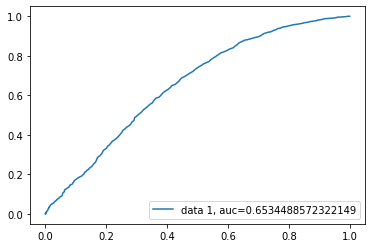

mass= 750
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   39.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


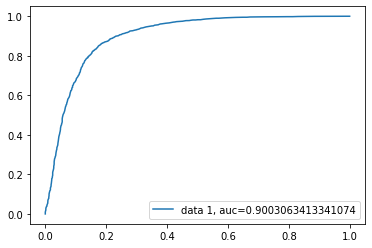

mass= 1000
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   34.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


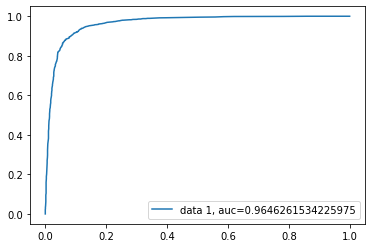

mass= 1250
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


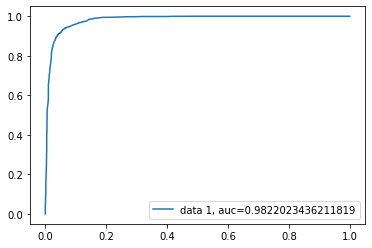

mass= 1500
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


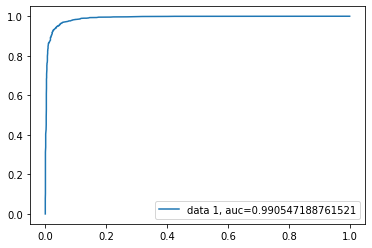

tn   fp    fn    tp       acc      prec    recall  F1_score  \
500   1989  408  1620   633  0.563871  0.608069  0.280959  0.384335   
750   1994  272   612  1772  0.809892  0.866928  0.743289  0.800361   
1000  2159  137   307  2047  0.904516  0.937271  0.869584   0.90216   
1250  2260  109   197  2084  0.934194  0.950296  0.913634  0.931605   
1500  2245   66   158  2181  0.951828  0.970628   0.93245  0.951156   

     kappa_cohen       auc  
500     0.112565  0.653449  
750     0.620947  0.900306  
1000    0.809177  0.964626  
1250    0.868246  0.982202  
1500    0.903675  0.990547

BTAG = all1
mass= 500
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   40.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


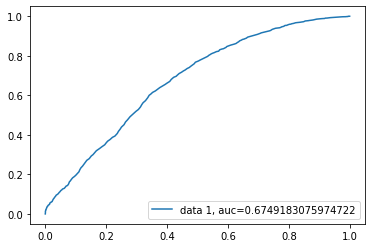

mass= 750
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   36.9s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


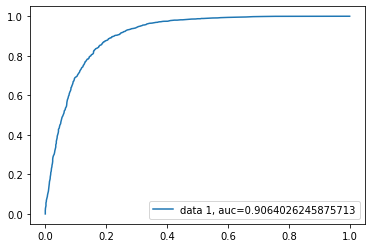

mass= 1000
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


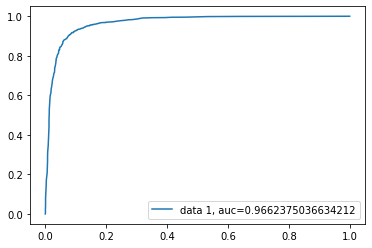

mass= 1250
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


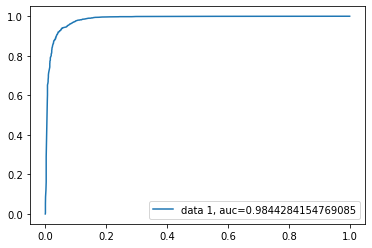

mass= 1500
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


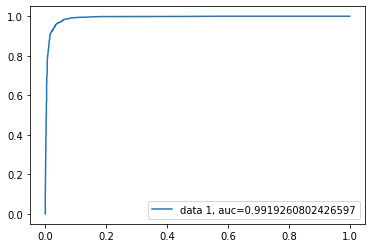

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1608  789  962  1291  0.623441  0.620673  0.573014  0.595892   
750   1900  366  408  1976  0.833548  0.843723  0.828859  0.836225   
1000  2104  192  212  2142  0.913118  0.917738  0.909941  0.913823   
1250  2255  114  166  2115  0.939785  0.948856  0.927225  0.937916   
1500  2238   73  119  2220   0.95871  0.968164  0.949124  0.958549   

     kappa_cohen       auc  
500     0.244416  0.674918  
750     0.667035  0.906403  
1000    0.826228  0.966238  
1250    0.879476  0.984428  
1500    0.917426  0.991926

BTAG = all2
mass= 500
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   48.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


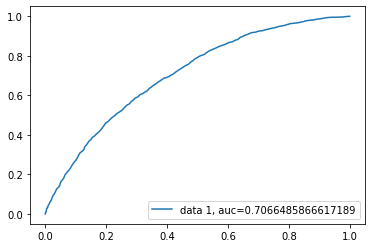

mass= 750
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   36.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


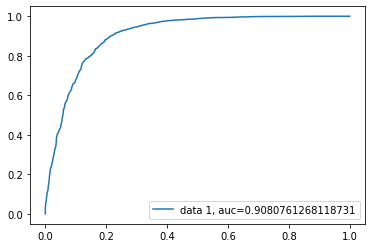

mass= 1000
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


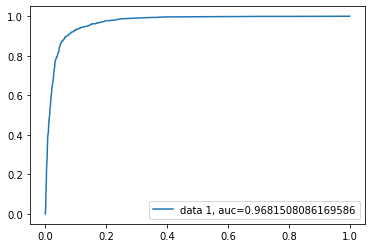

mass= 1250
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


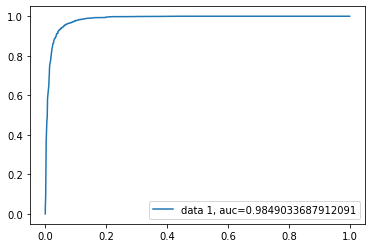

mass= 1500
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


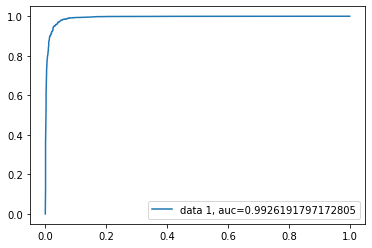

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1422  975  686  1567  0.642796  0.616444  0.695517  0.653597   
750   1788  478  251  2133  0.843226  0.816928  0.894715  0.854054   
1000  2057  239  154  2200  0.915484  0.902009  0.934579  0.918005   
1250  2222  147  108  2173  0.945161  0.936638  0.952652  0.944577   
1500  2198  113   59  2280  0.963011  0.952779  0.974776  0.963652   

     kappa_cohen       auc  
500      0.28765  0.706649  
750      0.68547  0.908076  
1000    0.830864  0.968151  
1250    0.890318  0.984903  
1500    0.926008  0.992619

BTAG = orig
mass= 500
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   50.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


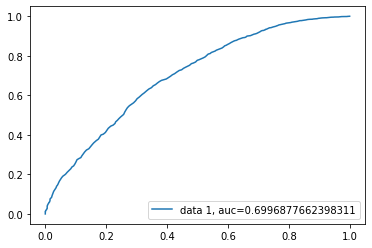

mass= 750
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   38.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


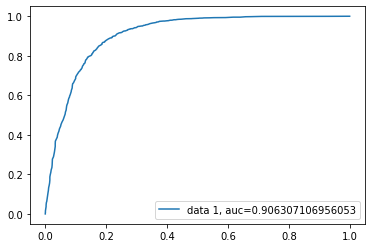

mass= 1000
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   34.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


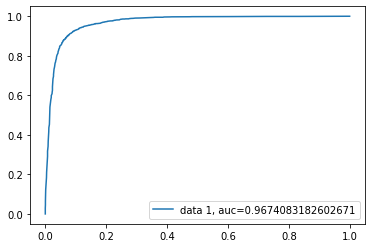

mass= 1250
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


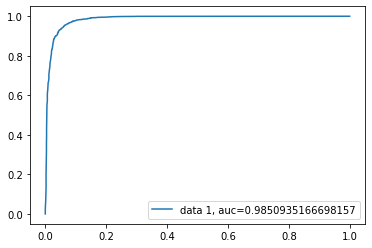

mass= 1500
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


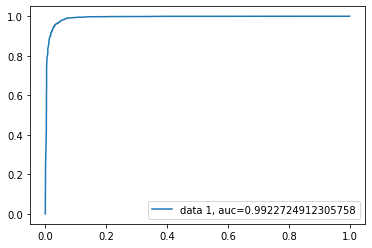

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1444  953  715  1538   0.64129  0.617423  0.682645  0.648398   
750   1804  462  283  2101  0.839785  0.819742  0.881292  0.849404   
1000  2079  217  175  2179  0.915699  0.909432  0.925658  0.917474   
1250  2229  140  125  2156  0.943011  0.939024  0.945199  0.942102   
1500  2220   91   84  2255  0.962366  0.961211  0.964087  0.962647   

     kappa_cohen       auc  
500     0.284163  0.699688  
750     0.678735  0.906307  
1000    0.831334  0.967408  
1250    0.885995  0.985094  
1500    0.924727  0.992272

BTAG = real
mass= 500
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   48.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


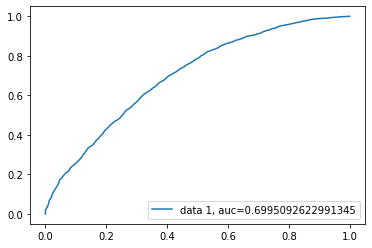

mass= 750
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   34.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


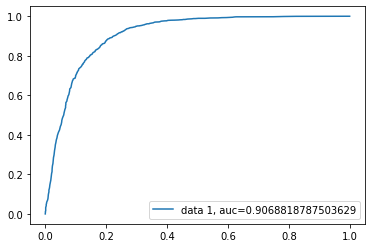

mass= 1000
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


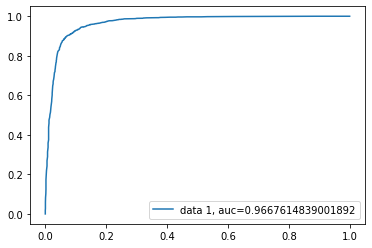

mass= 1250
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


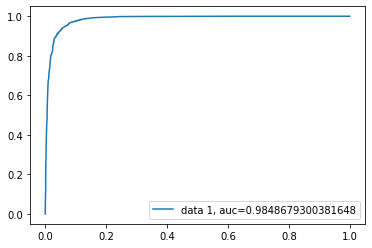

mass= 1500
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


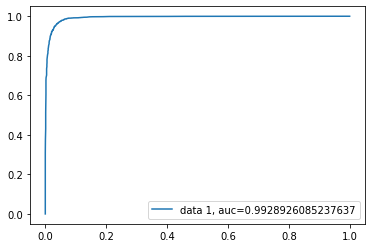

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1466  931  731  1522  0.642581  0.620465  0.675544  0.646834   
750   1825  441  326  2058  0.835054  0.823529  0.863255  0.842924   
1000  2074  222  178  2176  0.913978  0.907423  0.924384  0.915825   
1250  2231  138  132  2149  0.941935  0.939659  0.942131  0.940893   
1500  2222   89   94  2245  0.960645  0.961868  0.959812  0.960839   

     kappa_cohen       auc  
500     0.286378  0.699509  
750      0.66948  0.906882  
1000     0.82789  0.966761  
1250    0.883835  0.984868  
1500    0.921288  0.992893

<Figure size 432x288 with 0 Axes>

In [8]:
all0=[]
all1=[]
all2=[]
orig=[]
real=[]
 
#fijo la semilla:: 
rs=0
    
for btag in ["all0","all1","all2","orig","real",]:

    df_metrics = pd.DataFrame(index=[500,750,1000,1250,1500], columns=["tn", "fp", "fn", "tp", "acc", "prec","recall",
                                                                   "F1_score","kappa_cohen","auc"])
    print("BTAG =", btag)

    df_btag=df.copy()

    if btag=="all0":
        df_btag=df_btag[df_btag.loc[:,['jet1_btag','jet2_btag',"jet3_btag","jet4_btag"]].sum(axis=1)==0]
    elif btag=="all1":
        df_btag=df_btag[df_btag.loc[:,['jet1_btag','jet2_btag',"jet3_btag","jet4_btag"]].sum(axis=1)==1]
        df_btag=df_btag.sample(df_btag.shape[0], random_state=rs).reset_index(drop=True)
    elif btag=="all2":                          
        df_btag=df_btag[df_btag.loc[:,['jet1_btag','jet2_btag',"jet3_btag","jet4_btag"]].sum(axis=1)==2]
        df_btag=df_btag.sample(df_btag.shape[0], random_state=rs).reset_index(drop=True)

    elif btag=="orig":                          
        df_btag=df_btag.sample(df_btag.shape[0], random_state=rs).reset_index(drop=True)

    elif btag=="real": #65,33,2
        df0=df_btag[df_btag.loc[:,['jet1_btag','jet2_btag',"jet3_btag","jet4_btag"]].sum(axis=1)==0]
        df1=df_btag[df_btag.loc[:,['jet1_btag','jet2_btag',"jet3_btag","jet4_btag"]].sum(axis=1)==1].sample(n=int(df0.shape[0]*(33/2)), random_state=6, replace=False)
        df2=df_btag[df_btag.loc[:,['jet1_btag','jet2_btag',"jet3_btag","jet4_btag"]].sum(axis=1)==2].sample(n=int(df0.shape[0]*(65/2)), random_state=6, replace=False)
        frames = [df1, df2, df0]
        df_btag = pd.concat(frames)
        df_btag=df_btag.sample(df_btag.shape[0], random_state=rs).reset_index(drop=True)


    for i in (500,750,1000,1250,1500):

        print('mass=', i )

        dfmass1000=df_btag.loc[df_btag['mass'] == i]
        dfmass0=df_btag.loc[df_btag['mass'] == 0].sample(n=dfmass1000.shape[0], random_state=rs, replace=False)        #0 same size of dfmass1000
        dfmass1000=pd.concat([dfmass1000, dfmass0]).sample(frac=1).reset_index(drop=True)    #concatenating and shuffling
        dfmass1000=dfmass1000.drop('mass', axis=1) 

        #test


        #test
        dfmass1000test=df_originaltest.loc[df_originaltest['mass'] == i]
        dfmass0test=df_originaltest.loc[df_originaltest['mass'] == 0].sample(random_state=rs,n=dfmass1000test.shape[0])
        np.random.seed(rs)
        dfmass1000test=pd.concat([dfmass1000test, dfmass0test]).sample(frac=1).reset_index(drop=True)
        dfmass1000test=dfmass1000test.drop('mass', axis=1)



        dfmass1000=dfmass1000.sample(n=9300, random_state=rs)
        dfmass1000test=dfmass1000test.sample(n=4650, random_state=rs)

        print("B_tag_train_prop", "\n" ,df_btag.loc[:,['jet1_btag','jet2_btag',"jet3_btag","jet4_btag"]].sum(axis=1).value_counts()/df_btag.shape[0]*100)


        drop=['lep_eta', 'lep_phi',  'met_phi', 'jets_no', 'jet1_eta', 'jet1_phi', 'jet1_btag', 
           'jet2_eta', 'jet2_phi', 'jet2_btag',  'jet3_eta', 'jet3_phi',
           'jet3_btag', 'jet4_eta', 'jet4_phi', 'jet4_btag']

        X_train=dfmass1000.drop(['label'], axis=1)
        X_train=X_train.drop(drop, axis=1)
        y_train=dfmass1000.label

        X_test=dfmass1000test.drop(['label'], axis=1)
        X_test=X_test.drop(drop, axis=1)
        y_test=dfmass1000test.label

        print("X_train_shape",X_train.shape)
        print("X_test_shape",X_test.shape)




        grid,best_model,y_pred,y_pred_proba = model(X_train,y_train,X_test)
        print(best_model)


    #Roc curve construction

        fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
        auc = metrics.roc_auc_score(y_test, y_pred_proba)
        plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
        plt.legend(loc=4)
        #plt.savefig(cwd2+'MASS=' + str(i) + 'ROC.png')
        plt.show()
        plt.clf() 

    #METRICS 

        tn, fp, fn, tp, acc, prec,recall, F1_score,kappa_cohen=Scores(y_test,y_pred)

        df_metrics.tn[i]=tn
        df_metrics.fp[i]=fp
        df_metrics.fn[i]=fn
        df_metrics.tp[i]=tp
        df_metrics.acc[i]=acc
        df_metrics.prec[i]=prec
        df_metrics.recall[i]=recall
        df_metrics.F1_score[i]=F1_score
        df_metrics.kappa_cohen[i]=kappa_cohen
        df_metrics.auc[i]=auc


    display(df_metrics)
    eval(btag).append(df_metrics)


In [9]:
#esto es para que pueda hacer medias, std y no se ralle , no sirve para nada más 
all0.append(all0[0]) 
all1.append(all1[0])
all2.append(all2[0])
orig.append(orig[0])
real.append(real[0])

In [10]:
l=[all0,all1,all2,orig,real]

with open("RF_traincte_semcte.txt", "wb") as fp:   #Pickling
    pickle.dump(l, fp)
    
with open("RF_traincte_semcte.txt", "rb") as fp:   # Unpickling
    b = pickle.load(fp)


In [11]:
with open("RF_traincte_semcte.txt", "rb") as fp:   # Unpickling
    b = pickle.load(fp)

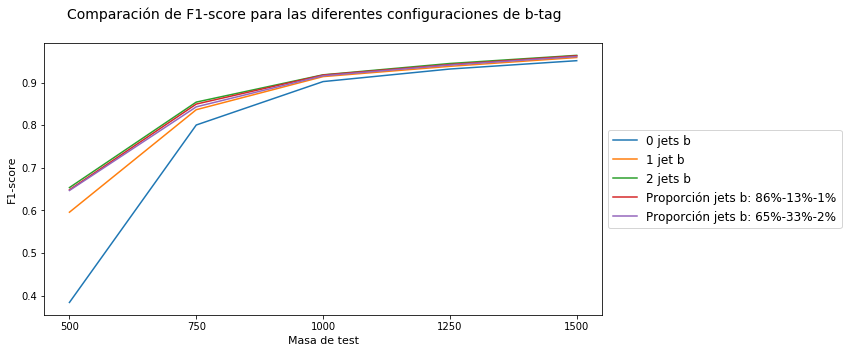

In [12]:
dfall0=pd.DataFrame()
dfall1=pd.DataFrame()
dfall2=pd.DataFrame()
orig=pd.DataFrame()
real=pd.DataFrame()

ldf=[dfall0,dfall1,dfall2,orig,real]

ldfmean=ldf.copy()
ldfstd=ldf.copy()



for j in range (5):
    ldf[j]=b[j][0]
    for i in range(len(b[j])):
        if i!=0:
            ldf[j] = pd.concat([ldf[j], b[j][i]]).apply(pd.to_numeric)
            
    ldfmean[j]=ldf[j].groupby(level=0).mean() 
    ldfstd[j]=ldf[j].groupby(level=0).std()     
    
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(["500","750","1000","1250","1500"], ldfmean[0].F1_score, label="0 jets b")
ax.plot(["500","750","1000","1250","1500"], ldfmean[1].F1_score, label="1 jet b")
ax.plot(["500","750","1000","1250","1500"], ldfmean[2].F1_score, label="2 jets b")
ax.plot(["500","750","1000","1250","1500"], ldfmean[3].F1_score, label="Proporción jets b: 86%-13%-1%")
ax.plot(["500","750","1000","1250","1500"], ldfmean[4].F1_score, label="Proporción jets b: 65%-33%-2%")

ax.fill_between(["500","750","1000","1250","1500"], ldfmean[0].F1_score - ldfstd[0].F1_score, ldfmean[0].F1_score + ldfstd[0].F1_score, alpha=0.3)
ax.fill_between(["500","750","1000","1250","1500"], ldfmean[1].F1_score - ldfstd[1].F1_score, ldfmean[1].F1_score + ldfstd[1].F1_score, alpha=0.3)
ax.fill_between(["500","750","1000","1250","1500"], ldfmean[2].F1_score - ldfstd[2].F1_score, ldfmean[2].F1_score + ldfstd[2].F1_score, alpha=0.3)
ax.fill_between(["500","750","1000","1250","1500"], ldfmean[3].F1_score - ldfstd[3].F1_score, ldfmean[3].F1_score + ldfstd[3].F1_score, alpha=0.3)
ax.fill_between(["500","750","1000","1250","1500"], ldfmean[4].F1_score - ldfstd[4].F1_score, ldfmean[4].F1_score + ldfstd[4].F1_score, alpha=0.3)



ax.set_xlabel('Masa de test', fontsize=11)
ax.set_ylabel('F1-score', fontsize=11)
ax.legend(fontsize='large',loc='center left', bbox_to_anchor=(1, 0.5))
fig.suptitle('Comparación de F1-score para las diferentes configuraciones de b-tag' , fontsize=14)
plt.show()

 ## Test constante, train cte, semilla variable

BTAG = all0
mass= 500
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   37.3s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


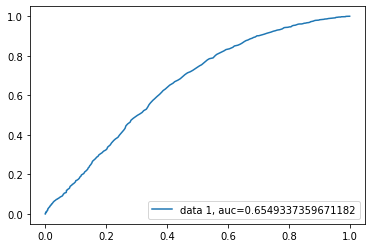

mass= 750
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   33.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


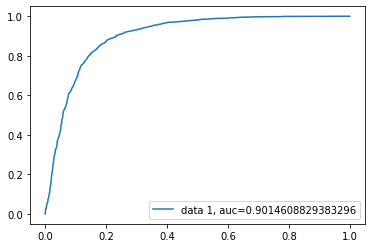

mass= 1000
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.9s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


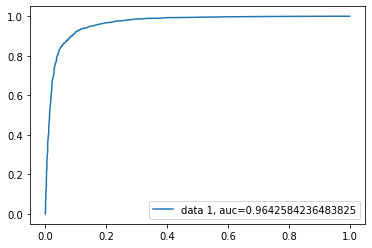

mass= 1250
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


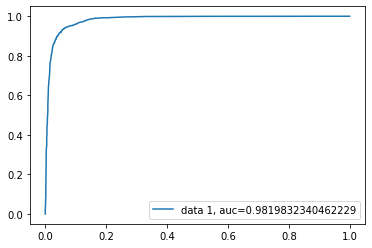

mass= 1500
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


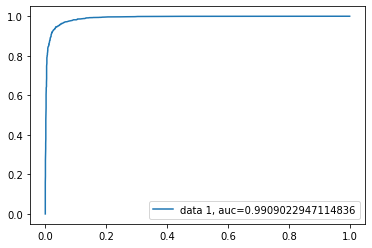

tn   fp    fn    tp       acc      prec    recall  F1_score  \
500   1993  404  1607   646  0.567527  0.615238  0.286729   0.39116   
750   2015  251   651  1733  0.806022  0.873488   0.72693  0.793498   
1000  2142  154   306  2048  0.901075  0.930064  0.870008  0.899034   
1250  2264  105   203  2078  0.933763  0.951901  0.911004  0.931004   
1500  2244   67   159  2180  0.951398  0.970182  0.932022   0.95072   

     kappa_cohen       auc  
500     0.120111  0.654934  
750     0.613482  0.901461  
1000    0.802281  0.964258  
1250    0.867374  0.981983  
1500    0.902815  0.990902

BTAG = all1
mass= 500
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   42.2s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


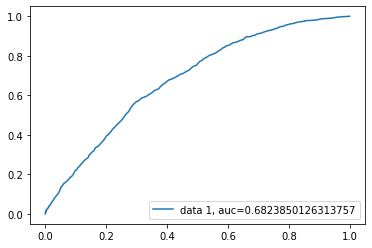

mass= 750
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


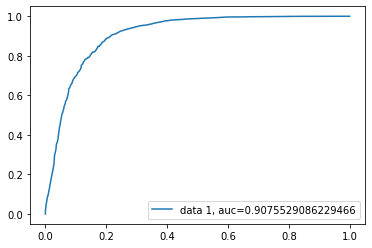

mass= 1000
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


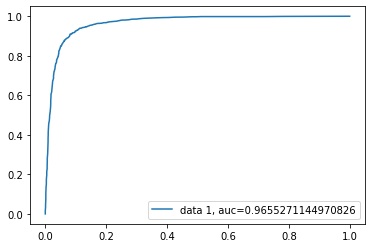

mass= 1250
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


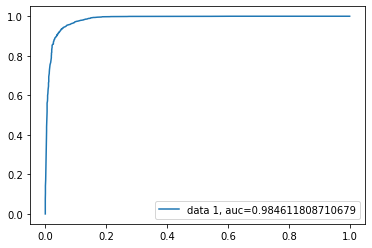

mass= 1500
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


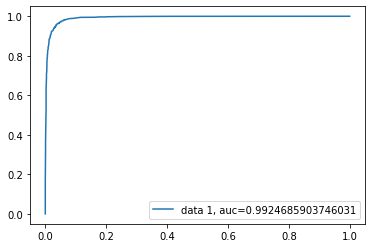

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1559  838  874  1379  0.631828  0.622012  0.612073  0.617002   
750   1891  375  414  1970  0.830323  0.840085  0.826342  0.833157   
1000  2115  181  241  2113  0.909247  0.921099  0.897621  0.909208   
1250  2247  122  157  2124      0.94  0.945681  0.931171   0.93837   
1500  2230   81  110  2229  0.958925  0.964935  0.952971  0.958916   

     kappa_cohen       auc  
500     0.262595  0.682385  
750     0.660571  0.907553  
1000    0.818525  0.965527  
1250    0.879923  0.984612  
1500    0.917853  0.992469

BTAG = all2
mass= 500
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   42.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


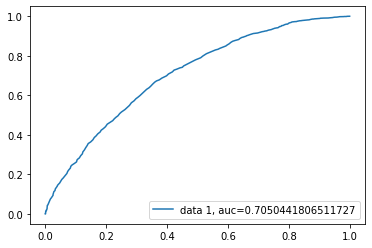

mass= 750
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   33.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


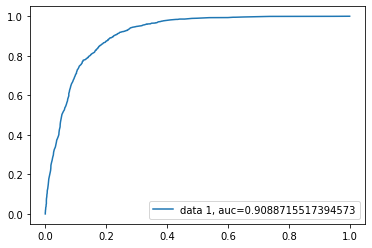

mass= 1000
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


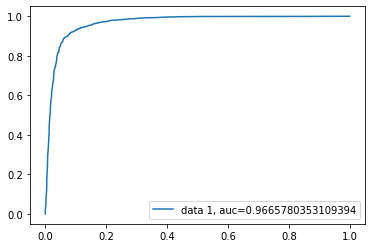

mass= 1250
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


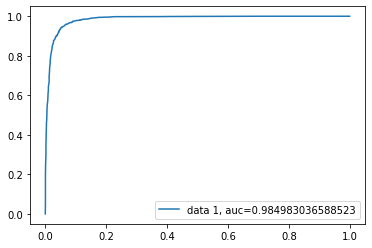

mass= 1500
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.2s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


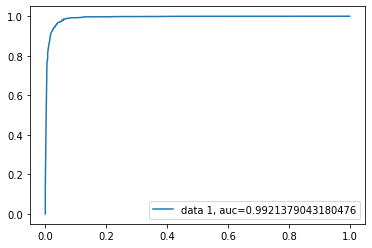

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1427  970  658  1595  0.649892  0.621832  0.707945    0.6621   
750   1787  479  266  2118  0.839785  0.815556  0.888423  0.850432   
1000  2041  255  149  2205  0.913118  0.896341  0.936703  0.916078   
1250  2224  145  114  2167  0.944301  0.937284  0.950022   0.94361   
1500  2204  107   71  2268   0.96172  0.954947  0.969645   0.96224   

     kappa_cohen       auc  
500     0.302016  0.705044  
750     0.678616  0.908872  
1000    0.826111  0.966578  
1250     0.88859  0.984983  
1500    0.923431  0.992138

BTAG = orig
mass= 500
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   42.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


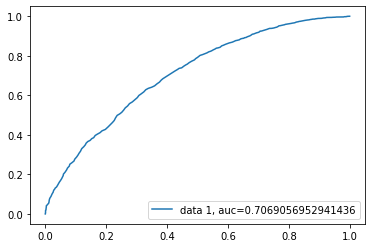

mass= 750
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


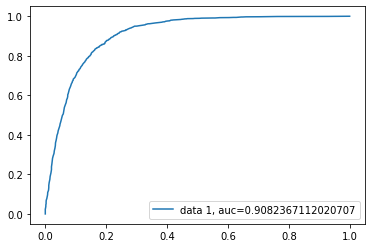

mass= 1000
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


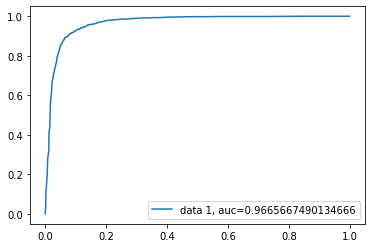

mass= 1250
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.2s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


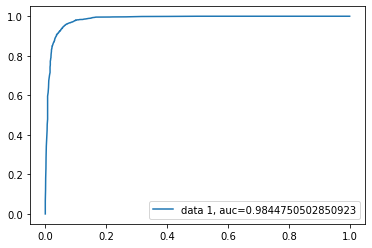

mass= 1500
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


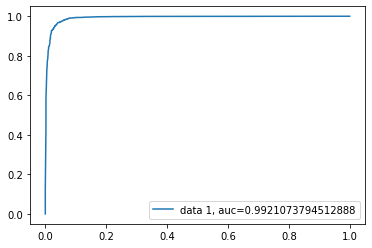

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1434  963  677  1576  0.647312  0.620717  0.699512  0.657763   
750   1801  465  289  2095  0.837849  0.818359  0.878775  0.847492   
1000  2065  231  172  2182  0.913333  0.904269  0.926933   0.91546   
1250  2234  135  129  2152  0.943226  0.940971  0.943446  0.942207   
1500  2221   90   88  2251   0.96172  0.961555  0.962377  0.961966   

     kappa_cohen       auc  
500     0.296629  0.706906  
750     0.674865  0.908237  
1000    0.826585  0.966567  
1250    0.886416  0.984475  
1500    0.923438  0.992107

BTAG = real
mass= 500
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   40.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


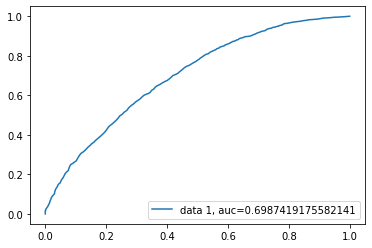

mass= 750
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.3s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


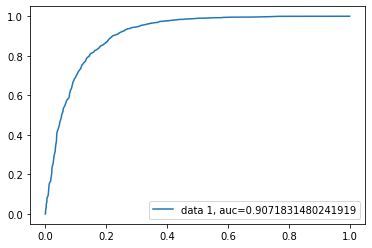

mass= 1000
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.3s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


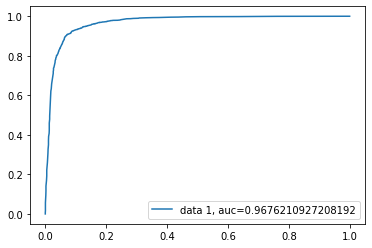

mass= 1250
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


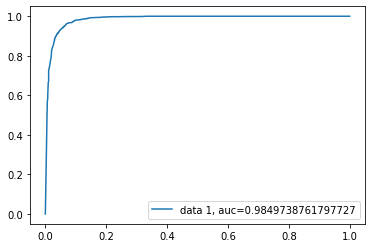

mass= 1500
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


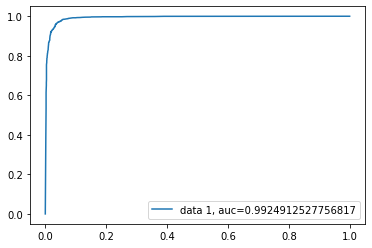

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1542  855  829  1424  0.637849  0.624835  0.632046   0.62842   
750   1811  455  311  2073  0.835269  0.820016  0.869547  0.844055   
1000  2064  232  160  2194  0.915699  0.904369  0.932031  0.917992   
1250  2243  126  143  2138  0.942151  0.944346  0.937308  0.940814   
1500  2227   84   86  2253  0.963441  0.964056  0.963232  0.963644   

     kappa_cohen       auc  
500     0.275255  0.698742  
750     0.669806  0.907183  
1000    0.831306  0.967621  
1250    0.884244  0.984974  
1500    0.926879  0.992491

BTAG = all0
mass= 500
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   39.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


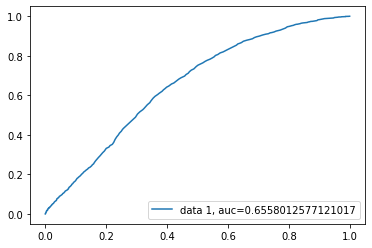

mass= 750
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


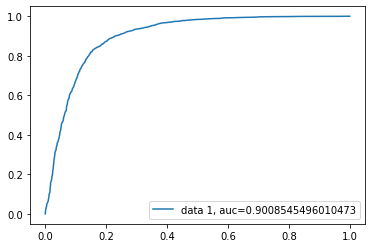

mass= 1000
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


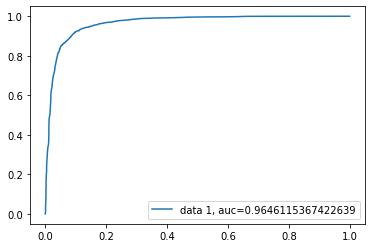

mass= 1250
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


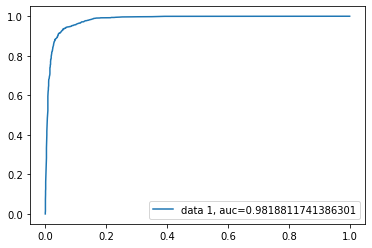

mass= 1500
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.2s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


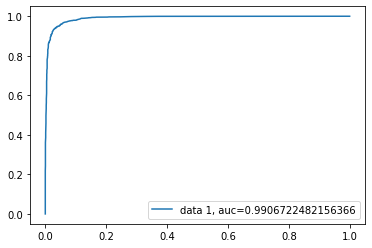

tn   fp    fn    tp       acc      prec    recall  F1_score  \
500   1966  431  1591   662  0.565161  0.605672   0.29383  0.395696   
750   2004  262   633  1751  0.807527  0.869846   0.73448  0.796452   
1000  2145  151   307  2047  0.901505  0.931301  0.869584  0.899385   
1250  2260  109   196  2085  0.934409  0.950319  0.914073  0.931844   
1500  2242   69   151  2188  0.952688  0.969428  0.935442  0.952132   

     kappa_cohen       auc  
500     0.115813  0.655801  
750      0.61636  0.900855  
1000    0.803145  0.964612  
1250    0.868677  0.981881  
1500    0.905393  0.990672

BTAG = all1
mass= 500
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   40.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


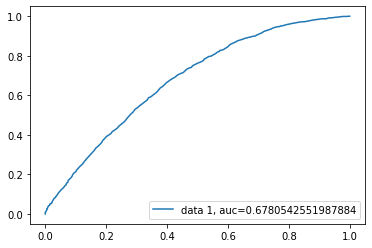

mass= 750
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   34.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


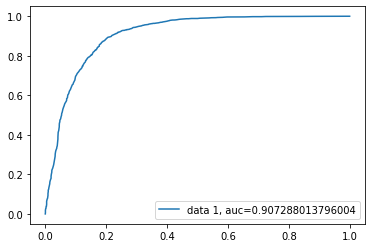

mass= 1000
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


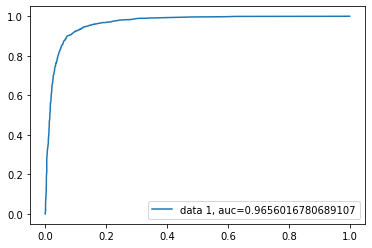

mass= 1250
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.9s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


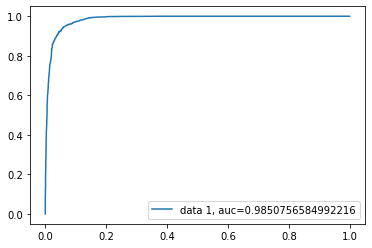

mass= 1500
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


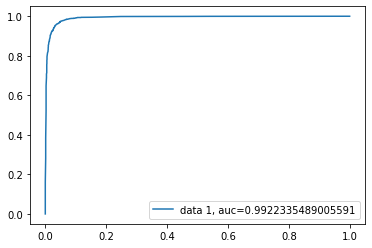

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1535  862  884  1369  0.624516  0.613626  0.607634  0.610616   
750   1885  381  403  1981  0.831398  0.838696  0.830956  0.834808   
1000  2125  171  233  2121  0.913118  0.925393   0.90102  0.913043   
1250  2246  123  164  2117   0.93828  0.945089  0.928102  0.936518   
1500  2232   79  107  2232      0.96  0.965816  0.954254      0.96   

     kappa_cohen       auc  
500     0.248091  0.678054  
750     0.662659  0.907288  
1000    0.826267  0.965602  
1250    0.876474  0.985076  
1500    0.920003  0.992234

BTAG = all2
mass= 500
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   40.9s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


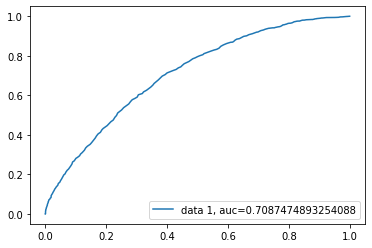

mass= 750
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.9s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


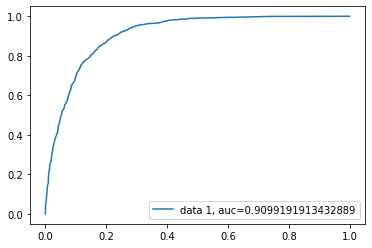

mass= 1000
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


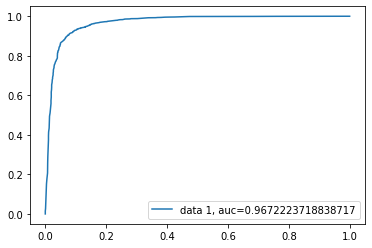

mass= 1250
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


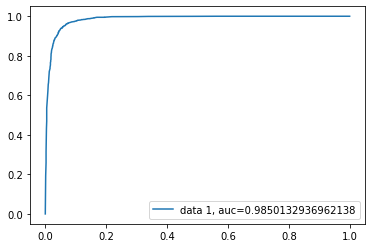

mass= 1500
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


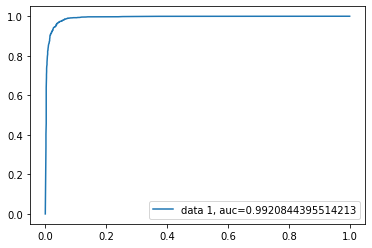

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1438  959  646  1607  0.654839  0.626267  0.713271  0.666943   
750   1783  483  267  2117   0.83871  0.814231  0.888003  0.849518   
1000  2042  254  146  2208  0.913978  0.896832  0.937978  0.916944   
1250  2227  142  115  2166  0.944731  0.938475  0.949584  0.943997   
1500  2209  102   71  2268  0.962796  0.956962  0.969645  0.963262   

     kappa_cohen       auc  
500     0.311886  0.708747  
750     0.676448  0.909919  
1000     0.82783  0.967222  
1250    0.889447  0.985013  
1500    0.925583  0.992084

BTAG = orig
mass= 500
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   43.2s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


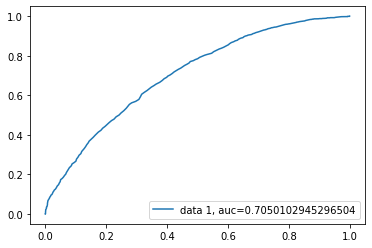

mass= 750
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   35.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


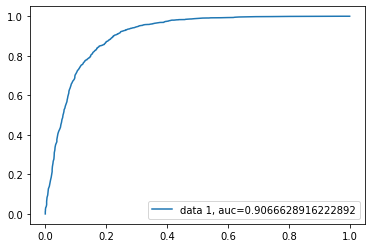

mass= 1000
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


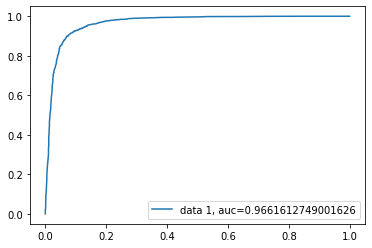

mass= 1250
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


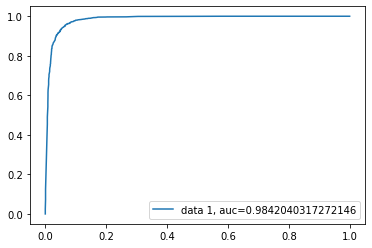

mass= 1500
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


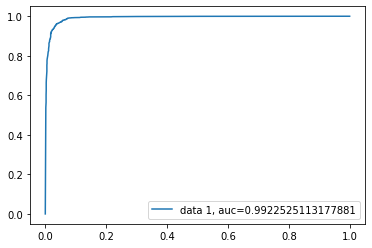

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1433  964  683  1570  0.645806  0.619574  0.696849  0.655943   
750   1789  477  281  2103  0.836989  0.815116  0.882131  0.847301   
1000  2069  227  173  2181  0.913978  0.905731  0.926508  0.916002   
1250  2234  135  131  2150  0.942796  0.940919  0.942569  0.941743   
1500  2222   89   89  2250   0.96172   0.96195   0.96195   0.96195   

     kappa_cohen       auc  
500     0.293579   0.70501  
750     0.673069  0.906663  
1000     0.82788  0.966161  
1250    0.885554  0.984204  
1500    0.923438  0.992253

BTAG = real
mass= 500
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   40.2s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


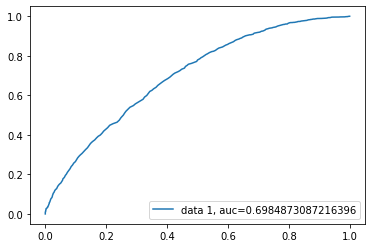

mass= 750
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


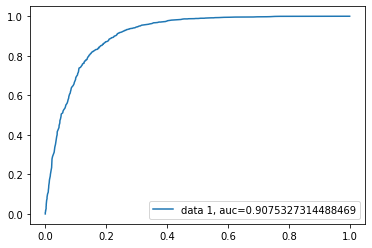

mass= 1000
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


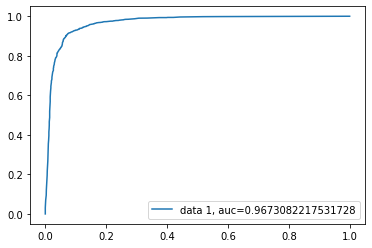

mass= 1250
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.2s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


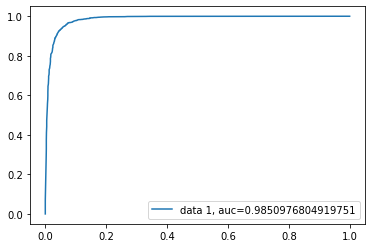

mass= 1500
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


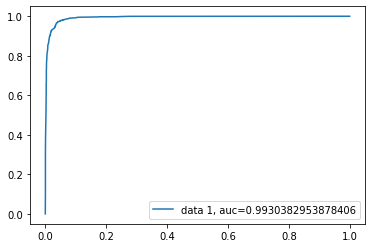

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1525  872  810  1443   0.63828  0.623326  0.640479  0.631786   
750   1819  447  314  2070  0.836344  0.822408  0.868289  0.844726   
1000  2060  236  165  2189  0.913763   0.90268  0.929907  0.916091   
1250  2244  125  144  2137  0.942151  0.944739   0.93687  0.940788   
1500  2227   84   91  2248  0.962366  0.963979  0.961094  0.962535   

     kappa_cohen       auc  
500     0.276463  0.698487  
750     0.672001  0.907533  
1000    0.827434  0.967308  
1250    0.884242  0.985098  
1500     0.92473  0.993038

BTAG = all0
mass= 500
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   37.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)


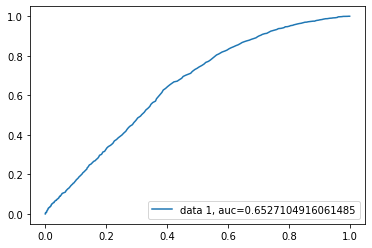

mass= 750
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.2s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)


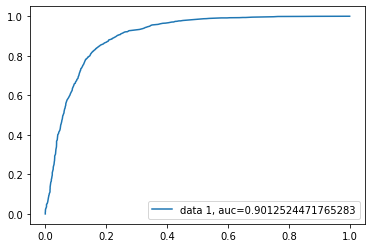

mass= 1000
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)


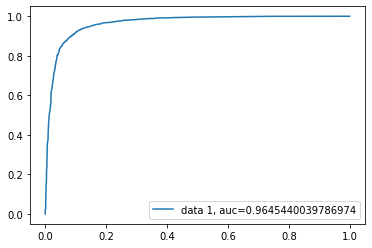

mass= 1250
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)


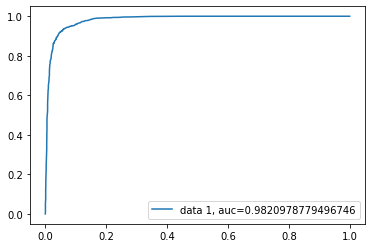

mass= 1500
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)


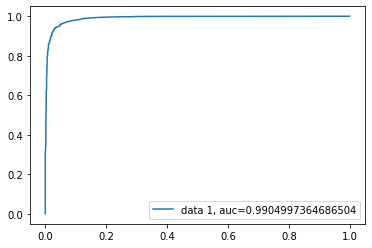

tn   fp    fn    tp       acc      prec    recall  F1_score  \
500   1975  422  1601   652  0.564946  0.607076  0.289392  0.391945   
750   2002  264   640  1744  0.805591  0.868526  0.731544  0.794171   
1000  2145  151   299  2055  0.903226   0.93155  0.872982  0.901316   
1250  2263  106   198  2083  0.934624  0.951576  0.913196  0.931991   
1500  2242   69   150  2189  0.952903  0.969442   0.93587   0.95236   

     kappa_cohen       auc  
500     0.115149   0.65271  
750     0.612523  0.901252  
1000    0.806575  0.964544  
1250    0.869102  0.982098  
1500    0.905823    0.9905

BTAG = all1
mass= 500
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   39.3s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)


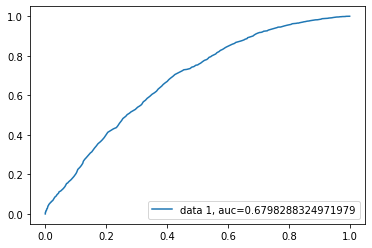

mass= 750
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.3s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)


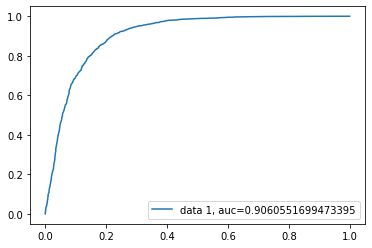

mass= 1000
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.2s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)


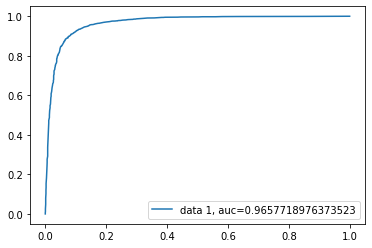

mass= 1250
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)


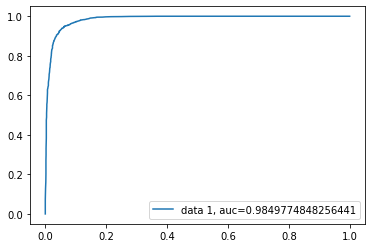

mass= 1500
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)


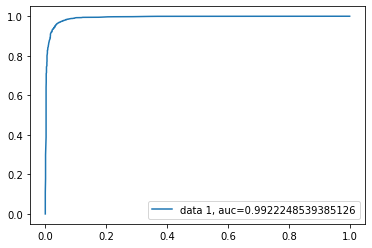

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1556  841  889  1364  0.627957  0.618594  0.605415  0.611934   
750   1886  380  398  1986  0.832688  0.839391  0.833054  0.836211   
1000  2111  185  234  2120  0.909892   0.91974  0.900595  0.910067   
1250  2250  119  157  2124  0.940645  0.946946  0.931171  0.938992   
1500  2233   78  110  2229   0.95957   0.96619  0.952971  0.959535   

     kappa_cohen       auc  
500     0.254723  0.679829  
750     0.665227  0.906055  
1000    0.819804  0.965772  
1250    0.881211  0.984977  
1500    0.919144  0.992225

BTAG = all2
mass= 500
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   42.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)


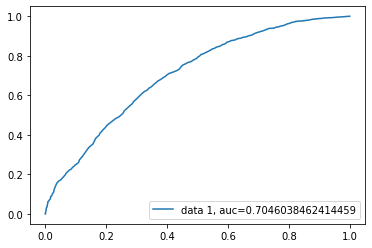

mass= 750
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)


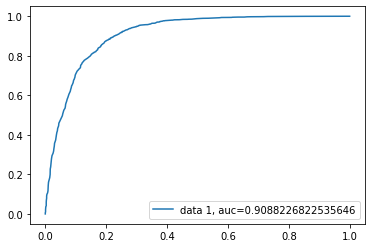

mass= 1000
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)


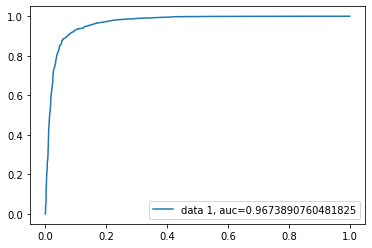

mass= 1250
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.3s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)


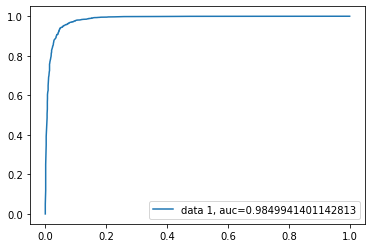

mass= 1500
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)


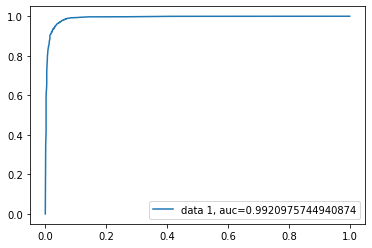

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1422  975  652  1601  0.650108  0.621506  0.710608  0.663077   
750   1783  483  273  2111  0.837419  0.813801  0.885487  0.848132   
1000  2031  265  145  2209  0.911828  0.892886  0.938403  0.915079   
1250  2225  144  108  2173  0.945806  0.937851  0.952652  0.945194   
1500  2204  107   71  2268   0.96172  0.954947  0.969645   0.96224   

     kappa_cohen       auc  
500     0.302547  0.704604  
750     0.673881  0.908823  
1000    0.823515  0.967389  
1250    0.891606  0.984994  
1500    0.923431  0.992098

BTAG = orig
mass= 500
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   36.9s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)


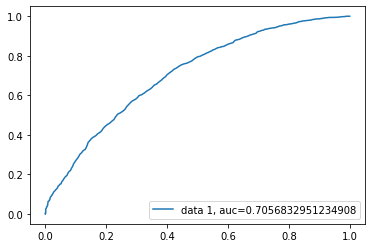

mass= 750
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   33.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)


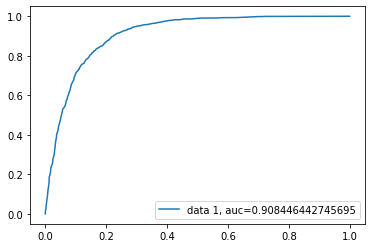

mass= 1000
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)


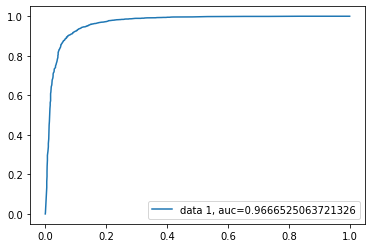

mass= 1250
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)


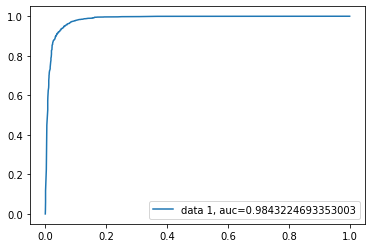

mass= 1500
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.9s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)


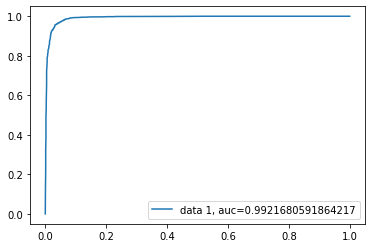

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1450  947  689  1564  0.648172  0.622859  0.694186  0.656591   
750   1791  475  281  2103  0.837419  0.815749  0.882131  0.847642   
1000  2070  226  179  2175  0.912903  0.905873  0.923959  0.914826   
1250  2226  143  125  2156  0.942366  0.937799  0.945199  0.941485   
1500  2218   93   86  2253  0.961505  0.960358  0.963232  0.961793   

     kappa_cohen       auc  
500     0.298083  0.705683  
750     0.673938  0.908446  
1000    0.825735  0.966653  
1250    0.884707  0.984322  
1500    0.923007  0.992168

BTAG = real
mass= 500
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   38.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)


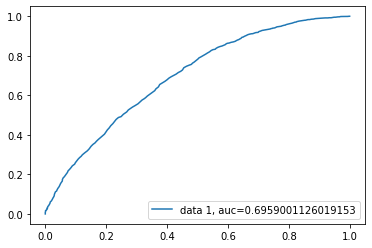

mass= 750
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)


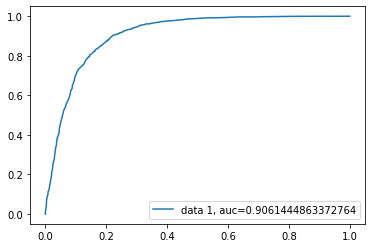

mass= 1000
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)


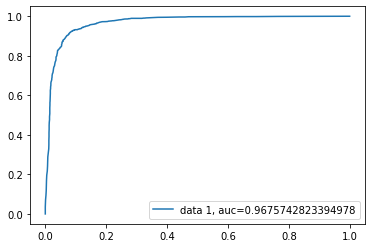

mass= 1250
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)


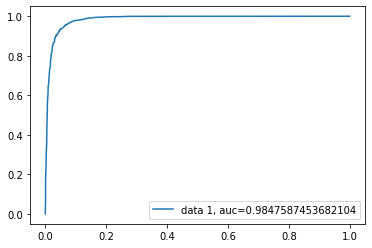

mass= 1500
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.3s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)


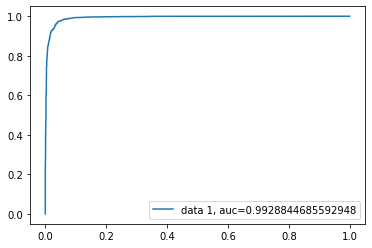

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1526  871  828  1425  0.634624  0.620645   0.63249  0.626511   
750   1814  452  305  2079  0.837204  0.821414  0.872064  0.845982   
1000  2062  234  160  2194  0.915269  0.903624  0.932031  0.917608   
1250  2243  126  142  2139  0.942366  0.944371  0.937747  0.941047   
1500  2228   83   89  2250  0.963011  0.964423   0.96195  0.963185   

     kappa_cohen       auc  
500     0.268965    0.6959  
750     0.673675  0.906144  
1000    0.830444  0.967574  
1250    0.884675  0.984759  
1500     0.92602  0.992884

BTAG = all0
mass= 500
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   38.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)


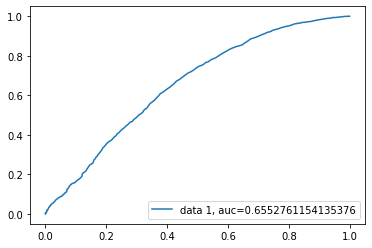

mass= 750
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)


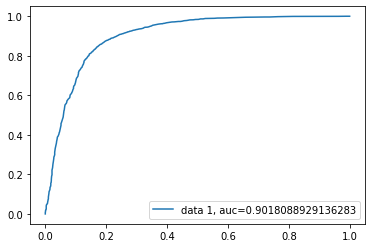

mass= 1000
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)


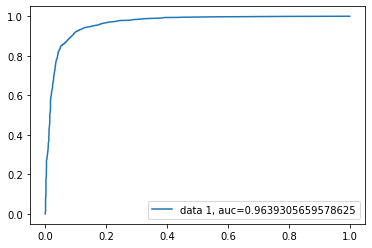

mass= 1250
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.2s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)


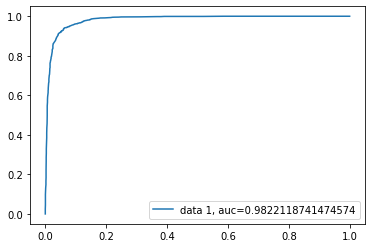

mass= 1500
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)


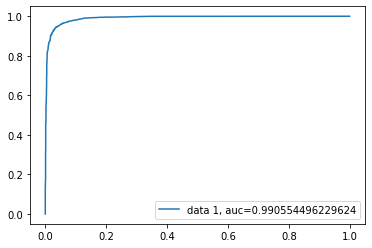

tn   fp    fn    tp       acc      prec    recall  F1_score  \
500   1988  409  1594   659  0.569247  0.617041  0.292499  0.396868   
750   2002  264   633  1751  0.807097  0.868983   0.73448   0.79609   
1000  2145  151   313  2041  0.900215  0.931113  0.867035  0.897932   
1250  2260  109   194  2087  0.934839  0.950364   0.91495  0.932321   
1500  2240   71   155  2184  0.951398  0.968514  0.933732  0.950805   

     kappa_cohen       auc  
500     0.123825  0.655276  
750     0.615495  0.901809  
1000    0.800572  0.963931  
1250     0.86954  0.982212  
1500    0.902813  0.990554

BTAG = all1
mass= 500
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   40.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)


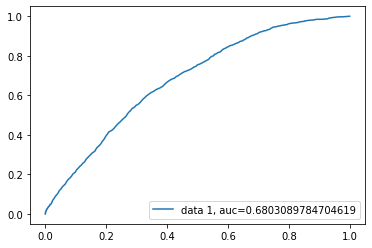

mass= 750
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   34.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)


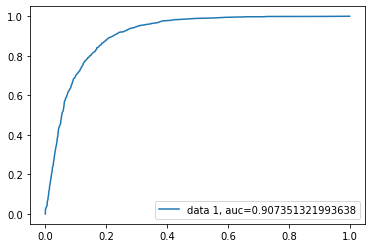

mass= 1000
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.9s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)


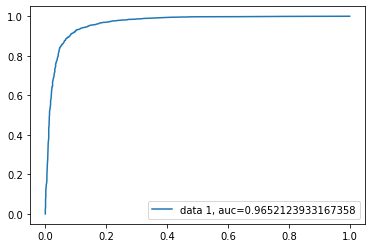

mass= 1250
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)


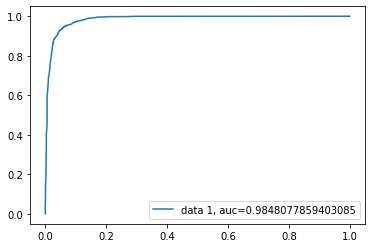

mass= 1500
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.9s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)


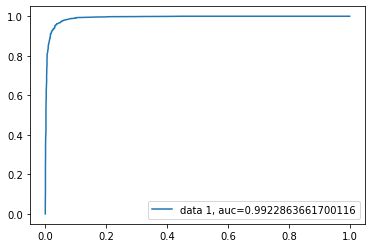

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1591  806  898  1355  0.633548  0.627025   0.60142  0.613956   
750   1891  375  407  1977  0.831828  0.840561  0.829279  0.834882   
1000  2115  181  240  2114  0.909462  0.921133  0.898046  0.909443   
1250  2249  120  156  2125  0.940645  0.946548  0.931609  0.939019   
1500  2232   79  109  2230   0.95957  0.965786  0.953399  0.959552   

     kappa_cohen       auc  
500     0.265492  0.680309  
750     0.663557  0.907351  
1000    0.818954  0.965212  
1250    0.881213  0.984808  
1500    0.919143  0.992286

BTAG = all2
mass= 500
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   39.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)


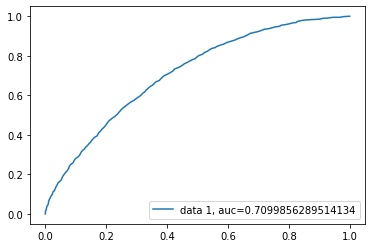

mass= 750
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)


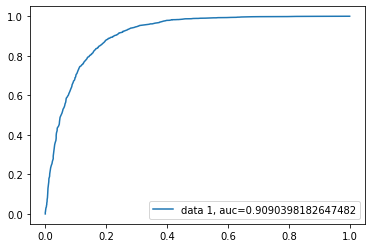

mass= 1000
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)


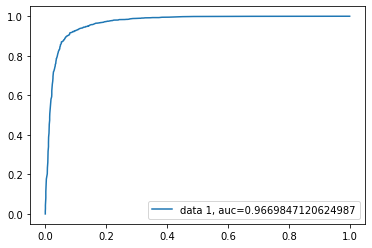

mass= 1250
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)


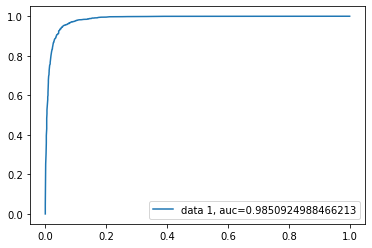

mass= 1500
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)


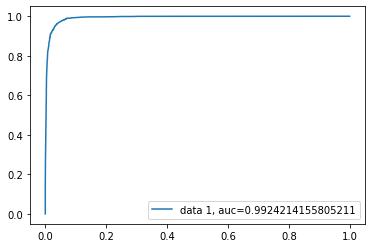

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1433  964  659  1594  0.650968  0.623143  0.707501  0.662648   
750   1782  484  257  2127  0.840645   0.81463  0.892198  0.851652   
1000  2042  254  151  2203  0.912903  0.896622  0.935854  0.915818   
1250  2229  140  110  2171  0.946237   0.93942  0.951776  0.945557   
1500  2207  104   72  2267  0.962151  0.956137  0.969218  0.962633   

     kappa_cohen       auc  
500     0.304095  0.709986  
750     0.680292   0.90904  
1000    0.825683  0.966985  
1250    0.892461  0.985092  
1500    0.924292  0.992421

BTAG = orig
mass= 500
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   43.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)


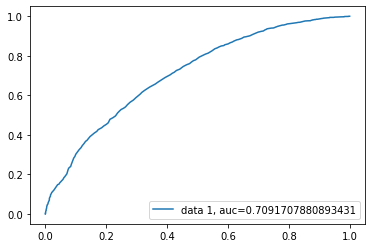

mass= 750
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.2s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)


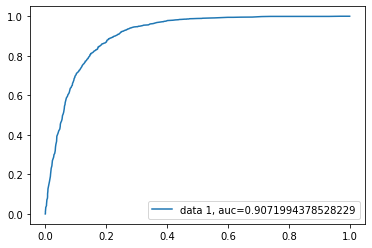

mass= 1000
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.9s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)


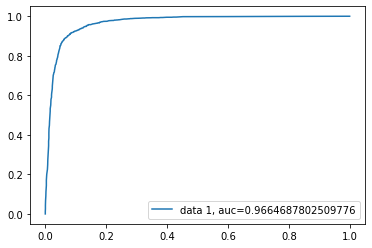

mass= 1250
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.3s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)


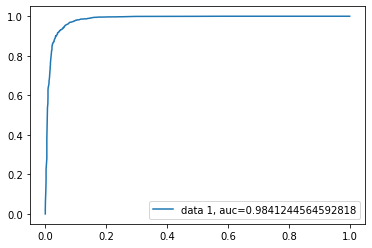

mass= 1500
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)


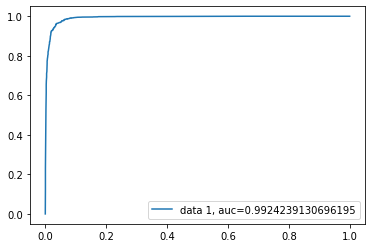

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1434  963  683  1570  0.646022  0.619818  0.696849   0.65608   
750   1795  471  276  2108  0.839355  0.817371  0.884228  0.849486   
1000  2063  233  174  2180  0.912473   0.90344  0.926083  0.914621   
1250  2227  142  132  2149  0.941075  0.938018  0.942131   0.94007   
1500  2224   87   86  2253  0.962796  0.962821  0.963232  0.963026   

     kappa_cohen       auc  
500     0.293999  0.709171  
750     0.677816  0.907199  
1000    0.824864  0.966469  
1250    0.882118  0.984124  
1500    0.925589  0.992424

BTAG = real
mass= 500
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   40.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)


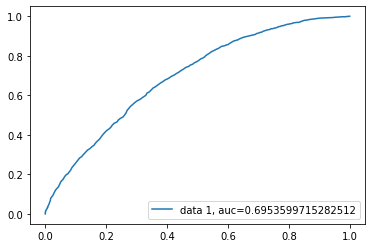

mass= 750
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)


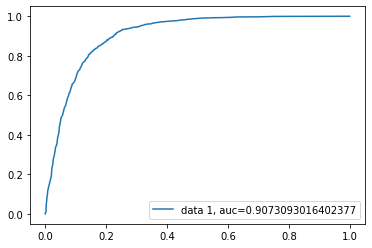

mass= 1000
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.2s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)


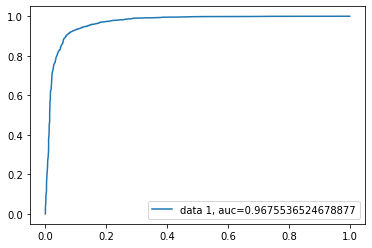

mass= 1250
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)


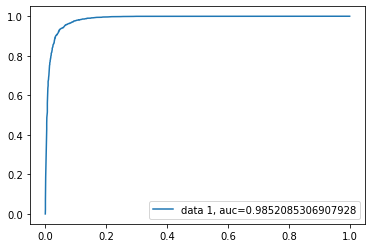

mass= 1500
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)


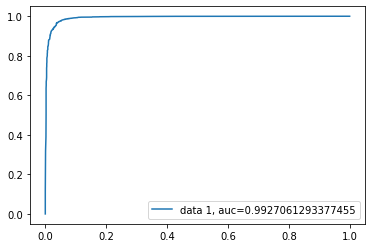

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1547  850  817  1436  0.641505  0.628171  0.637372  0.632738   
750   1809  457  300  2084  0.837204   0.82015  0.874161  0.846294   
1000  2067  229  160  2194  0.916344  0.905489  0.932031  0.918568   
1250  2248  121  144  2137  0.943011  0.946413   0.93687  0.941617   
1500  2227   84   84  2255  0.963871  0.964087  0.964087  0.964087   

     kappa_cohen       auc  
500     0.282638   0.69536  
750     0.673639  0.907309  
1000      0.8326  0.967554  
1250    0.885959  0.985209  
1500    0.927739  0.992706

BTAG = all0
mass= 500
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   42.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=4, verbose=0,
                       warm_start=False)


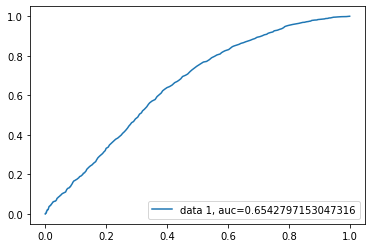

mass= 750
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=4, verbose=0,
                       warm_start=False)


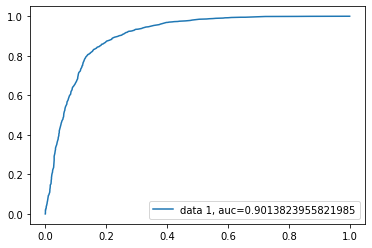

mass= 1000
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=4, verbose=0,
                       warm_start=False)


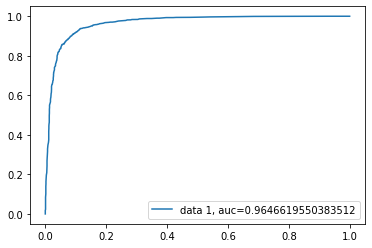

mass= 1250
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=4, verbose=0,
                       warm_start=False)


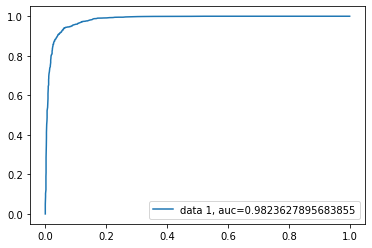

mass= 1500
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=4, verbose=0,
                       warm_start=False)


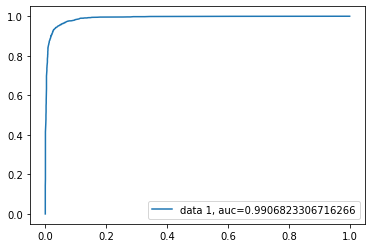

tn   fp    fn    tp       acc      prec    recall  F1_score  \
500   1983  414  1614   639  0.563871  0.606838  0.283622   0.38657   
750   2005  261   659  1725  0.802151   0.86858  0.723574  0.789474   
1000  2148  148   311  2043   0.90129  0.932451  0.867884   0.89901   
1250  2258  111   199  2082  0.933333  0.949384  0.912758  0.930711   
1500  2243   68   153  2186  0.952473  0.969831  0.934587  0.951883   

     kappa_cohen       auc  
500     0.112709   0.65428  
750      0.60576  0.901382  
1000    0.802722  0.964662  
1250    0.866523  0.982363  
1500    0.904964  0.990682

BTAG = all1
mass= 500
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.3s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=4, verbose=0,
                       warm_start=False)


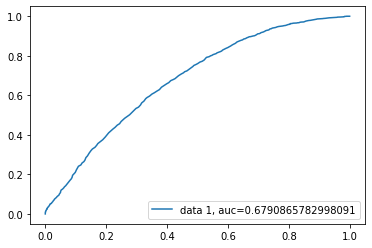

mass= 750
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=4, verbose=0,
                       warm_start=False)


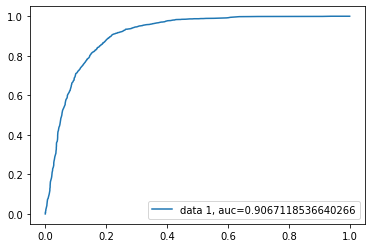

mass= 1000
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.3s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=4, verbose=0,
                       warm_start=False)


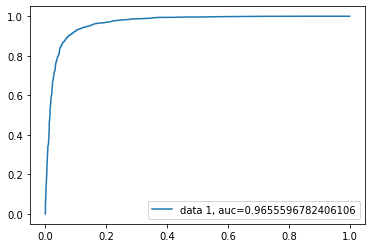

mass= 1250
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=4, verbose=0,
                       warm_start=False)


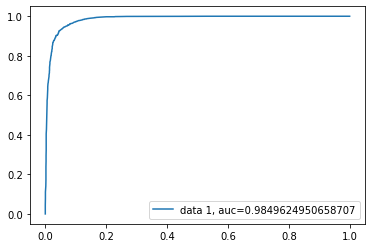

mass= 1500
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=4, verbose=0,
                       warm_start=False)


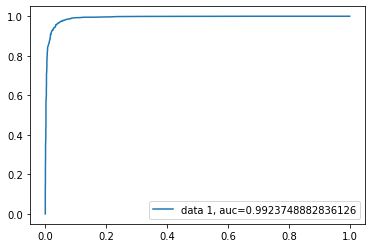

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1557  840  887  1366  0.628602   0.61922  0.606303  0.612693   
750   1895  371  409  1975  0.832258  0.841858   0.82844  0.835095   
1000  2119  177  231  2123  0.912258  0.923043  0.901869  0.912333   
1250  2246  123  154  2127   0.94043  0.945333  0.932486  0.938866   
1500  2233   78  111  2228  0.959355  0.966175  0.952544  0.959311   

     kappa_cohen       auc  
500     0.256025  0.679087  
750     0.664439  0.906712  
1000     0.82454   0.96556  
1250    0.880787  0.984962  
1500    0.918714  0.992375

BTAG = all2
mass= 500
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=4, verbose=0,
                       warm_start=False)


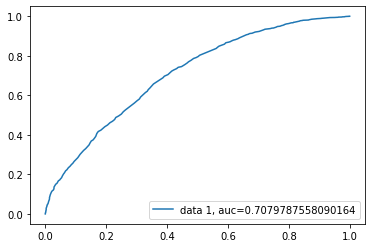

mass= 750
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=4, verbose=0,
                       warm_start=False)


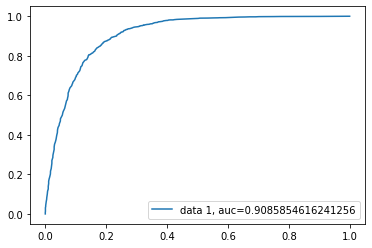

mass= 1000
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.3s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=4, verbose=0,
                       warm_start=False)


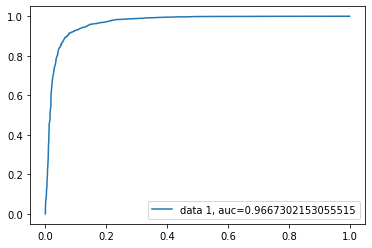

mass= 1250
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=4, verbose=0,
                       warm_start=False)


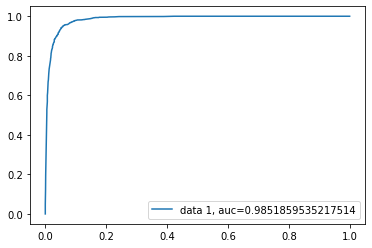

mass= 1500
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=4, verbose=0,
                       warm_start=False)


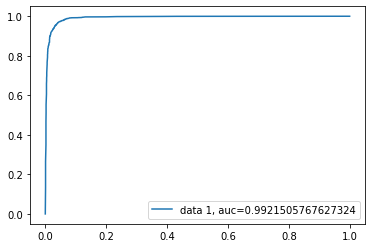

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1431  966  665  1588  0.649247   0.62177  0.704838  0.660703   
750   1781  485  268  2116  0.838065  0.813533  0.887584  0.848947   
1000  2038  258  149  2205  0.912473   0.89525  0.936703  0.915508   
1250  2227  142  109  2172  0.946022  0.938634  0.952214  0.945375   
1500  2206  105   66  2273  0.963226  0.955845  0.971783  0.963748   

     kappa_cohen       auc  
500     0.300628  0.707979  
750      0.67515  0.908585  
1000    0.824817   0.96673  
1250    0.892033  0.985186  
1500    0.926442  0.992151

BTAG = orig
mass= 500
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=4, verbose=0,
                       warm_start=False)


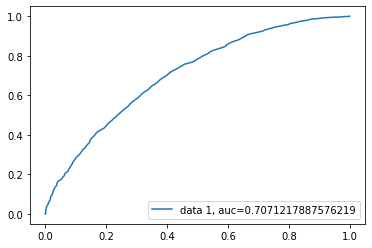

mass= 750
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=4, verbose=0,
                       warm_start=False)


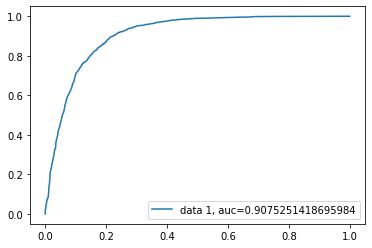

mass= 1000
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.2s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=4, verbose=0,
                       warm_start=False)


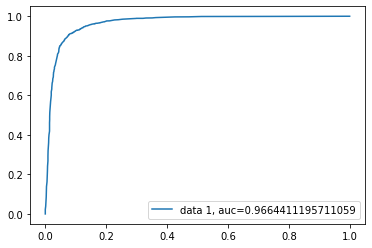

mass= 1250
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=4, verbose=0,
                       warm_start=False)


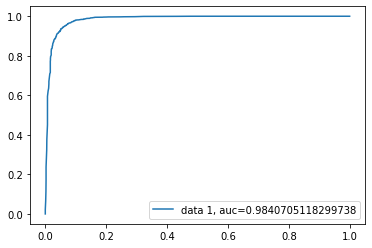

mass= 1500
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.2s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=4, verbose=0,
                       warm_start=False)


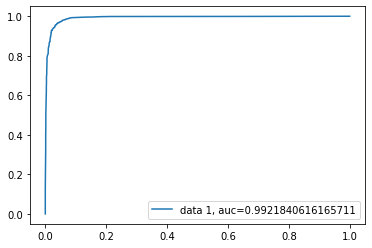

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1441  956  675  1578  0.649247  0.622731  0.700399  0.659286   
750   1799  467  282  2102  0.838925  0.818217  0.881711  0.848779   
1000  2067  229  173  2181  0.913548  0.904979  0.926508  0.915617   
1250  2229  140  125  2156  0.943011  0.939024  0.945199  0.942102   
1500  2221   90   87  2252  0.961935  0.961571  0.962805  0.962188   

     kappa_cohen       auc  
500     0.300442  0.707122  
750     0.676989  0.907525  
1000    0.827018  0.966441  
1250    0.885995  0.984071  
1500    0.923868  0.992184

BTAG = real
mass= 500
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=4, verbose=0,
                       warm_start=False)


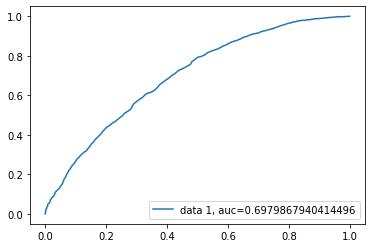

mass= 750
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.9s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=4, verbose=0,
                       warm_start=False)


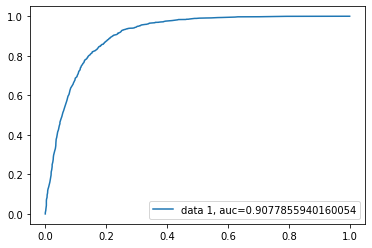

mass= 1000
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=4, verbose=0,
                       warm_start=False)


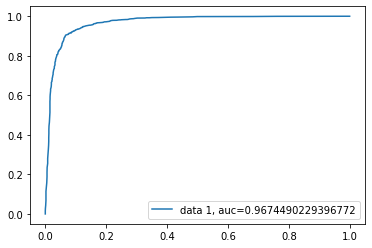

mass= 1250
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=4, verbose=0,
                       warm_start=False)


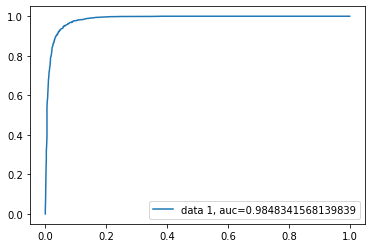

mass= 1500
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=4, verbose=0,
                       warm_start=False)


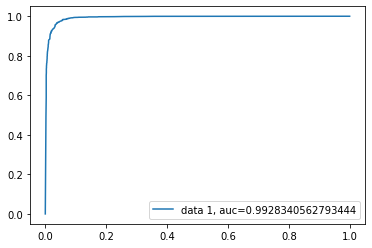

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1528  869  832  1421  0.634194  0.620524  0.630715  0.625578   
750   1820  446  310  2074  0.837419  0.823016  0.869966   0.84584   
1000  2064  232  161  2193  0.915484   0.90433  0.931606  0.917765   
1250  2241  128  144  2137  0.941505  0.943488   0.93687  0.940167   
1500  2226   85   90  2249  0.962366  0.963582  0.961522  0.962551   

     kappa_cohen       auc  
500     0.268046  0.697987  
750     0.674145  0.907786  
1000    0.830877  0.967449  
1250    0.882954  0.984834  
1500    0.924729  0.992834

BTAG = all0
mass= 500
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.9s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)


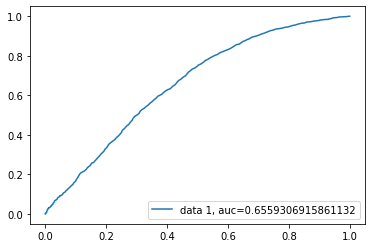

mass= 750
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)


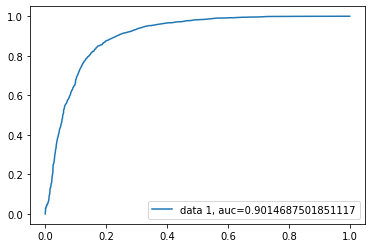

mass= 1000
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.3s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)


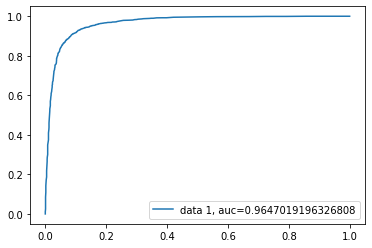

mass= 1250
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)


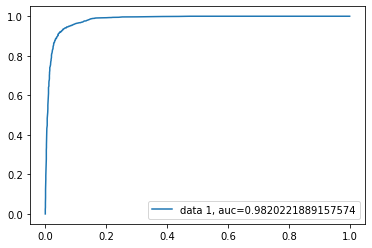

mass= 1500
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.2s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)


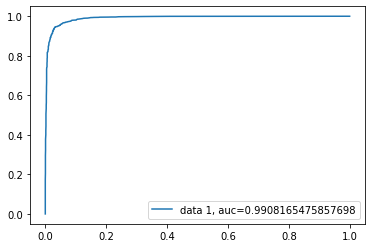

tn   fp    fn    tp       acc      prec    recall  F1_score  \
500   1976  421  1601   652  0.565161  0.607642  0.289392  0.392063   
750   2005  261   629  1755  0.808602  0.870536  0.736158  0.797727   
1000  2149  147   311  2043  0.901505  0.932877  0.867884  0.899208   
1250  2262  107   195  2086  0.935054  0.951208  0.914511  0.932499   
1500  2244   67   150  2189  0.953333  0.970301   0.93587  0.952775   

     kappa_cohen       auc  
500     0.115574  0.655931  
750     0.618491  0.901469  
1000    0.803153  0.964702  
1250    0.869968  0.982022  
1500    0.906683  0.990817

BTAG = all1
mass= 500
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)


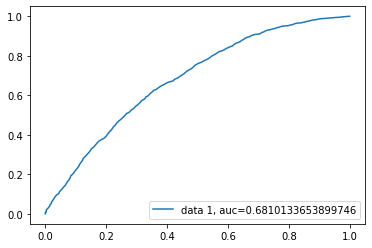

mass= 750
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)


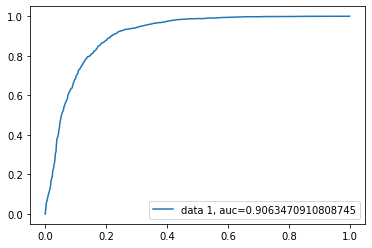

mass= 1000
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)


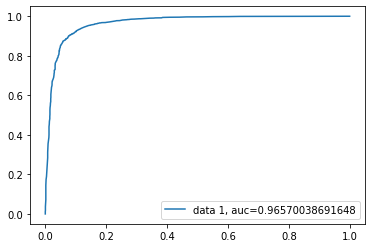

mass= 1250
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)


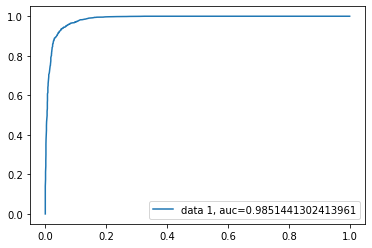

mass= 1500
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)


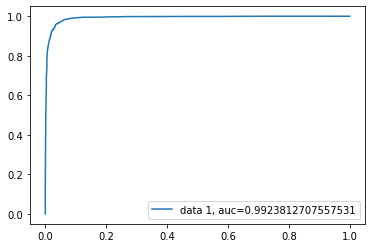

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1571  826  881  1372  0.632903  0.624204  0.608966  0.616491   
750   1896  370  416  1968  0.830968  0.841745  0.825503  0.833545   
1000  2119  177  233  2121  0.911828  0.922977   0.90102  0.911866   
1250  2248  121  155  2126  0.940645   0.94615  0.932047  0.939046   
1500  2235   76  107  2232  0.960645  0.967071  0.954254   0.96062   

     kappa_cohen       auc  
500     0.264562  0.681013  
750     0.661888  0.906347  
1000    0.823681    0.9657  
1250    0.881215  0.985144  
1500    0.921294  0.992381

BTAG = all2
mass= 500
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.9s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)


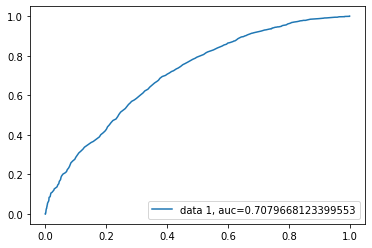

mass= 750
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)


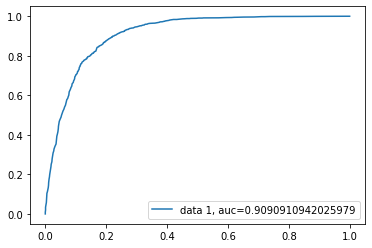

mass= 1000
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)


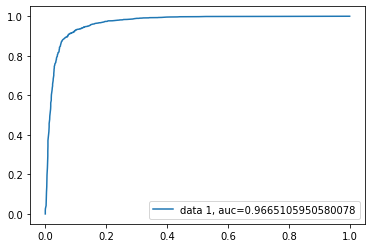

mass= 1250
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)


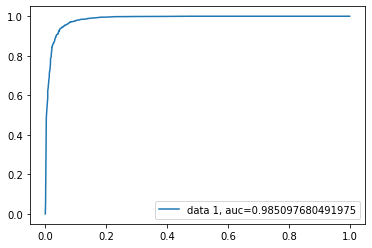

mass= 1500
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)


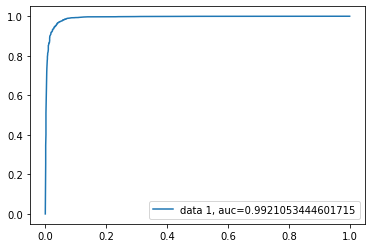

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1418  979  645  1608  0.650753  0.621569  0.713715  0.664463   
750   1782  484  263  2121  0.839355  0.814203  0.889681  0.850271   
1000  2036  260  151  2203  0.911613  0.894438  0.935854  0.914677   
1250  2226  143  114  2167  0.944731  0.938095  0.950022  0.944021   
1500  2207  104   68  2271  0.963011  0.956211  0.970928  0.963513   

     kappa_cohen       auc  
500     0.303934  0.707967  
750     0.677725  0.909091  
1000    0.823095  0.966511  
1250    0.889449  0.985098  
1500    0.926012  0.992105

BTAG = orig
mass= 500
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   34.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)


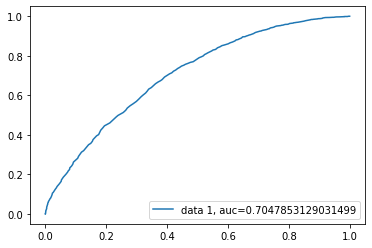

mass= 750
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)


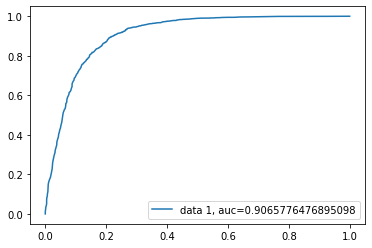

mass= 1000
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)


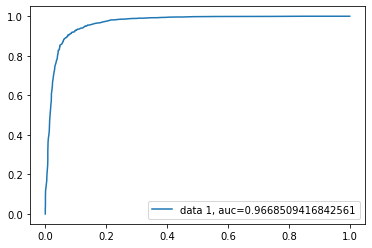

mass= 1250
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)


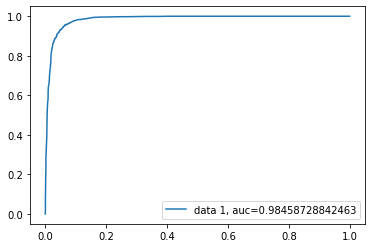

mass= 1500
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)


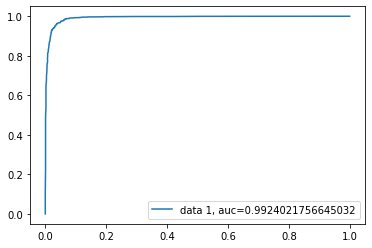

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1437  960  673  1580  0.648817  0.622047  0.701287  0.659295   
750   1798  468  276  2108      0.84  0.818323  0.884228      0.85   
1000  2070  226  170  2184  0.914839  0.906224  0.927782  0.916877   
1250  2230  139  124  2157  0.943441   0.93946  0.945638  0.942539   
1500  2219   92   85  2254  0.961935  0.960784   0.96366   0.96222   

     kappa_cohen       auc  
500      0.29964  0.704785  
750     0.679121  0.906578  
1000      0.8296  0.966851  
1250    0.886855  0.984587  
1500    0.923867  0.992402

BTAG = real
mass= 500
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)


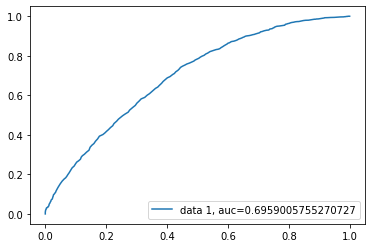

mass= 750
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)


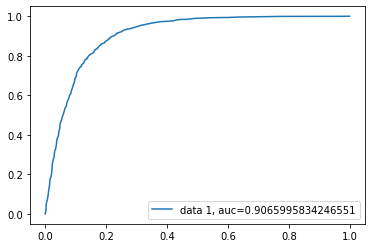

mass= 1000
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)


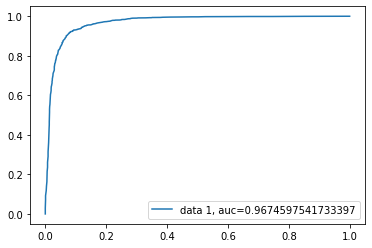

mass= 1250
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)


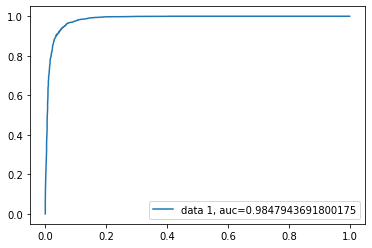

mass= 1500
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)


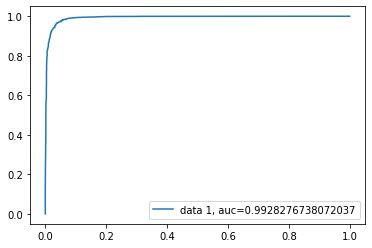

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1511  886  807  1446  0.635914  0.620069  0.641811  0.630752   
750   1821  445  312  2072  0.837204  0.823202  0.869128  0.845542   
1000  2063  233  160  2194  0.915484  0.903997  0.932031    0.9178   
1250  2243  126  144  2137  0.941935  0.944322   0.93687  0.940581   
1500  2226   85   87  2252  0.963011  0.963629  0.962805  0.963216   

     kappa_cohen       auc  
500     0.271896  0.695901  
750     0.673725    0.9066  
1000    0.830875   0.96746  
1250    0.883812  0.984794  
1500    0.926019  0.992828

BTAG = all0
mass= 500
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.2s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=6, verbose=0,
                       warm_start=False)


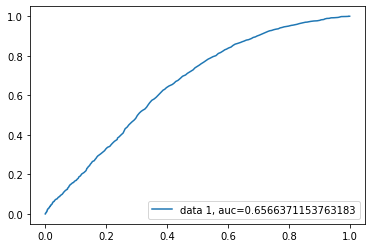

mass= 750
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=6, verbose=0,
                       warm_start=False)


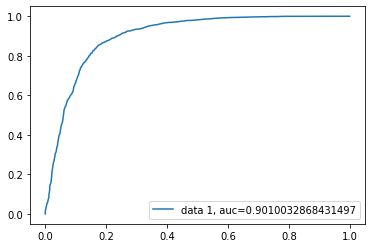

mass= 1000
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.3s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=6, verbose=0,
                       warm_start=False)


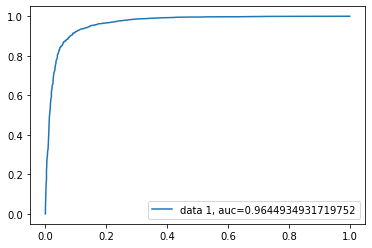

mass= 1250
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.9s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=6, verbose=0,
                       warm_start=False)


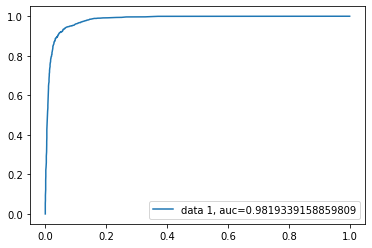

mass= 1500
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=6, verbose=0,
                       warm_start=False)


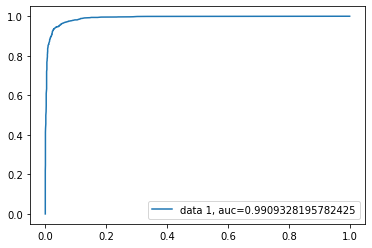

tn   fp    fn    tp       acc      prec    recall  F1_score  \
500   1992  405  1607   646  0.567312  0.614653  0.286729  0.391041   
750   2005  261   640  1744  0.806237  0.869825  0.731544  0.794714   
1000  2148  148   298  2056  0.904086  0.932849  0.873407   0.90215   
1250  2261  108   196  2085  0.934624  0.950752  0.914073  0.932052   
1500  2246   65   148  2191  0.954194  0.971188  0.936725  0.953645   

     kappa_cohen       auc  
500     0.119686  0.656637  
750     0.613822  0.901003  
1000    0.808296  0.964493  
1250    0.869107  0.981934  
1500    0.908403  0.990933

BTAG = all1
mass= 500
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=6, verbose=0,
                       warm_start=False)


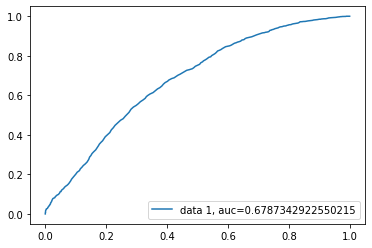

mass= 750
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.2s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=6, verbose=0,
                       warm_start=False)


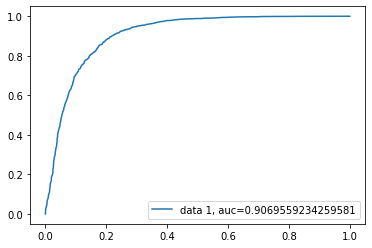

mass= 1000
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.9s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=6, verbose=0,
                       warm_start=False)


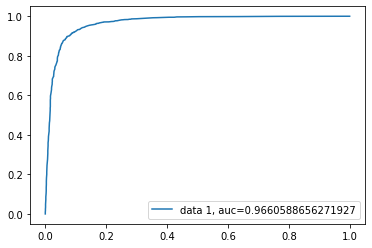

mass= 1250
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=6, verbose=0,
                       warm_start=False)


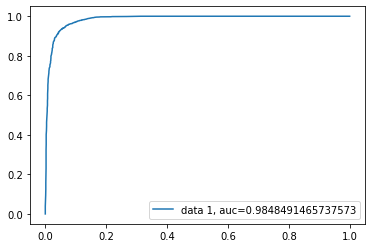

mass= 1500
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=6, verbose=0,
                       warm_start=False)


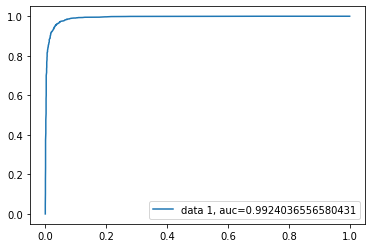

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1572  825  886  1367  0.632043  0.623631  0.606747  0.615073   
750   1892  374  418  1966  0.829677  0.840171  0.824664  0.832345   
1000  2115  181  234  2120  0.910753  0.921339  0.900595  0.910849   
1250  2250  119  159  2122  0.940215  0.946899  0.930294  0.938523   
1500  2235   76  109  2230  0.960215  0.967042  0.953399  0.960172   

     kappa_cohen       auc  
500      0.26278  0.678734  
750     0.659299  0.906956  
1000    0.821528  0.966059  
1250    0.880348  0.984849  
1500    0.920434  0.992404

BTAG = all2
mass= 500
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=6, verbose=0,
                       warm_start=False)


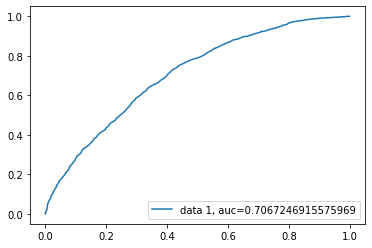

mass= 750
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=6, verbose=0,
                       warm_start=False)


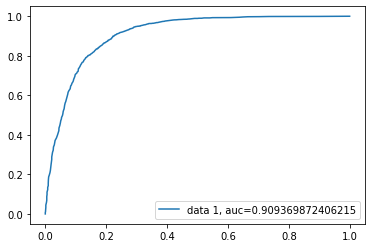

mass= 1000
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.2s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=6, verbose=0,
                       warm_start=False)


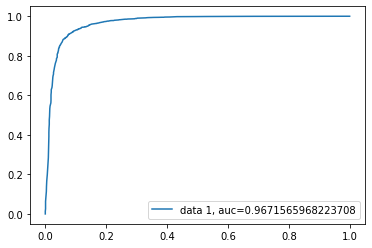

mass= 1250
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=6, verbose=0,
                       warm_start=False)


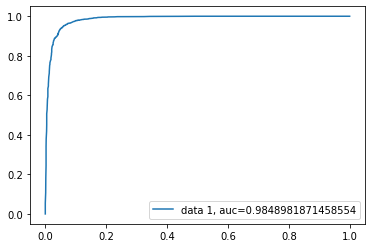

mass= 1500
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=6, verbose=0,
                       warm_start=False)


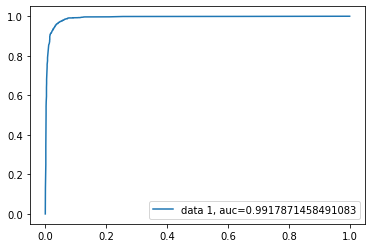

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1429  968  657  1596  0.650538  0.622465  0.708389  0.662653   
750   1773  493  266  2118  0.836774  0.811183  0.888423  0.848048   
1000  2036  260  146  2208  0.912688  0.894652  0.937978  0.915803   
1250  2227  142  115  2166  0.944731  0.938475  0.949584  0.943997   
1500  2209  102   73  2266  0.962366  0.956926   0.96879  0.962821   

     kappa_cohen       auc  
500     0.303293  0.706725  
750     0.672526   0.90937  
1000    0.825242  0.967157  
1250    0.889447  0.984898  
1500    0.924723  0.991787

BTAG = orig
mass= 500
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=6, verbose=0,
                       warm_start=False)


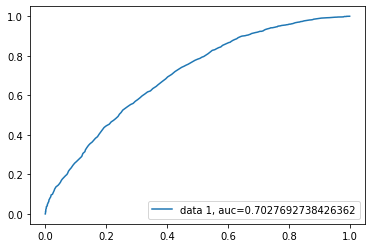

mass= 750
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=6, verbose=0,
                       warm_start=False)


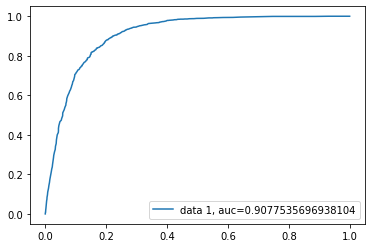

mass= 1000
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=6, verbose=0,
                       warm_start=False)


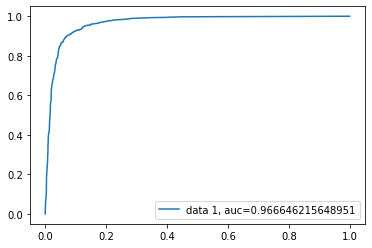

mass= 1250
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=6, verbose=0,
                       warm_start=False)


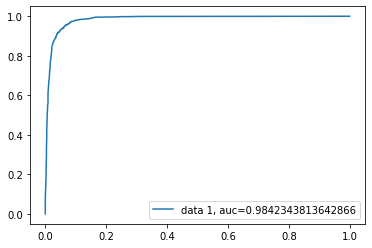

mass= 1500
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=6, verbose=0,
                       warm_start=False)


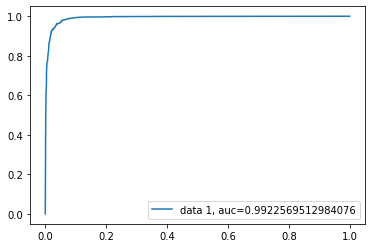

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1417  980  676  1577  0.643871  0.616738  0.699956  0.655717   
750   1798  468  279  2105  0.839355  0.818111   0.88297  0.849304   
1000  2067  229  173  2181  0.913548  0.904979  0.926508  0.915617   
1250  2225  144  131  2150   0.94086  0.937228  0.942569  0.939891   
1500  2219   92   89  2250  0.961075  0.960717   0.96195  0.961333   

     kappa_cohen       auc  
500     0.289936  0.702769  
750     0.677838  0.907754  
1000    0.827018  0.966646  
1250    0.881691  0.984234  
1500    0.922147  0.992257

BTAG = real
mass= 500
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=6, verbose=0,
                       warm_start=False)


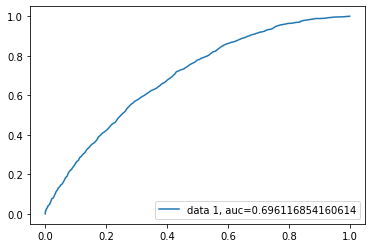

mass= 750
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.9s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=6, verbose=0,
                       warm_start=False)


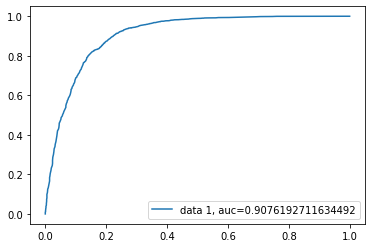

mass= 1000
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=6, verbose=0,
                       warm_start=False)


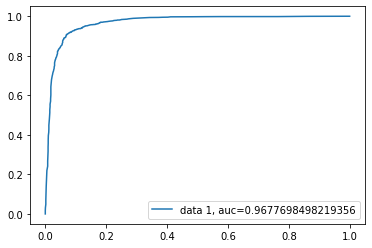

mass= 1250
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.9s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=6, verbose=0,
                       warm_start=False)


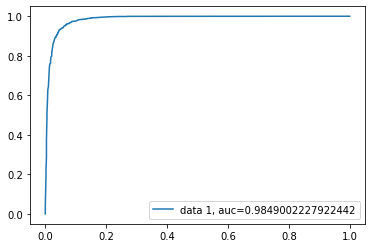

mass= 1500
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.3s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=6, verbose=0,
                       warm_start=False)


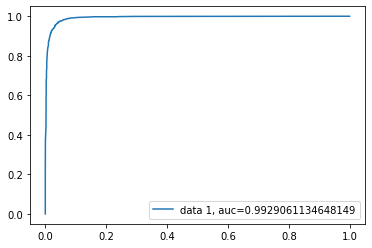

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1524  873  823  1430  0.635269  0.620929  0.634709  0.627744   
750   1822  444  315  2069  0.836774  0.823319  0.867869  0.845007   
1000  2063  233  160  2194  0.915484  0.903997  0.932031    0.9178   
1250  2244  125  143  2138  0.942366  0.944764  0.937308  0.941021   
1500  2222   89   86  2253  0.962366  0.961998  0.963232  0.962615   

     kappa_cohen       auc  
500     0.270324  0.696117  
750     0.672877  0.907619  
1000    0.830875   0.96777  
1250    0.884673    0.9849  
1500    0.924728  0.992906

BTAG = all0
mass= 500
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)


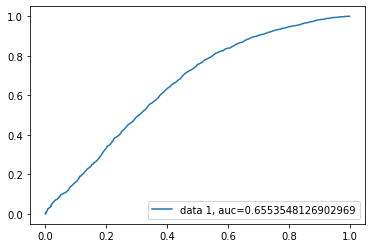

mass= 750
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.3s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)


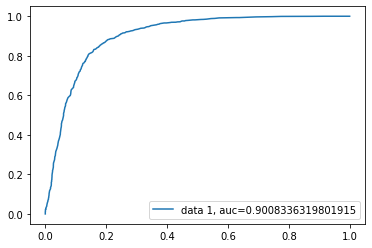

mass= 1000
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)


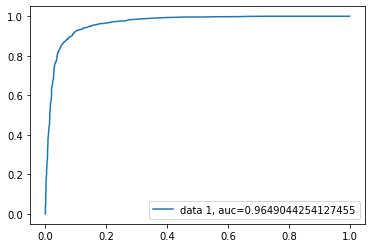

mass= 1250
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.3s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)


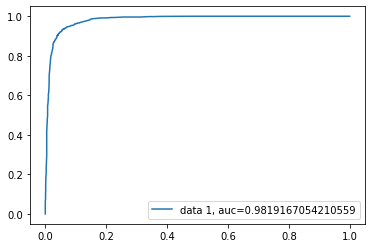

mass= 1500
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)


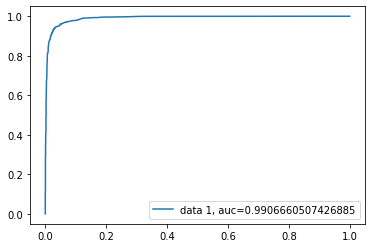

tn   fp    fn    tp       acc      prec    recall  F1_score  \
500   1967  430  1603   650  0.562796  0.601852  0.288504  0.390039   
750   2005  261   645  1739  0.805161    0.8695  0.729446  0.793339   
1000  2146  150   300  2054  0.903226  0.931942  0.872557  0.901272   
1250  2266  103   200  2081  0.934839  0.952839  0.912319  0.932139   
1500  2247   64   149  2190  0.954194  0.971606  0.936298  0.953625   

     kappa_cohen       auc  
500     0.110847  0.655355  
750       0.6117  0.900834  
1000    0.806577  0.964904  
1250    0.869528  0.981917  
1500    0.908404  0.990666

BTAG = all1
mass= 500
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)


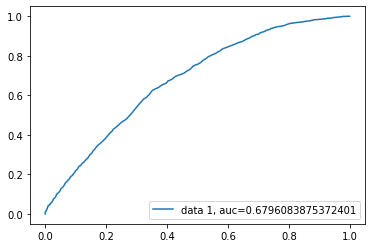

mass= 750
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)


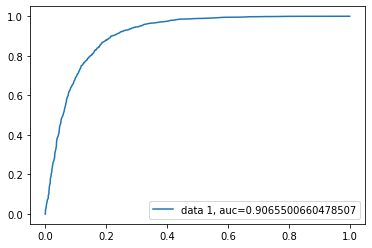

mass= 1000
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)


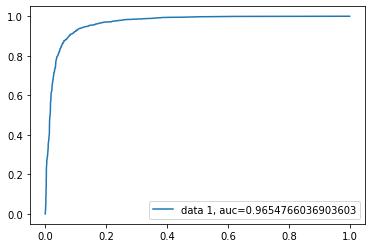

mass= 1250
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)


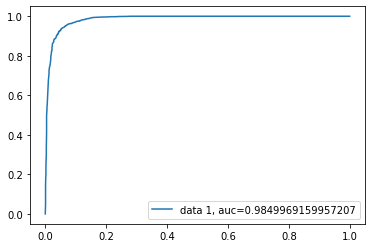

mass= 1500
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.3s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)


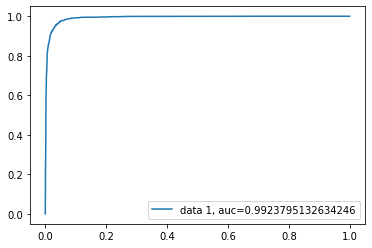

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1572  825  882  1371  0.632903  0.624317  0.608522  0.616318   
750   1896  370  413  1971  0.831613  0.841948  0.826762  0.834286   
1000  2120  176  240  2114  0.910538  0.923144  0.898046  0.910422   
1250  2249  120  159  2122      0.94  0.946476  0.930294  0.938315   
1500  2230   81  108  2231  0.959355  0.964965  0.953826  0.959364   

     kappa_cohen       auc  
500     0.264543  0.679608  
750     0.663167   0.90655  
1000    0.821109  0.965477  
1250    0.879919  0.984997  
1500    0.918712   0.99238

BTAG = all2
mass= 500
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)


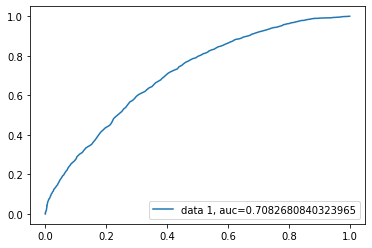

mass= 750
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)


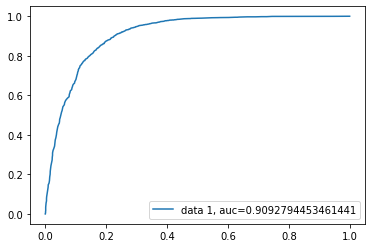

mass= 1000
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)


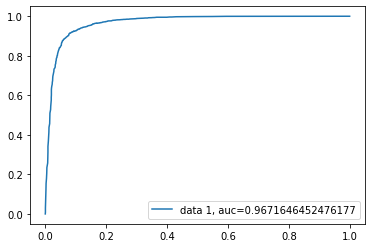

mass= 1250
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)


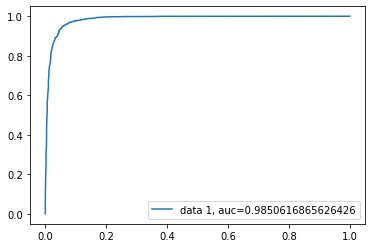

mass= 1500
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)


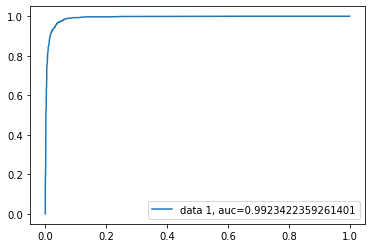

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1428  969  648  1605  0.652258  0.623543  0.712383  0.665009   
750   1779  487  270  2114  0.837204  0.812764  0.886745  0.848144   
1000  2037  259  150  2204  0.912043  0.894844  0.936279  0.915092   
1250  2225  144  112  2169  0.944946  0.937743  0.950899  0.944275   
1500  2206  105   67  2272  0.963011  0.955827  0.971355  0.963528   

     kappa_cohen       auc  
500     0.306815  0.708268  
750     0.673425  0.909279  
1000    0.823956  0.967165  
1250    0.889882  0.985062  
1500    0.926012  0.992342

BTAG = orig
mass= 500
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.3s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)


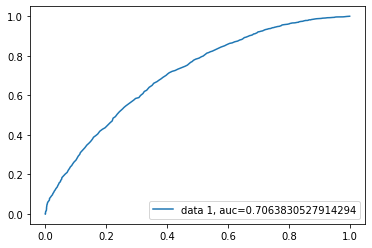

mass= 750
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)


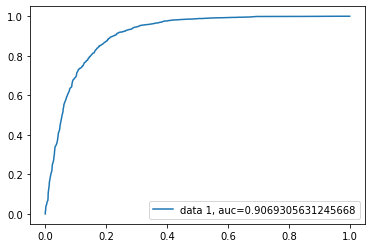

mass= 1000
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.2s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)


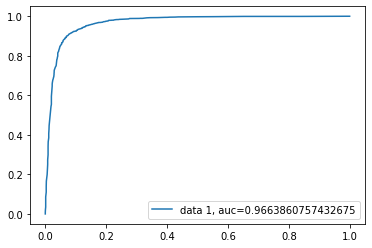

mass= 1250
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.2s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)


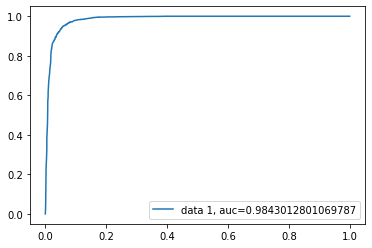

mass= 1500
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.9s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)


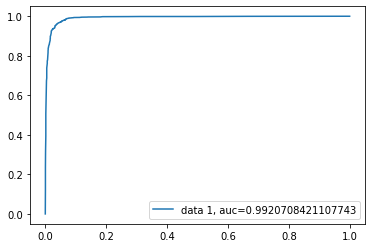

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1446  951  674  1579  0.650538  0.624111  0.700843  0.660255   
750   1798  468  278  2106   0.83957  0.818182  0.883389  0.849536   
1000  2062  234  174  2180  0.912258  0.903065  0.926083   0.91443   
1250  2235  134  123  2158  0.944731  0.941536  0.946076  0.943801   
1500  2218   93   85  2254   0.96172  0.960375   0.96366  0.962015   

     kappa_cohen       auc  
500     0.302978  0.706383  
750     0.678265  0.906931  
1000    0.824432  0.966386  
1250    0.889433  0.984301  
1500    0.923436  0.992071

BTAG = real
mass= 500
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)


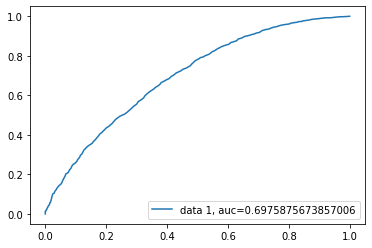

mass= 750
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.9s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)


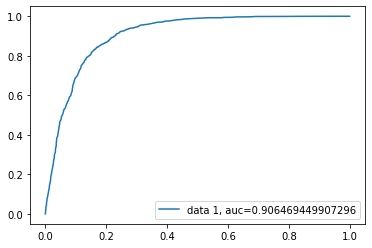

mass= 1000
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)


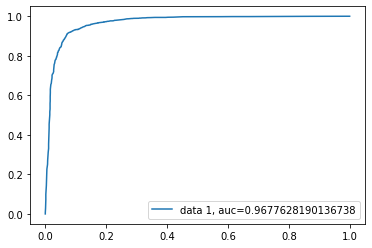

mass= 1250
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.3s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)


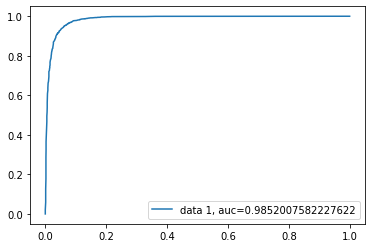

mass= 1500
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)


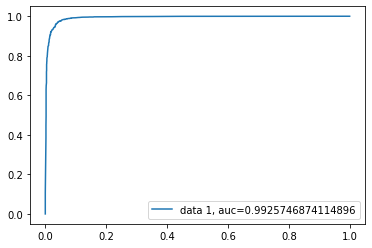

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1542  855  828  1425  0.638065     0.625   0.63249  0.628723   
750   1811  455  314  2070  0.834624  0.819802  0.868289  0.843349   
1000  2065  231  159  2195  0.916129  0.904782  0.932455   0.91841   
1250  2245  124  144  2137  0.942366  0.945157   0.93687  0.940995   
1500  2229   82   89  2250  0.963226  0.964837   0.96195  0.963391   

     kappa_cohen       auc  
500     0.275695  0.697588  
750     0.668524  0.906469  
1000    0.832167  0.967763  
1250    0.884671  0.985201  
1500     0.92645  0.992575

BTAG = all0
mass= 500
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)


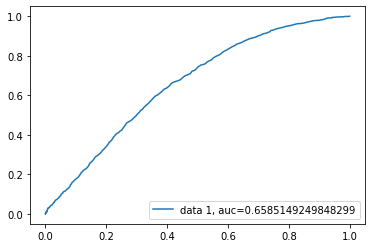

mass= 750
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)


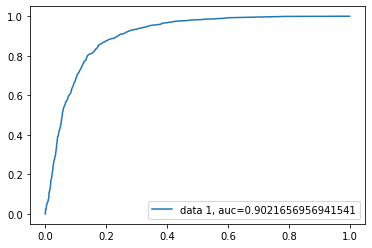

mass= 1000
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.9s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)


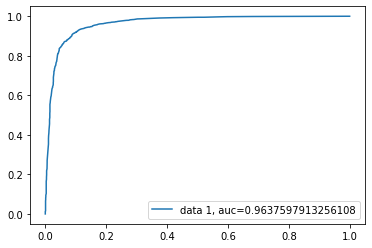

mass= 1250
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)


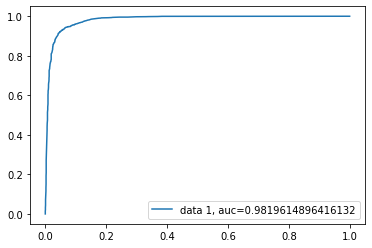

mass= 1500
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)


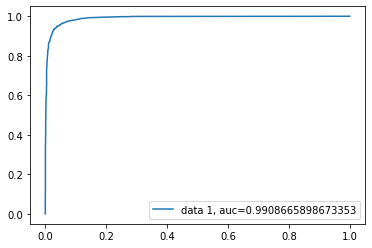

tn   fp    fn    tp       acc      prec    recall  F1_score  \
500   1980  417  1581   672  0.570323   0.61708  0.298269  0.402154   
750   2000  266   628  1756  0.807742  0.868447  0.736577  0.797095   
1000  2148  148   300  2054  0.903656  0.932788  0.872557  0.901668   
1250  2266  103   197  2084  0.935484  0.952904  0.913634  0.932856   
1500  2244   67   153  2186  0.952688  0.970262  0.934587  0.952091   

     kappa_cohen       auc  
500     0.126261  0.658515  
750     0.616751  0.902166  
1000    0.807439   0.96376  
1250    0.870823  0.981961  
1500    0.905394  0.990867

BTAG = all1
mass= 500
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)


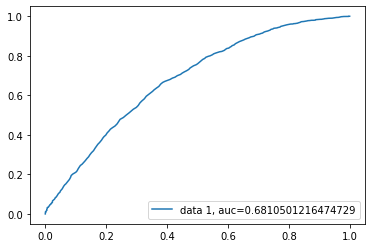

mass= 750
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)


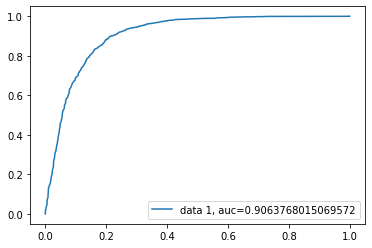

mass= 1000
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)


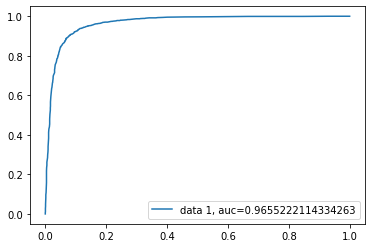

mass= 1250
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)


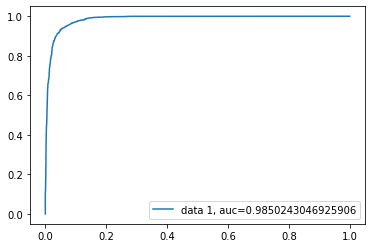

mass= 1500
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)


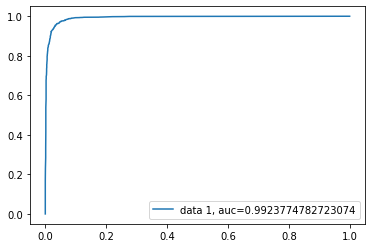

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1572  825  878  1375  0.633763     0.625  0.610297  0.617561   
750   1900  366  408  1976  0.833548  0.843723  0.828859  0.836225   
1000  2120  176  237  2117  0.911183  0.923245   0.89932  0.911125   
1250  2248  121  157  2124  0.940215  0.946102  0.931171  0.938577   
1500  2236   75  109  2230   0.96043  0.967462  0.953399  0.960379   

     kappa_cohen       auc  
500     0.266305   0.68105  
750     0.667035  0.906377  
1000    0.822396  0.965522  
1250    0.880352  0.985024  
1500    0.920864  0.992377

BTAG = all2
mass= 500
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)


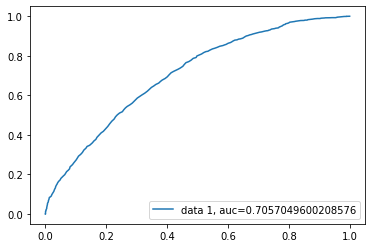

mass= 750
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)


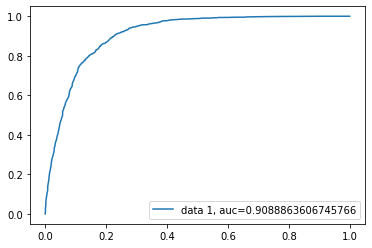

mass= 1000
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)


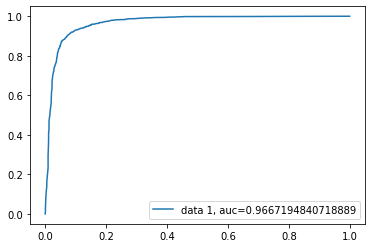

mass= 1250
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)


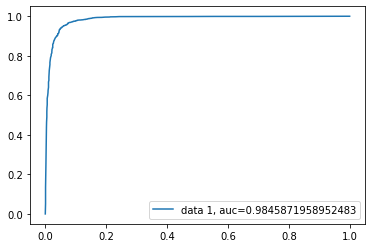

mass= 1500
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)


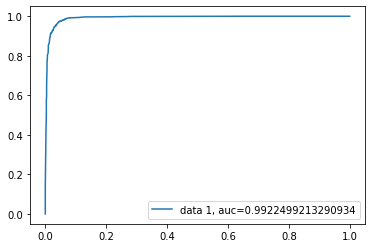

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1423  974  669  1584  0.646667  0.619234  0.703063  0.658491   
750   1776  490  262  2122   0.83828  0.812404  0.890101   0.84948   
1000  2033  263  146  2208  0.912043  0.893565  0.937978  0.915233   
1250  2231  138  118  2163  0.944946  0.940026  0.948268  0.944129   
1500  2209  102   67  2272  0.963656  0.957035  0.971355  0.964142   

     kappa_cohen       auc  
500      0.29552  0.705705  
750     0.675543  0.908886  
1000    0.823948  0.966719  
1250    0.889871  0.984587  
1500    0.927303   0.99225

BTAG = orig
mass= 500
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)


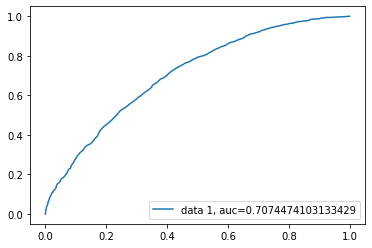

mass= 750
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)


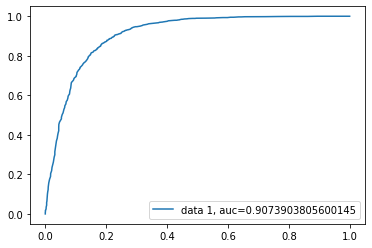

mass= 1000
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.2s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)


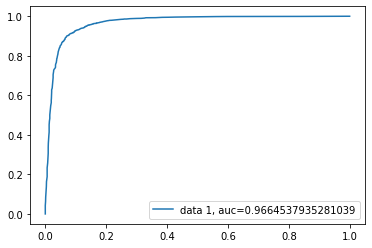

mass= 1250
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)


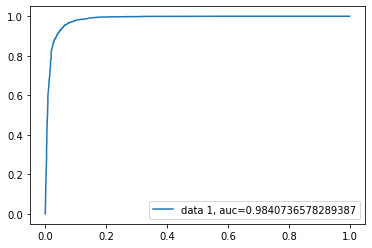

mass= 1500
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)


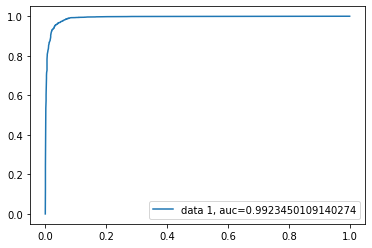

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1444  953  680  1573  0.648817  0.622724   0.69818  0.658297   
750   1794  472  281  2103  0.838065  0.816699  0.882131  0.848155   
1000  2069  227  172  2182  0.914194   0.90577  0.926933  0.916229   
1250  2229  140  127  2154  0.942581  0.938971  0.944323  0.941639   
1500  2217   94   89  2250  0.960645  0.959898   0.96195  0.960922   

     kappa_cohen       auc  
500      0.29951  0.707447  
750     0.675243   0.90739  
1000     0.82831  0.966454  
1250    0.885132  0.984074  
1500    0.921286  0.992345

BTAG = real
mass= 500
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.3s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)


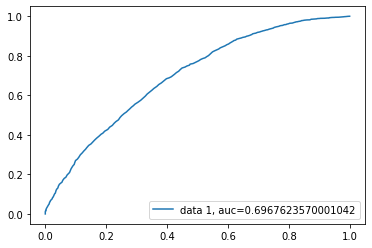

mass= 750
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)


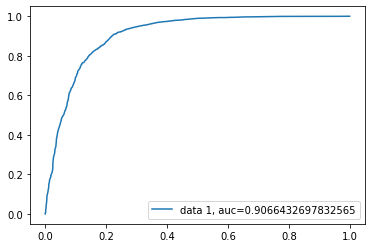

mass= 1000
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)


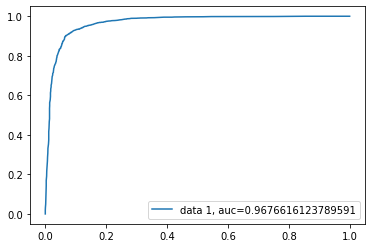

mass= 1250
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)


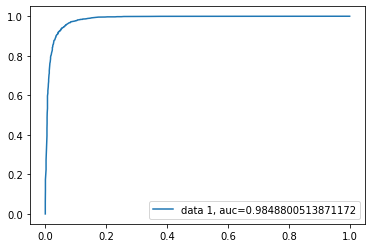

mass= 1500
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)


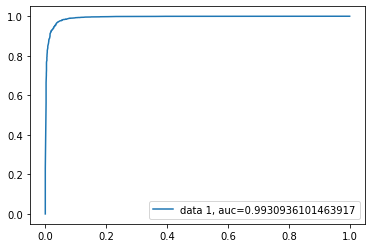

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1519  878  800  1453   0.63914  0.623338  0.644918  0.633944   
750   1814  452  309  2075  0.836344  0.821132  0.870386  0.845042   
1000  2062  234  159  2195  0.915484  0.903664  0.932455  0.917834   
1250  2245  124  145  2136  0.942151  0.945133  0.936431  0.940762   
1500  2228   83   87  2252  0.963441  0.964454  0.962805  0.963629   

     kappa_cohen       auc  
500     0.278337  0.696762  
750     0.671965  0.906643  
1000    0.830873  0.967662  
1250     0.88424   0.98488  
1500     0.92688  0.993094

BTAG = all0
mass= 500
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)


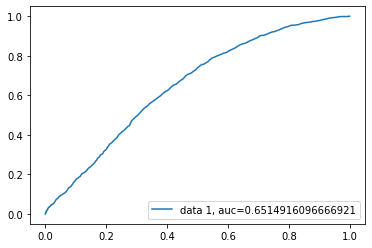

mass= 750
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.3s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)


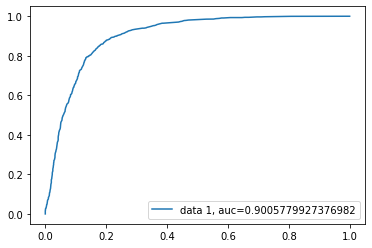

mass= 1000
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)


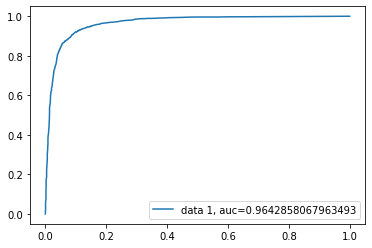

mass= 1250
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.9s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)


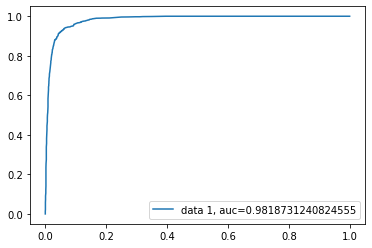

mass= 1500
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)


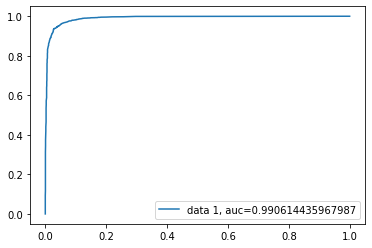

tn   fp    fn    tp       acc      prec    recall  F1_score  \
500   1971  426  1602   651  0.563871  0.604457  0.288948  0.390991   
750   2005  261   648  1736  0.804516  0.869304  0.728188  0.792513   
1000  2151  145   308  2046  0.902581   0.93382  0.869159   0.90033   
1250  2260  109   191  2090  0.935484  0.950432  0.916265  0.933036   
1500  2245   66   149  2190  0.953763  0.970745  0.936298   0.95321   

     kappa_cohen       auc  
500     0.112998  0.651492  
750     0.610427  0.900578  
1000    0.805301  0.964286  
1250    0.870835  0.981873  
1500    0.907543  0.990614

BTAG = all1
mass= 500
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)


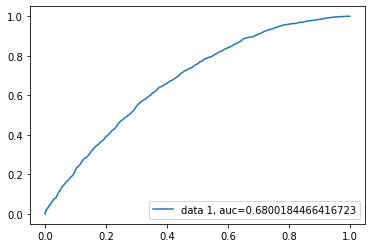

mass= 750
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.9s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)


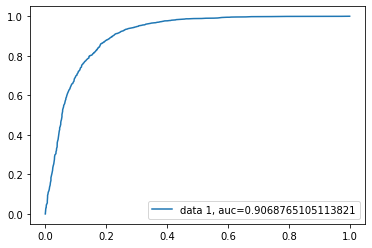

mass= 1000
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.9s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)


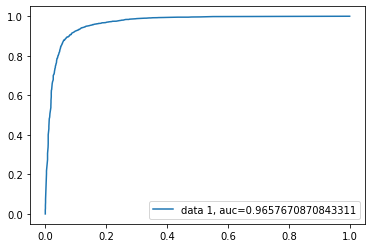

mass= 1250
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)


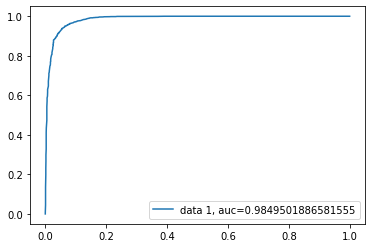

mass= 1500
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)


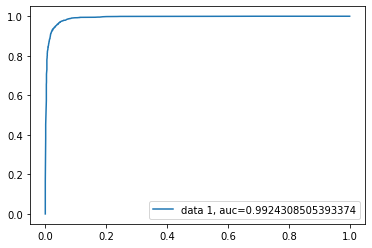

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1564  833  895  1358  0.628387  0.619808  0.602752  0.611161   
750   1886  380  408  1976  0.830538   0.83871  0.828859  0.833755   
1000  2116  180  235  2119  0.910753  0.921705   0.90017   0.91081   
1250  2245  124  157  2124   0.93957   0.94484  0.931171  0.937955   
1500  2229   82  112  2227   0.95828  0.964487  0.952116  0.958262   

     kappa_cohen       auc  
500     0.255445  0.680018  
750     0.660961  0.906877  
1000     0.82153  0.965767  
1250    0.879064   0.98495  
1500    0.916563  0.992431

BTAG = all2
mass= 500
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)


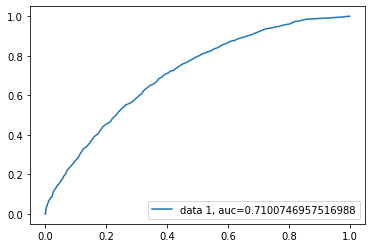

mass= 750
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)


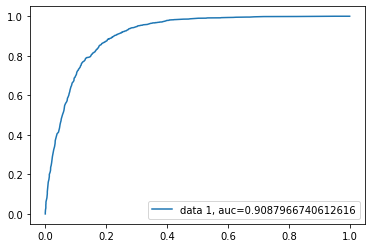

mass= 1000
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)


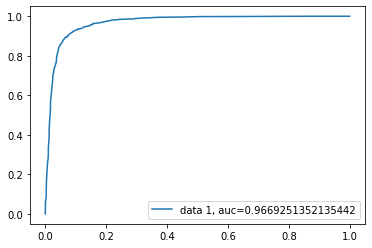

mass= 1250
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)


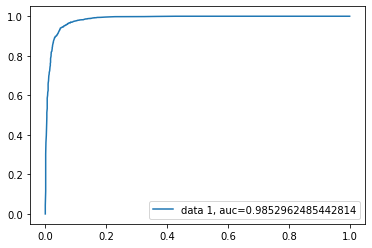

mass= 1500
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.9s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)


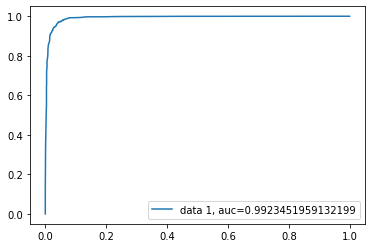

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1425  972  642  1611  0.652903  0.623693  0.715047  0.666253   
750   1779  487  264  2120  0.838495  0.813195  0.889262  0.849529   
1000  2041  255  150  2204  0.912903  0.896299  0.936279  0.915853   
1250  2225  144  113  2168  0.944731  0.937716   0.95046  0.944045   
1500  2205  106   69  2270  0.962366  0.955387    0.9705  0.962884   

     kappa_cohen       auc  
500     0.308184  0.710075  
750     0.675992  0.908797  
1000    0.825681  0.966925  
1250    0.889451  0.985296  
1500    0.924721  0.992345

BTAG = orig
mass= 500
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)


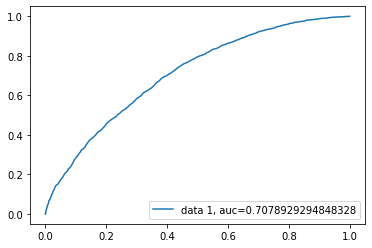

mass= 750
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)


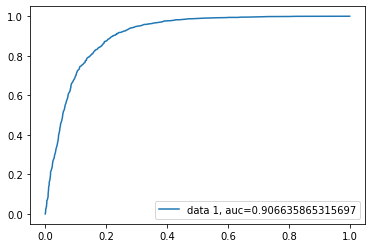

mass= 1000
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)


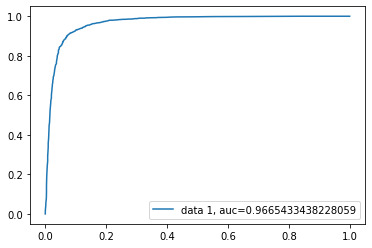

mass= 1250
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.2s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)


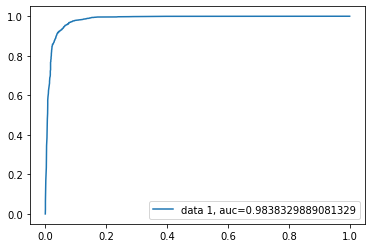

mass= 1500
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)


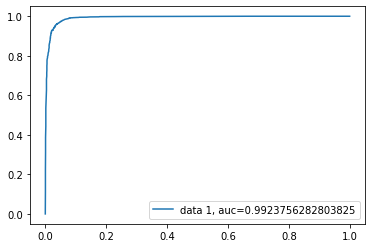

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1442  955  679  1574  0.648602   0.62238  0.698624  0.658302   
750   1796  470  276  2108   0.83957  0.817688  0.884228  0.849657   
1000  2067  229  167  2187  0.914839  0.905215  0.929057  0.916981   
1250  2228  141  133  2148  0.941075  0.938401  0.941692  0.940044   
1500  2218   93   90  2249  0.960645   0.96029  0.961522  0.960906   

     kappa_cohen       auc  
500     0.299109  0.707893  
750     0.678251  0.906636  
1000    0.829594  0.966543  
1250    0.882116  0.983833  
1500    0.921287  0.992376

BTAG = real
mass= 500
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)


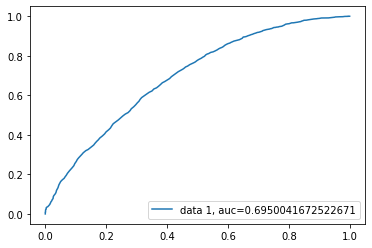

mass= 750
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)


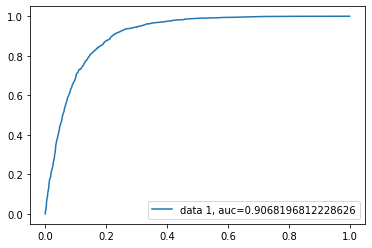

mass= 1000
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.9s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)


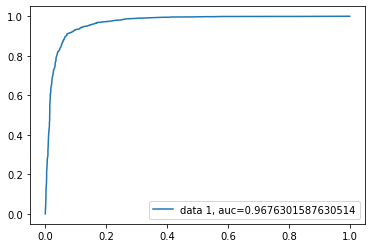

mass= 1250
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.9s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)


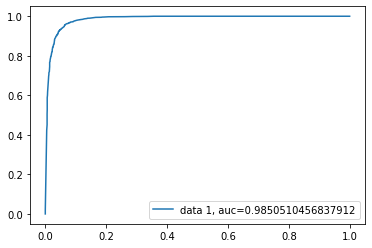

mass= 1500
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)


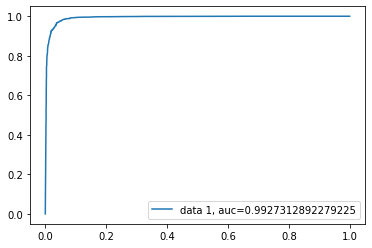

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1521  876  816  1437  0.636129  0.621271  0.637816  0.629435   
750   1819  447  304  2080  0.838495   0.82311  0.872483  0.847078   
1000  2070  226  161  2193  0.916774  0.906573  0.931606  0.918919   
1250  2244  125  146  2135   0.94172   0.94469  0.935993  0.940322   
1500  2227   84   90  2249  0.962581  0.963995  0.961522  0.962757   

     kappa_cohen       auc  
500     0.272142  0.695004  
750     0.676276   0.90682  
1000    0.833464   0.96763  
1250    0.883379  0.985051  
1500     0.92516  0.992731

<Figure size 432x288 with 0 Axes>

In [13]:
all0=[]
all1=[]
all2=[]
orig=[]
real=[]

rs=0

    
for rssem in range(10):
    
    for btag in ["all0","all1","all2","orig","real",]:

        df_metrics = pd.DataFrame(index=[500,750,1000,1250,1500], columns=["tn", "fp", "fn", "tp", "acc", "prec","recall",
                                                                       "F1_score","kappa_cohen","auc"])
        print("BTAG =", btag)

        df_btag=df.copy()

        if btag=="all0":
            df_btag=df_btag[df_btag.loc[:,['jet1_btag','jet2_btag',"jet3_btag","jet4_btag"]].sum(axis=1)==0]
        elif btag=="all1":
            df_btag=df_btag[df_btag.loc[:,['jet1_btag','jet2_btag',"jet3_btag","jet4_btag"]].sum(axis=1)==1]
            df_btag=df_btag.sample(df_btag.shape[0], random_state=rs).reset_index(drop=True)
        elif btag=="all2":                          
            df_btag=df_btag[df_btag.loc[:,['jet1_btag','jet2_btag',"jet3_btag","jet4_btag"]].sum(axis=1)==2]
            df_btag=df_btag.sample(df_btag.shape[0], random_state=rs).reset_index(drop=True)

        elif btag=="orig":                          
            df_btag=df_btag.sample(df_btag.shape[0], random_state=rs).reset_index(drop=True)

        elif btag=="real": #65,33,2
            df0=df_btag[df_btag.loc[:,['jet1_btag','jet2_btag',"jet3_btag","jet4_btag"]].sum(axis=1)==0]
            df1=df_btag[df_btag.loc[:,['jet1_btag','jet2_btag',"jet3_btag","jet4_btag"]].sum(axis=1)==1].sample(n=int(df0.shape[0]*(33/2)), random_state=6, replace=False)
            df2=df_btag[df_btag.loc[:,['jet1_btag','jet2_btag',"jet3_btag","jet4_btag"]].sum(axis=1)==2].sample(n=int(df0.shape[0]*(65/2)), random_state=6, replace=False)
            frames = [df1, df2, df0]
            df_btag = pd.concat(frames)
            df_btag=df_btag.sample(df_btag.shape[0], random_state=rs).reset_index(drop=True)


        for i in (500,750,1000,1250,1500):

            print('mass=', i )

            dfmass1000=df_btag.loc[df_btag['mass'] == i]
            dfmass0=df_btag.loc[df_btag['mass'] == 0].sample(n=dfmass1000.shape[0], random_state=rs, replace=False)        #0 same size of dfmass1000
            dfmass1000=pd.concat([dfmass1000, dfmass0]).sample(frac=1).reset_index(drop=True)    #concatenating and shuffling
            dfmass1000=dfmass1000.drop('mass', axis=1) 

            #test
            #Siempre el mismo test: !!!
            dfmass1000test=df_originaltest.loc[df_originaltest['mass'] == i]
            dfmass0test=df_originaltest.loc[df_originaltest['mass'] == 0].sample(random_state=0,n=dfmass1000test.shape[0])
            np.random.seed(0)
            dfmass1000test=pd.concat([dfmass1000test, dfmass0test]).sample(frac=1).reset_index(drop=True)
            dfmass1000test=dfmass1000test.drop('mass', axis=1)
            np.random.seed(rs)
            dfmass1000=dfmass1000.sample(n=9300, random_state=rs)
            dfmass1000test=dfmass1000test.sample(n=4650, random_state=0)



            print("B_tag_train_prop", "\n" ,df_btag.loc[:,['jet1_btag','jet2_btag',"jet3_btag","jet4_btag"]].sum(axis=1).value_counts()/df_btag.shape[0]*100)


            drop=['lep_eta', 'lep_phi',  'met_phi', 'jets_no', 'jet1_eta', 'jet1_phi', 'jet1_btag', 
               'jet2_eta', 'jet2_phi', 'jet2_btag',  'jet3_eta', 'jet3_phi',
               'jet3_btag', 'jet4_eta', 'jet4_phi', 'jet4_btag']

            X_train=dfmass1000.drop(['label'], axis=1)
            X_train=X_train.drop(drop, axis=1)
            y_train=dfmass1000.label

            X_test=dfmass1000test.drop(['label'], axis=1)
            X_test=X_test.drop(drop, axis=1)
            y_test=dfmass1000test.label

            print("X_train_shape",X_train.shape)
            print("X_test_shape",X_test.shape)




            grid,best_model,y_pred,y_pred_proba = model(X_train,y_train,X_test,rssem)
            print(best_model)


        #Roc curve construction

            fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
            auc = metrics.roc_auc_score(y_test, y_pred_proba)
            plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
            plt.legend(loc=4)
            #plt.savefig(cwd2+'MASS=' + str(i) + 'ROC.png')
            plt.show()
            plt.clf() 

        #METRICS 

            tn, fp, fn, tp, acc, prec,recall, F1_score,kappa_cohen=Scores(y_test,y_pred)

            df_metrics.tn[i]=tn
            df_metrics.fp[i]=fp
            df_metrics.fn[i]=fn
            df_metrics.tp[i]=tp
            df_metrics.acc[i]=acc
            df_metrics.prec[i]=prec
            df_metrics.recall[i]=recall
            df_metrics.F1_score[i]=F1_score
            df_metrics.kappa_cohen[i]=kappa_cohen
            df_metrics.auc[i]=auc


        display(df_metrics)
        eval(btag).append(df_metrics)


In [14]:
l=[all0,all1,all2,orig,real]

with open("RF_traincte_semvar.txt", "wb") as fp:   #Pickling
    pickle.dump(l, fp)
    
with open("RF_traincte_semvar.txt", "rb") as fp:   # Unpickling
    b = pickle.load(fp)

In [16]:
with open("RF_traincte_semvar.txt", "rb") as fp:   # Unpickling
    b = pickle.load(fp)

In [20]:
dfall0=pd.DataFrame()
dfall1=pd.DataFrame()
dfall2=pd.DataFrame()
orig=pd.DataFrame()
real=pd.DataFrame()

ldf=[dfall0,dfall1,dfall2,orig,real]

ldfmean=ldf.copy()
ldfstd=ldf.copy()



for j in range (5):
    ldf[j]=b[j][0]
    for i in range(len(b[j])):
        if i!=0:
            ldf[j] = pd.concat([ldf[j], b[j][i]]).apply(pd.to_numeric)
            
    ldfmean[j]=ldf[j].groupby(level=0).mean() 
    ldfstd[j]=ldf[j].groupby(level=0).std()        

In [21]:
ldfmean

[          tn     fp      fn      tp       acc      prec    recall  F1_score  \
 500   1933.7  463.3  1540.5   712.5  0.569075  0.605972  0.316245  0.415578   
 750   2003.9  262.1   631.6  1752.4  0.807806  0.869894  0.735067  0.796814   
 1000  2143.0  153.0   301.3  2052.7  0.902301  0.930636  0.872005  0.900365   
 1250  2256.7  112.3   194.5  2086.5  0.934022  0.948927  0.914730  0.931515   
 1500  2236.6   74.4   152.6  2186.4  0.951183  0.967092  0.934758  0.950650   
 
       kappa_cohen       auc  
 500      0.124753  0.652338  
 750      0.616911  0.897787  
 1000     0.804727  0.963107  
 1250     0.867907  0.981774  
 1500     0.902382  0.990084  ,
           tn     fp     fn      tp       acc      prec    recall  F1_score  \
 500   1575.2  821.8  943.6  1309.4  0.620344  0.614401  0.581181  0.597315   
 750   1901.4  364.6  424.8  1959.2  0.830237  0.843103  0.821812  0.832321   
 1000  2114.9  181.1  239.5  2114.5  0.909548  0.921112  0.898258  0.909541   
 1250  2248.3  

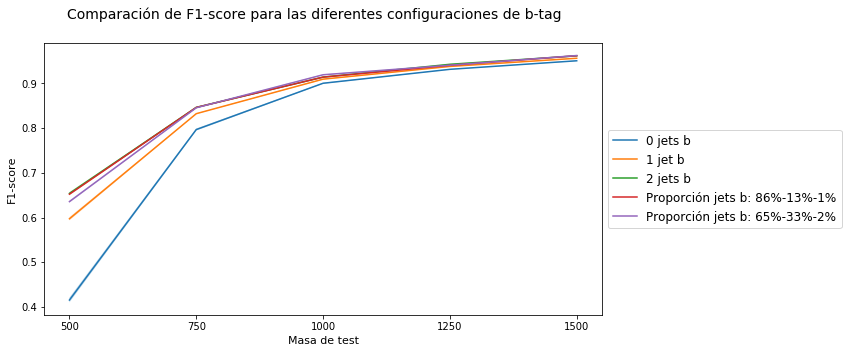

In [15]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(["500","750","1000","1250","1500"], ldfmean[0].F1_score, label="0 jets b")
ax.plot(["500","750","1000","1250","1500"], ldfmean[1].F1_score, label="1 jet b")
ax.plot(["500","750","1000","1250","1500"], ldfmean[2].F1_score, label="2 jets b")
ax.plot(["500","750","1000","1250","1500"], ldfmean[3].F1_score, label="Proporción jets b: 86%-13%-1%")
ax.plot(["500","750","1000","1250","1500"], ldfmean[4].F1_score, label="Proporción jets b: 65%-33%-2%")

ax.fill_between(["500","750","1000","1250","1500"], ldfmean[0].F1_score - ldfstd[0].F1_score, ldfmean[0].F1_score + ldfstd[0].F1_score, alpha=0.3)
ax.fill_between(["500","750","1000","1250","1500"], ldfmean[1].F1_score - ldfstd[1].F1_score, ldfmean[1].F1_score + ldfstd[1].F1_score, alpha=0.3)
ax.fill_between(["500","750","1000","1250","1500"], ldfmean[2].F1_score - ldfstd[2].F1_score, ldfmean[2].F1_score + ldfstd[2].F1_score, alpha=0.3)
ax.fill_between(["500","750","1000","1250","1500"], ldfmean[3].F1_score - ldfstd[3].F1_score, ldfmean[3].F1_score + ldfstd[3].F1_score, alpha=0.3)
ax.fill_between(["500","750","1000","1250","1500"], ldfmean[4].F1_score - ldfstd[4].F1_score, ldfmean[4].F1_score + ldfstd[4].F1_score, alpha=0.3)



ax.set_xlabel('Masa de test', fontsize=11)
ax.set_ylabel('F1-score', fontsize=11)
ax.legend(fontsize='large',loc='center left', bbox_to_anchor=(1, 0.5))
fig.suptitle('Comparación de F1-score para las diferentes configuraciones de b-tag' , fontsize=14)
plt.show()

 ## Test constante, train variable, semilla variable



BTAG = all0
mass= 500
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.2s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


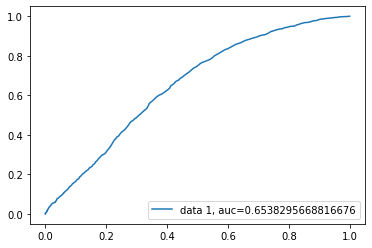

mass= 750
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.3s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


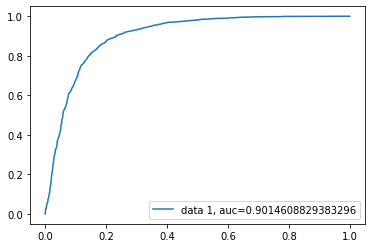

mass= 1000
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


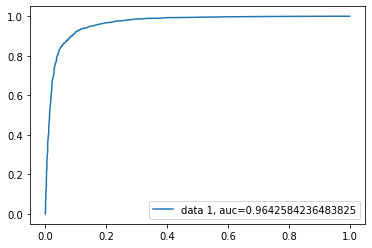

mass= 1250
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


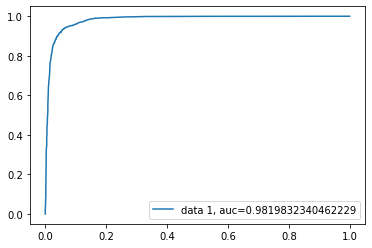

mass= 1500
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


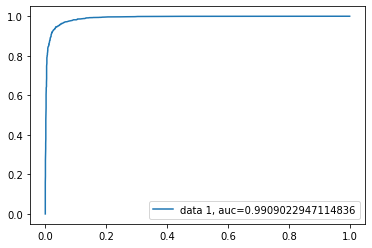

tn   fp    fn    tp       acc      prec    recall  F1_score  \
500   1954  443  1587   666  0.563441  0.600541  0.295606  0.396193   
750   2015  251   651  1733  0.806022  0.873488   0.72693  0.793498   
1000  2142  154   306  2048  0.901075  0.930064  0.870008  0.899034   
1250  2264  105   203  2078  0.933763  0.951901  0.911004  0.931004   
1500  2244   67   159  2180  0.951398  0.970182  0.932022   0.95072   

     kappa_cohen       auc  
500     0.112507   0.65383  
750     0.613482  0.901461  
1000    0.802281  0.964258  
1250    0.867374  0.981983  
1500    0.902815  0.990902

BTAG = all1
mass= 500
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.9s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


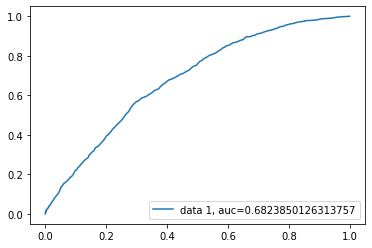

mass= 750
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


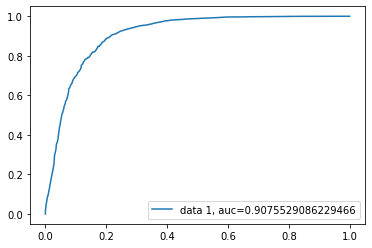

mass= 1000
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


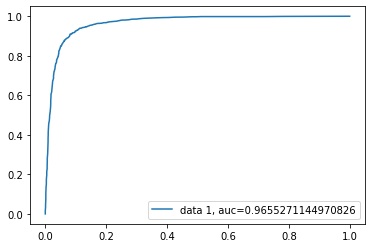

mass= 1250
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.3s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


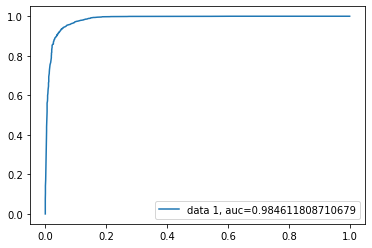

mass= 1500
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


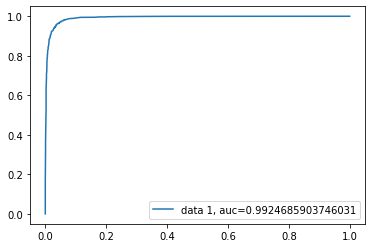

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1559  838  874  1379  0.631828  0.622012  0.612073  0.617002   
750   1891  375  414  1970  0.830323  0.840085  0.826342  0.833157   
1000  2115  181  241  2113  0.909247  0.921099  0.897621  0.909208   
1250  2247  122  157  2124      0.94  0.945681  0.931171   0.93837   
1500  2230   81  110  2229  0.958925  0.964935  0.952971  0.958916   

     kappa_cohen       auc  
500     0.262595  0.682385  
750     0.660571  0.907553  
1000    0.818525  0.965527  
1250    0.879923  0.984612  
1500    0.917853  0.992469

BTAG = all2
mass= 500
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


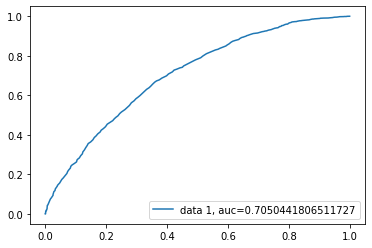

mass= 750
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


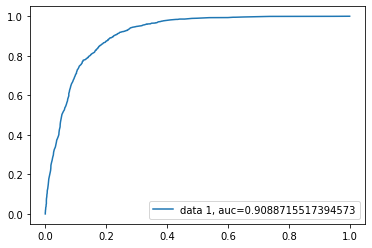

mass= 1000
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.9s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


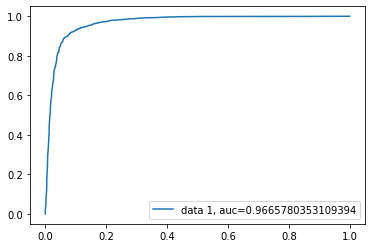

mass= 1250
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


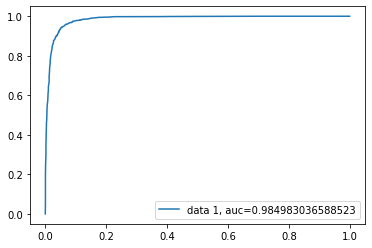

mass= 1500
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


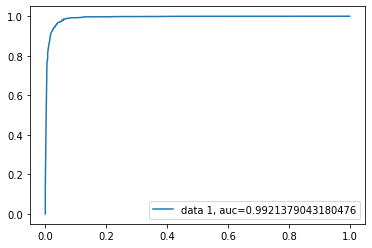

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1427  970  658  1595  0.649892  0.621832  0.707945    0.6621   
750   1787  479  266  2118  0.839785  0.815556  0.888423  0.850432   
1000  2041  255  149  2205  0.913118  0.896341  0.936703  0.916078   
1250  2224  145  114  2167  0.944301  0.937284  0.950022   0.94361   
1500  2204  107   71  2268   0.96172  0.954947  0.969645   0.96224   

     kappa_cohen       auc  
500     0.302016  0.705044  
750     0.678616  0.908872  
1000    0.826111  0.966578  
1250     0.88859  0.984983  
1500    0.923431  0.992138

BTAG = orig
mass= 500
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


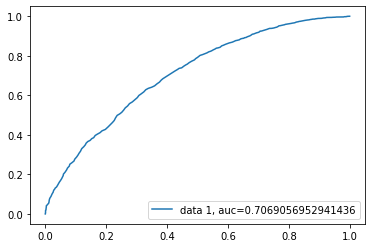

mass= 750
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


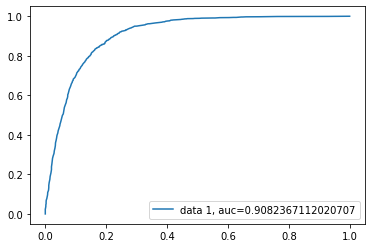

mass= 1000
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


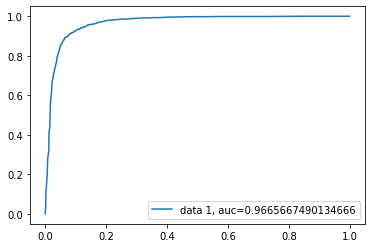

mass= 1250
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.9s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


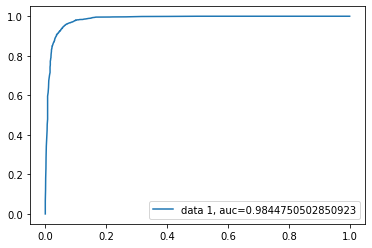

mass= 1500
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


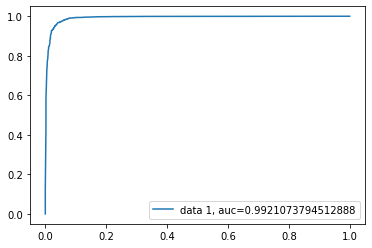

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1434  963  677  1576  0.647312  0.620717  0.699512  0.657763   
750   1801  465  289  2095  0.837849  0.818359  0.878775  0.847492   
1000  2065  231  172  2182  0.913333  0.904269  0.926933   0.91546   
1250  2234  135  129  2152  0.943226  0.940971  0.943446  0.942207   
1500  2221   90   88  2251   0.96172  0.961555  0.962377  0.961966   

     kappa_cohen       auc  
500     0.296629  0.706906  
750     0.674865  0.908237  
1000    0.826585  0.966567  
1250    0.886416  0.984475  
1500    0.923438  0.992107

BTAG = real
mass= 500
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.3s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


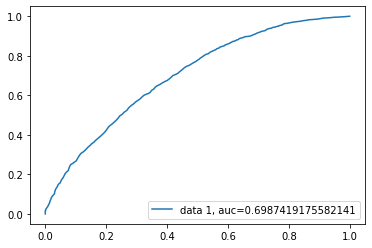

mass= 750
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.2s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


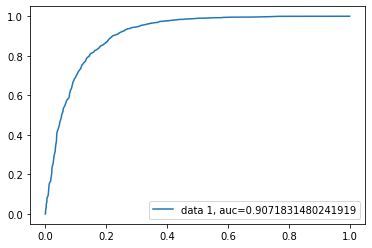

mass= 1000
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


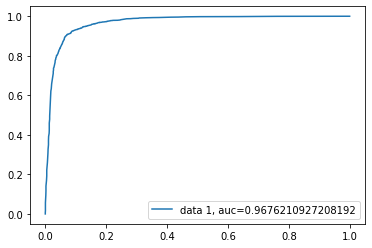

mass= 1250
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.2s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


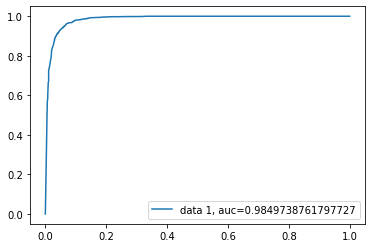

mass= 1500
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


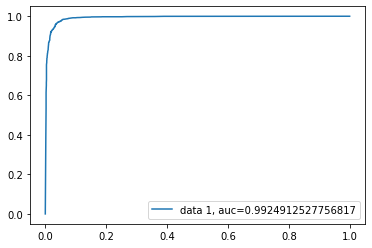

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1542  855  829  1424  0.637849  0.624835  0.632046   0.62842   
750   1811  455  311  2073  0.835269  0.820016  0.869547  0.844055   
1000  2064  232  160  2194  0.915699  0.904369  0.932031  0.917992   
1250  2243  126  143  2138  0.942151  0.944346  0.937308  0.940814   
1500  2227   84   86  2253  0.963441  0.964056  0.963232  0.963644   

     kappa_cohen       auc  
500     0.275255  0.698742  
750     0.669806  0.907183  
1000    0.831306  0.967621  
1250    0.884244  0.984974  
1500    0.926879  0.992491

BTAG = all0
mass= 500
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.9s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


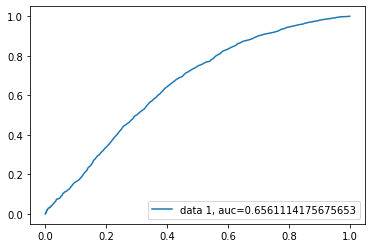

mass= 750
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


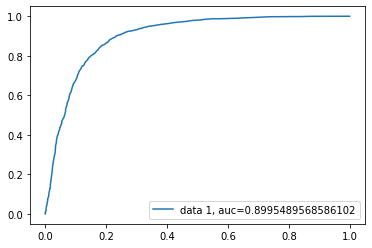

mass= 1000
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


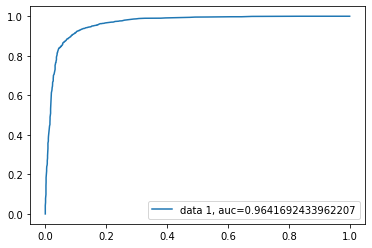

mass= 1250
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


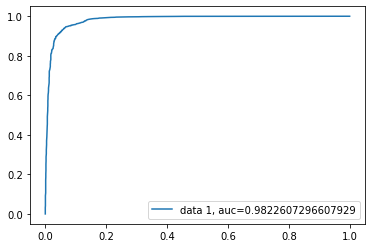

mass= 1500
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


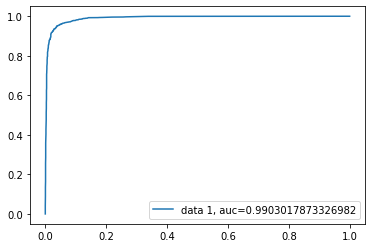

tn   fp    fn    tp       acc      prec    recall  F1_score  \
500   1966  431  1569   684  0.569892  0.613453  0.303595  0.406176   
750   1993  273   604  1780  0.811398  0.867024  0.746644  0.802344   
1000  2151  145   302  2052  0.903871  0.934001  0.871708   0.90178   
1250  2265  104   200  2081  0.934624  0.952403  0.912319   0.93193   
1500  2247   64   157  2182  0.952473  0.971505  0.932877  0.951799   

     kappa_cohen       auc  
500     0.125694  0.656111  
750     0.623912  0.899549  
1000    0.807874  0.964169  
1250    0.869098  0.982261  
1500    0.904966  0.990302

BTAG = all1
mass= 500
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


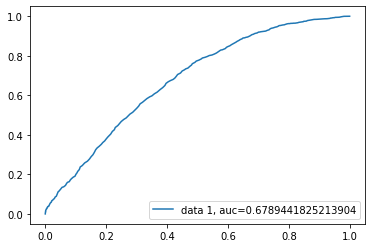

mass= 750
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


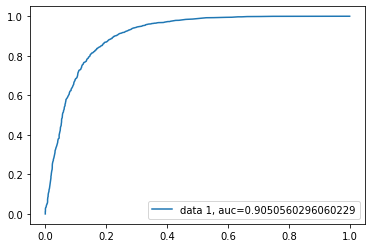

mass= 1000
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


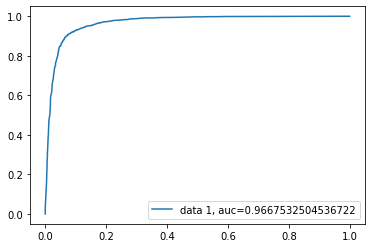

mass= 1250
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


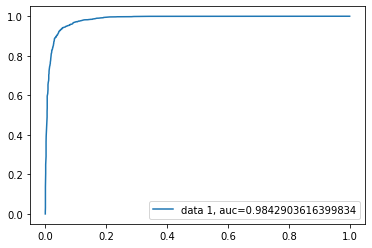

mass= 1500
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.3s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


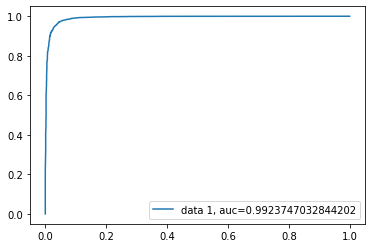

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1597  800  939  1314  0.626022   0.62157  0.583222  0.601786   
750   1919  347  443  1941  0.830108  0.848339  0.814178  0.830908   
1000  2116  180  207  2147  0.916774  0.922647  0.912065  0.917325   
1250  2257  112  168  2113  0.939785  0.949663  0.926348  0.937861   
1500  2238   73  118  2221  0.958925  0.968178  0.949551  0.958774   

     kappa_cohen       auc  
500     0.249935  0.678944  
750     0.660352  0.905056  
1000    0.833547  0.966753  
1250    0.879472   0.98429  
1500    0.917856  0.992375

BTAG = all2
mass= 500
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


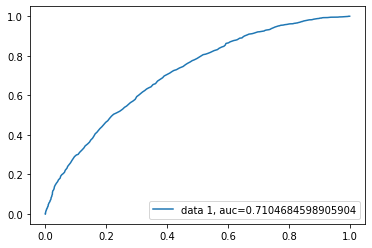

mass= 750
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


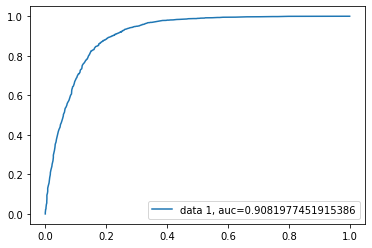

mass= 1000
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


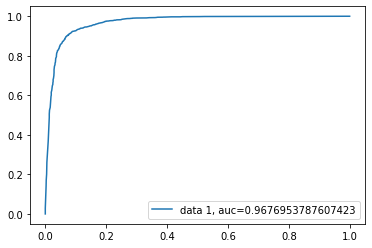

mass= 1250
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


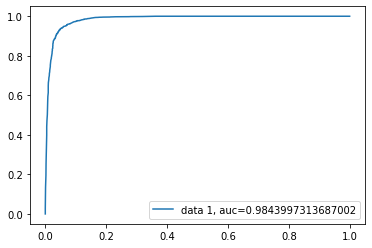

mass= 1500
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.3s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


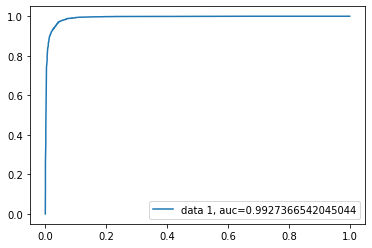

tn    fp   fn    tp       acc      prec    recall  F1_score  \
500   1364  1033  609  1644  0.646882   0.61412  0.729694  0.666937   
750   1798   468  257  2127  0.844086  0.819653  0.892198  0.854388   
1000  2059   237  164  2190  0.913763  0.902349  0.930331  0.916126   
1250  2227   142  120  2161  0.943656  0.938341  0.947391  0.942845   
1500  2210   101   67  2272  0.963871  0.957438  0.971355  0.964346   

     kappa_cohen       auc  
500     0.297059  0.710468  
750      0.68725  0.908198  
1000    0.827432  0.967695  
1250    0.887292    0.9844  
1500    0.927733  0.992737

BTAG = orig
mass= 500
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.9s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


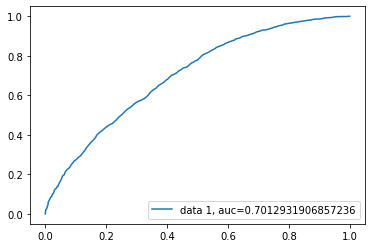

mass= 750
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


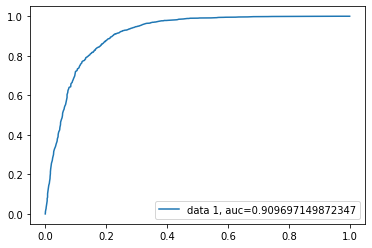

mass= 1000
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


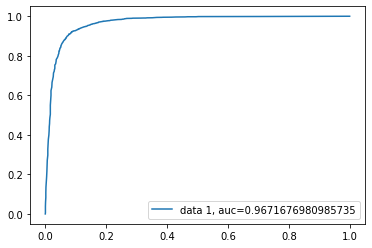

mass= 1250
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


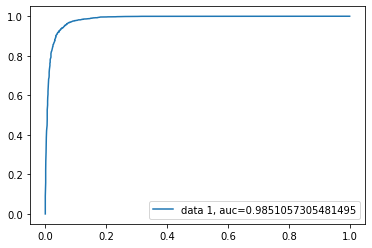

mass= 1500
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


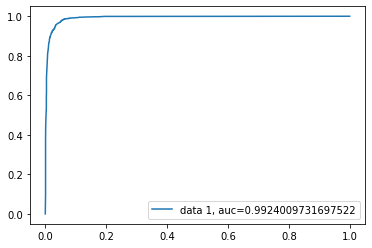

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1431  966  714  1539   0.63871  0.614371  0.683089   0.64691   
750   1802  464  277  2107  0.840645  0.819525  0.883809  0.850454   
1000  2069  227  171  2183  0.914409  0.905809  0.927358  0.916457   
1250  2226  143  123  2158  0.942796  0.937853  0.946076  0.941947   
1500  2216   95   83  2256   0.96172  0.959592  0.964515  0.962047   

     kappa_cohen       auc  
500     0.279148  0.701293  
750     0.680432  0.909697  
1000    0.828739  0.967168  
1250    0.885569  0.985106  
1500    0.923436  0.992401

BTAG = real
mass= 500
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


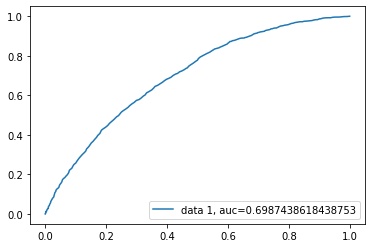

mass= 750
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.2s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


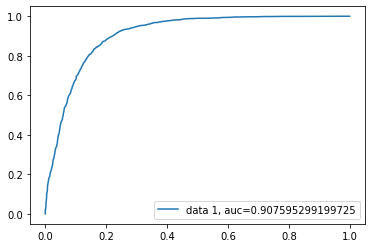

mass= 1000
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


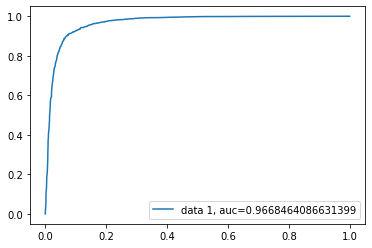

mass= 1250
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


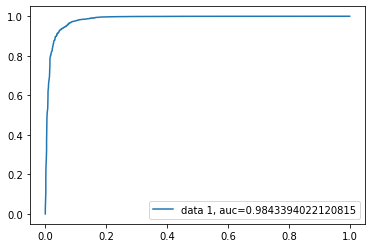

mass= 1500
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


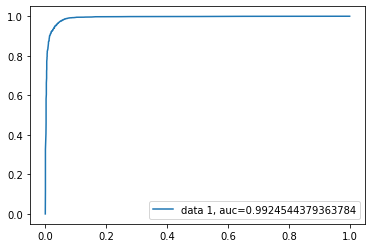

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1476  921  754  1499  0.639785  0.619421  0.665335  0.641558   
750   1831  435  301  2083   0.84172  0.827244  0.873742  0.849857   
1000  2080  216  184  2170  0.913978  0.909472  0.921835  0.915612   
1250  2231  138  136  2145  0.941075  0.939553  0.940377  0.939965   
1500  2222   89   97  2242      0.96  0.961819  0.958529  0.960171   

     kappa_cohen       auc  
500      0.28048  0.698744  
750     0.682773  0.907595  
1000    0.827901  0.966846  
1250     0.88211  0.984339  
1500    0.919999  0.992454

BTAG = all0
mass= 500
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)


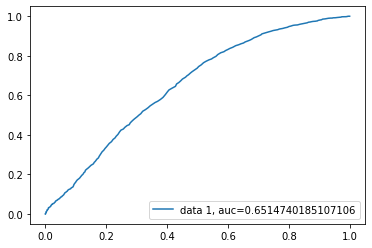

mass= 750
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.3s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)


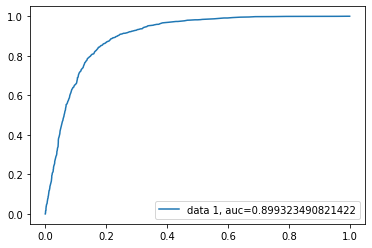

mass= 1000
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)


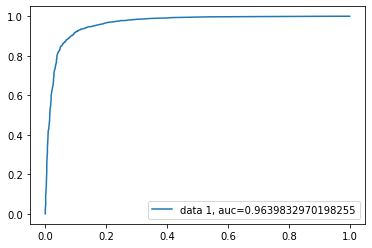

mass= 1250
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.9s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)


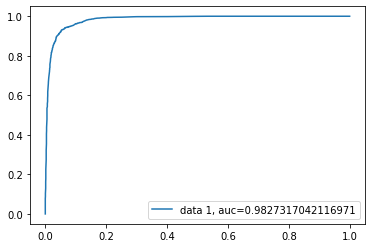

mass= 1500
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)


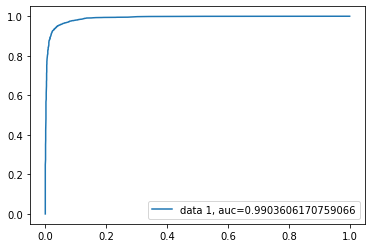

tn   fp    fn    tp       acc      prec    recall  F1_score  \
500   1996  401  1639   614   0.56129  0.604926  0.272526  0.375765   
750   2000  266   656  1728   0.80172    0.8666  0.724832  0.789402   
1000  2144  152   301  2053  0.902581  0.931066  0.872133  0.900636   
1250  2261  108   197  2084  0.934409   0.95073  0.913634  0.931813   
1500  2243   68   150  2189  0.953118  0.969872   0.93587  0.952567   

     kappa_cohen       auc  
500     0.106999  0.651474  
750     0.604868  0.899323  
1000    0.805287  0.963983  
1250    0.868675  0.982732  
1500    0.906253  0.990361

BTAG = all1
mass= 500
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)


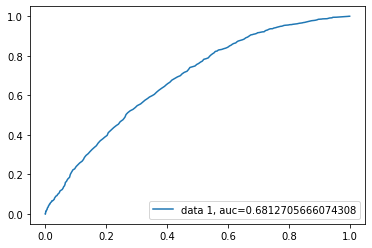

mass= 750
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)


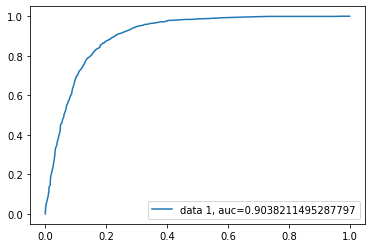

mass= 1000
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)


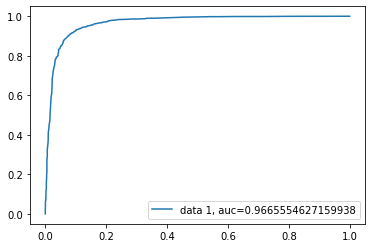

mass= 1250
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)


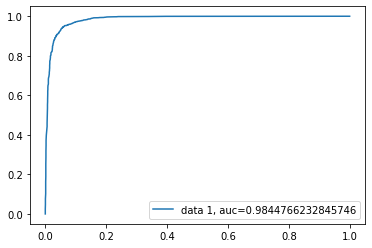

mass= 1500
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.2s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)


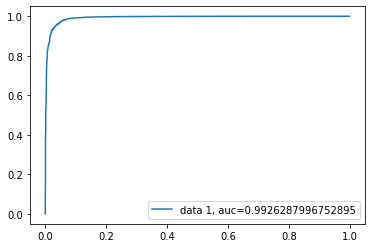

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1577  820  921  1332  0.625591  0.618959  0.591212  0.604767   
750   1885  381  397  1987  0.832688  0.839105  0.833473  0.836279   
1000  2103  193  206  2148  0.914194  0.917557  0.912489  0.915016   
1250  2253  116  168  2113  0.938925  0.947959  0.926348  0.937029   
1500  2241   70  127  2212  0.957634  0.969325  0.945703  0.957369   

     kappa_cohen       auc  
500     0.249453  0.681271  
750     0.665219  0.903821  
1000    0.828372  0.966555  
1250    0.877754  0.984477  
1500    0.915278  0.992629

BTAG = all2
mass= 500
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.9s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)


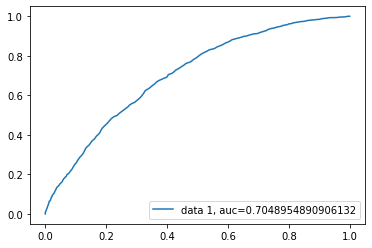

mass= 750
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)


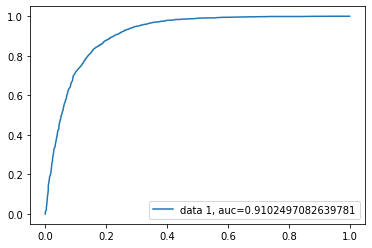

mass= 1000
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.2s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)


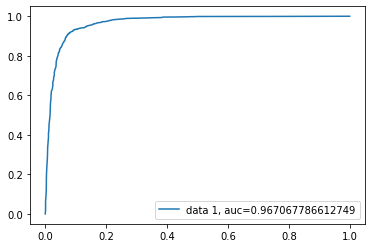

mass= 1250
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)


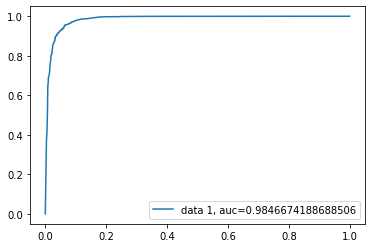

mass= 1500
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.3s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)


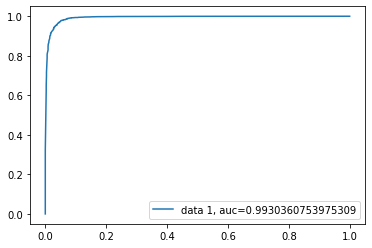

tn    fp   fn    tp       acc      prec    recall  F1_score  \
500   1367  1030  611  1642  0.647097  0.614521  0.728806  0.666802   
750   1796   470  277  2107  0.839355  0.817617  0.883809  0.849426   
1000  2054   242  154  2200  0.914839  0.900901  0.934579  0.917431   
1250  2225   144  130  2151  0.941075  0.937255  0.943007  0.940122   
1500  2209   102   77  2262  0.961505  0.956853   0.96708  0.961939   

     kappa_cohen       auc  
500     0.297441  0.704895  
750     0.677824   0.91025  
1000     0.82957  0.967068  
1250    0.882122  0.984667  
1500    0.923003  0.993036

BTAG = orig
mass= 500
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)


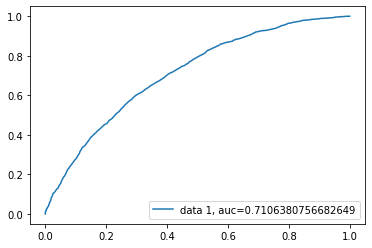

mass= 750
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.9s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)


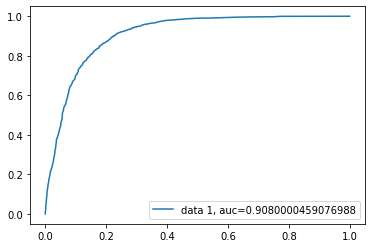

mass= 1000
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)


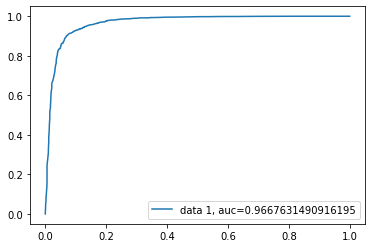

mass= 1250
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)


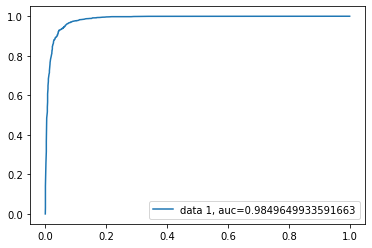

mass= 1500
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)


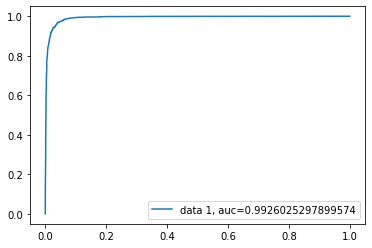

tn    fp   fn    tp       acc      prec    recall  F1_score  \
500   1356  1041  602  1651  0.646667  0.613299  0.732801  0.667745   
750   1788   478  277  2107  0.837634  0.815087  0.883809  0.848058   
1000  2058   238  166  2188  0.913118  0.901896  0.929482  0.915481   
1250  2231   138  138  2143  0.940645    0.9395    0.9395    0.9395   
1500  2217    94   80  2259  0.962581  0.960051  0.965797  0.962916   

     kappa_cohen       auc  
500     0.296771  0.710638  
750     0.674345     0.908  
1000    0.826142  0.966763  
1250    0.881248  0.984965  
1500    0.925156  0.992603

BTAG = real
mass= 500
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)


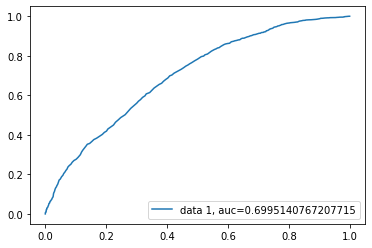

mass= 750
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.3s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)


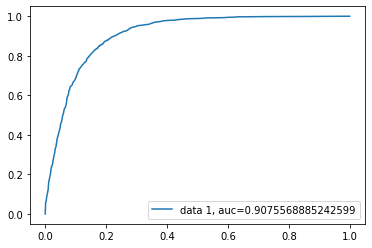

mass= 1000
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.9s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)


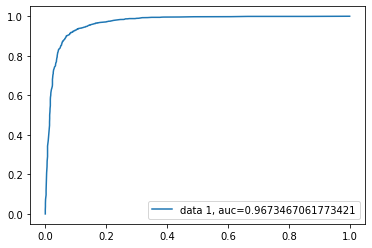

mass= 1250
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)


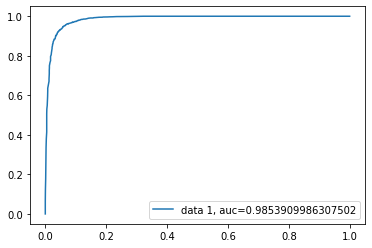

mass= 1500
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)


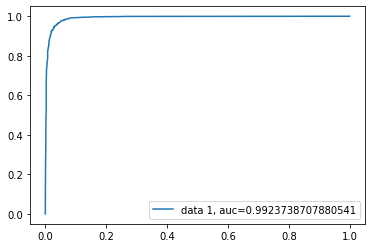

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1400  997  670  1583  0.641505  0.613566  0.702619   0.65508   
750   1837  429  332  2052  0.836344  0.827086  0.860738  0.843577   
1000  2090  206  188  2166  0.915269  0.913153  0.920136  0.916631   
1250  2238  131  136  2145  0.942581  0.942443  0.940377  0.941409   
1500  2224   87  100  2239  0.959785  0.962597  0.957247  0.959914   

     kappa_cohen       auc  
500     0.285438  0.699514  
750      0.67213  0.907557  
1000    0.830495  0.967347  
1250    0.885115  0.985391  
1500     0.91957  0.992374

BTAG = all0
mass= 500
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)


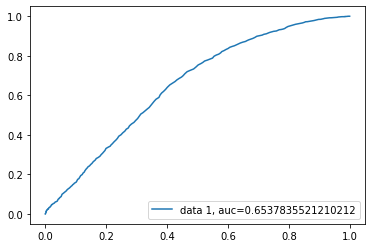

mass= 750
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)


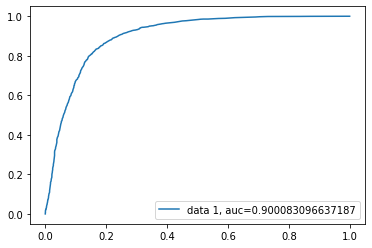

mass= 1000
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.2s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)


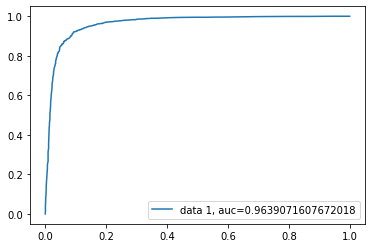

mass= 1250
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)


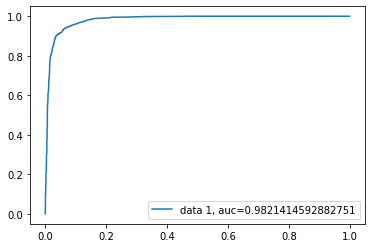

mass= 1500
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.2s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)


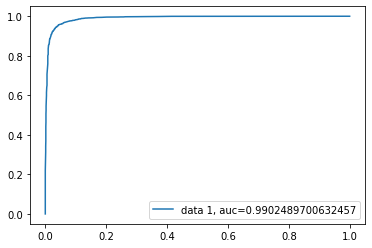

tn   fp    fn    tp       acc      prec    recall  F1_score  \
500   1967  430  1596   657  0.564301  0.604416  0.291611  0.393413   
750   2003  263   658  1726  0.801935  0.867773  0.723993  0.789389   
1000  2157  139   301  2053  0.905376  0.936588  0.872133  0.903212   
1250  2271   98   205  2076  0.934839  0.954922  0.910127  0.931987   
1500  2245   66   162  2177  0.950968  0.970575   0.93074   0.95024   

     kappa_cohen       auc  
500     0.113992  0.653784  
750     0.605318  0.900083  
1000    0.810888  0.963907  
1250    0.869517  0.982141  
1500    0.901956  0.990249

BTAG = all1
mass= 500
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.9s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)


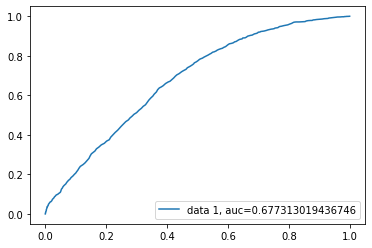

mass= 750
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)


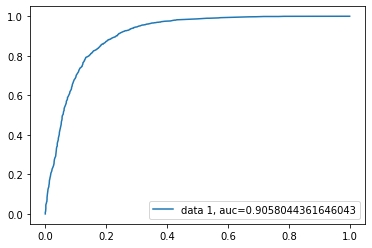

mass= 1000
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)


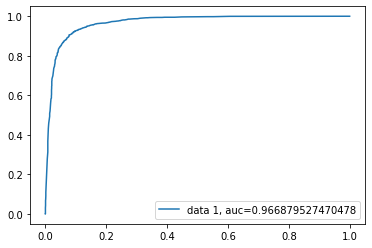

mass= 1250
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.9s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)


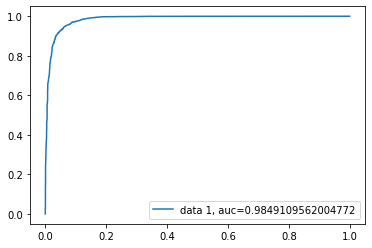

mass= 1500
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.3s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)


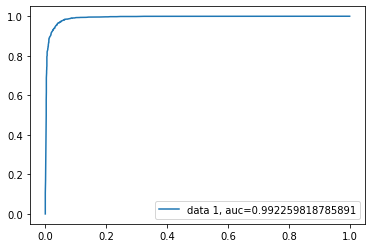

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1565  832  930  1323  0.621075  0.613921  0.587217  0.600272   
750   1900  366  414  1970  0.832258  0.843322  0.826342  0.834746   
1000  2107  189  219  2135  0.912258  0.918675  0.906967  0.912783   
1250  2248  121  162  2119   0.93914  0.945982  0.928979  0.937403   
1500  2226   85  107  2232   0.95871  0.963315  0.954254  0.958763   

     kappa_cohen       auc  
500     0.240431  0.677313  
750     0.664476  0.905804  
1000    0.824517   0.96688  
1250    0.878195  0.984911  
1500    0.917421   0.99226

BTAG = all2
mass= 500
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)


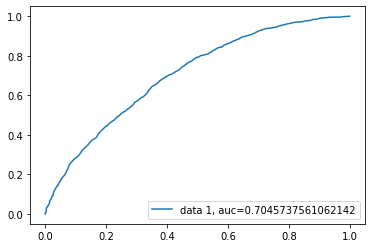

mass= 750
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)


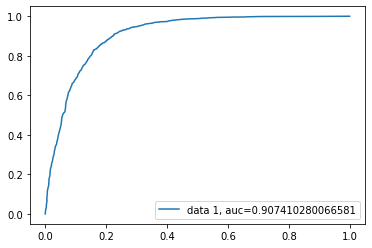

mass= 1000
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)


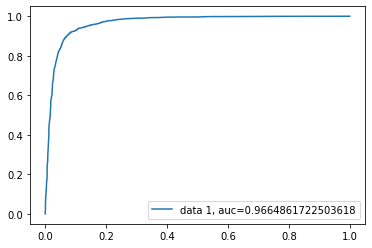

mass= 1250
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.9s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)


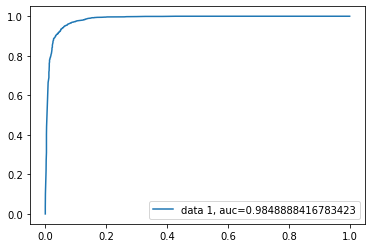

mass= 1500
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.3s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)


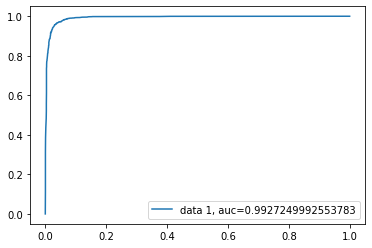

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1455  942  696  1557  0.647742  0.623049  0.691079  0.655303   
750   1785  481  263  2121      0.84  0.815142  0.889681  0.850782   
1000  2056  240  159  2195  0.914194  0.901437  0.932455  0.916684   
1250  2227  142  128  2153  0.941935  0.938126  0.943884  0.940997   
1500  2203  108   67  2272  0.962366  0.954622  0.971355  0.962916   

     kappa_cohen       auc  
500     0.297113  0.704574  
750      0.67903   0.90741  
1000    0.828286  0.966486  
1250    0.883843  0.984889  
1500     0.92472  0.992725

BTAG = orig
mass= 500
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)


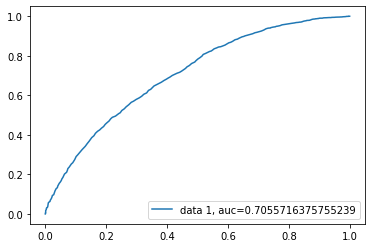

mass= 750
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)


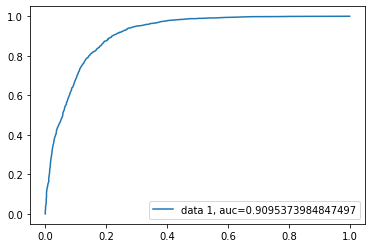

mass= 1000
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)


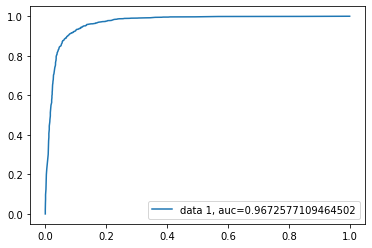

mass= 1250
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)


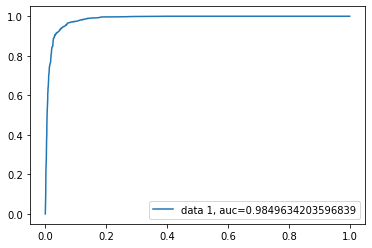

mass= 1500
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)


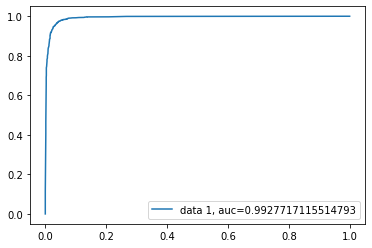

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1415  982  693  1560  0.639785   0.61369   0.69241  0.650678   
750   1798  468  270  2114   0.84129  0.818745  0.886745  0.851389   
1000  2067  229  173  2181  0.913548  0.904979  0.926508  0.915617   
1250  2233  136  125  2156  0.943871  0.940663  0.945199  0.942926   
1500  2221   90   79  2260  0.963656  0.961702  0.966225  0.963958   

     kappa_cohen       auc  
500     0.281646  0.705572  
750     0.681688  0.909537  
1000    0.827018  0.967258  
1250    0.887712  0.984963  
1500    0.927307  0.992772

BTAG = real
mass= 500
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)


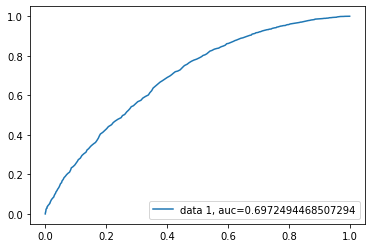

mass= 750
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.9s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)


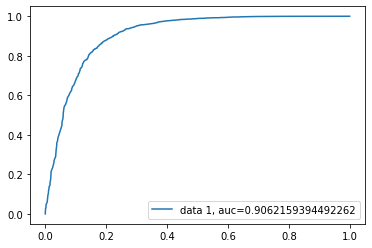

mass= 1000
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)


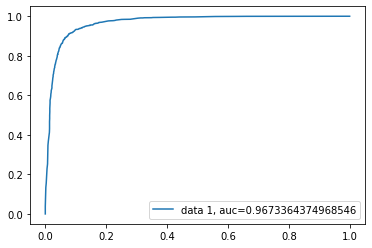

mass= 1250
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)


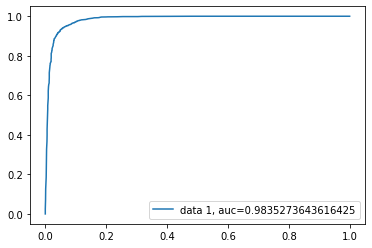

mass= 1500
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.3s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)


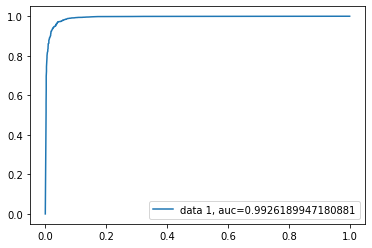

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1510  887  771  1482  0.643441   0.62558   0.65779  0.641281   
750   1825  441  298  2086  0.841075  0.825485     0.875  0.849521   
1000  2087  209  188  2166  0.914624     0.912  0.920136   0.91605   
1250  2234  135  134  2147  0.942151  0.940841  0.941254  0.941048   
1500  2221   90   85  2254  0.962366  0.961604   0.96366  0.962631   

     kappa_cohen       auc  
500     0.287299  0.697249  
750     0.681448  0.906216  
1000    0.829201  0.967336  
1250    0.884261  0.983527  
1500    0.924727  0.992619

BTAG = all0
mass= 500
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=4, verbose=0,
                       warm_start=False)


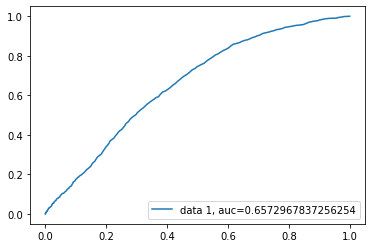

mass= 750
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=4, verbose=0,
                       warm_start=False)


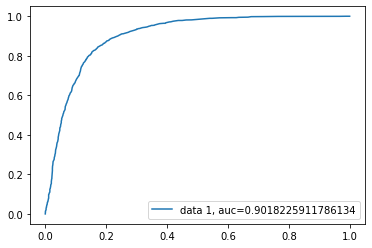

mass= 1000
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=4, verbose=0,
                       warm_start=False)


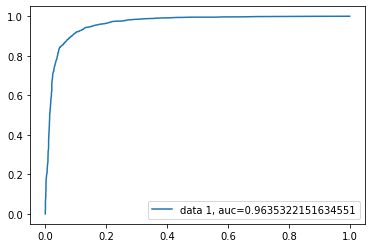

mass= 1250
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=4, verbose=0,
                       warm_start=False)


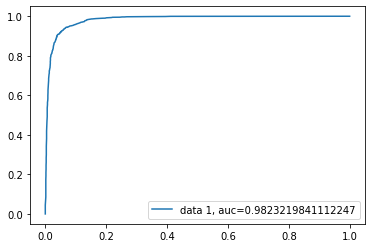

mass= 1500
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=4, verbose=0,
                       warm_start=False)


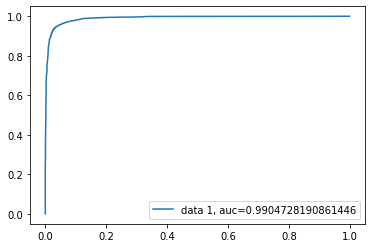

tn   fp    fn    tp       acc      prec    recall  F1_score  \
500   1956  441  1571   682  0.567312  0.607302  0.302708  0.404028   
750   1994  272   605  1779  0.811398  0.867382  0.746225  0.802255   
1000  2146  150   306  2048  0.901935  0.931756  0.870008  0.899824   
1250  2259  110   201  2080  0.933118  0.949772  0.911881  0.930441   
1500  2247   64   154  2185  0.953118  0.971543   0.93416  0.952485   

     kappa_cohen       auc  
500     0.120544  0.657297  
750      0.62392  0.901823  
1000    0.804005  0.963532  
1250    0.866089  0.982322  
1500    0.906255  0.990473

BTAG = all1
mass= 500
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=4, verbose=0,
                       warm_start=False)


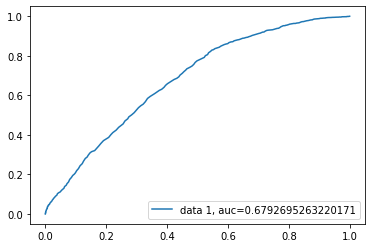

mass= 750
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.9s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=4, verbose=0,
                       warm_start=False)


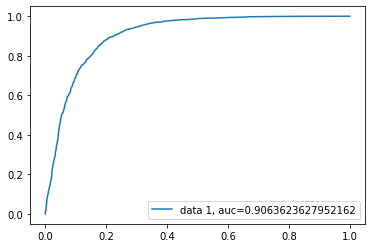

mass= 1000
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.9s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=4, verbose=0,
                       warm_start=False)


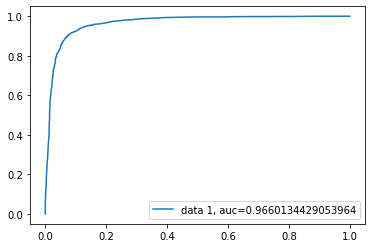

mass= 1250
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=4, verbose=0,
                       warm_start=False)


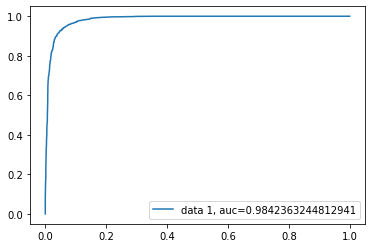

mass= 1500
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.2s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=4, verbose=0,
                       warm_start=False)


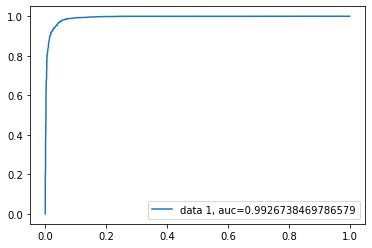

tn   fp    fn    tp       acc      prec    recall  F1_score  \
500   1645  752  1020  1233  0.618925  0.621159   0.54727  0.581878   
750   1894  372   404  1980  0.833118  0.841837  0.830537  0.836149   
1000  2106  190   206  2148  0.914839  0.918734  0.912489  0.915601   
1250  2252  117   167  2114  0.938925  0.947557  0.926786  0.937057   
1500  2238   73   130  2209  0.956344  0.968011  0.944421   0.95607   

     kappa_cohen       auc  
500     0.234382   0.67927  
750     0.666138  0.906362  
1000    0.829666  0.966013  
1250    0.877756  0.984236  
1500    0.912698  0.992674

BTAG = all2
mass= 500
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=4, verbose=0,
                       warm_start=False)


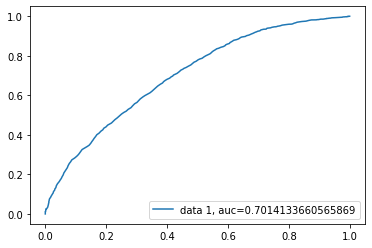

mass= 750
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=4, verbose=0,
                       warm_start=False)


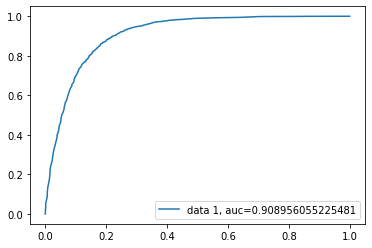

mass= 1000
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.3s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=4, verbose=0,
                       warm_start=False)


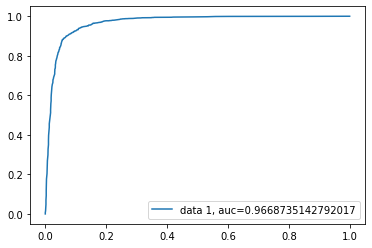

mass= 1250
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=4, verbose=0,
                       warm_start=False)


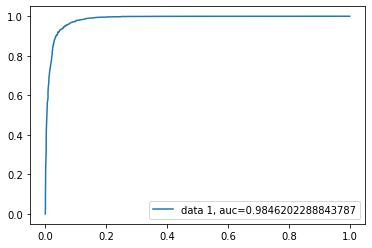

mass= 1500
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.9s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=4, verbose=0,
                       warm_start=False)


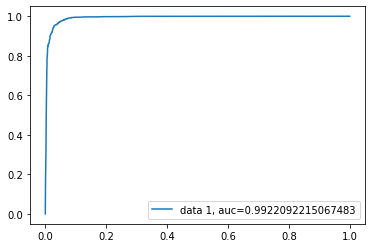

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1405  992  690  1563   0.63828  0.611742  0.693742  0.650166   
750   1789  477  269  2115   0.83957  0.815972  0.887164   0.85008   
1000  2061  235  166  2188  0.913763  0.903013  0.929482  0.916056   
1250  2230  139  129  2152  0.942366  0.939328  0.943446  0.941382   
1500  2201  110   68  2271   0.96172  0.953801  0.970928  0.962288   

     kappa_cohen       auc  
500     0.278769  0.701413  
750     0.678202  0.908956  
1000    0.827436  0.966874  
1250    0.884699   0.98462  
1500     0.92343  0.992209

BTAG = orig
mass= 500
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.2s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=4, verbose=0,
                       warm_start=False)


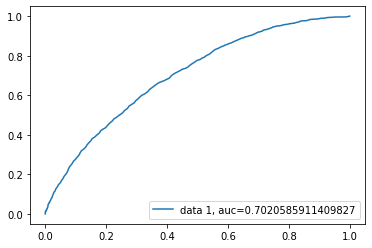

mass= 750
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=4, verbose=0,
                       warm_start=False)


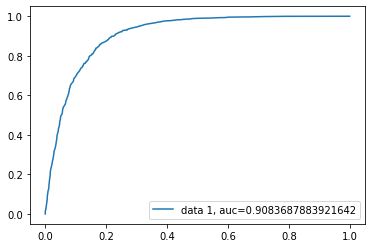

mass= 1000
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=4, verbose=0,
                       warm_start=False)


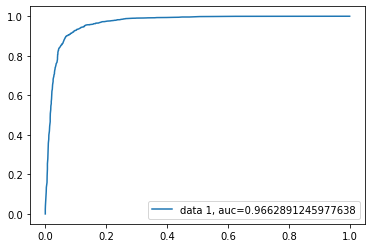

mass= 1250
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=4, verbose=0,
                       warm_start=False)


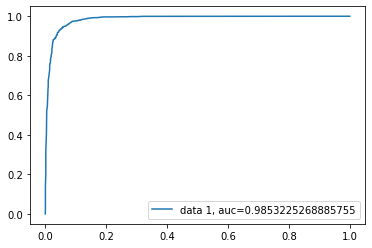

mass= 1500
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=4, verbose=0,
                       warm_start=False)


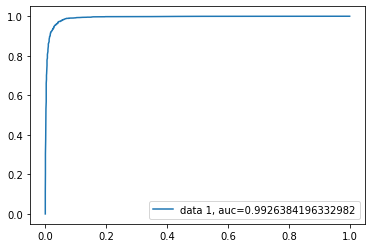

tn    fp   fn    tp       acc      prec    recall  F1_score  \
500   1354  1043  634  1619  0.639355  0.608189  0.718597    0.6588   
750   1806   460  292  2092   0.83828  0.819749  0.877517   0.84765   
1000  2065   231  168  2186  0.914194  0.904427  0.928632   0.91637   
1250  2244   125  142  2139  0.942581  0.944788  0.937747  0.941254   
1500  2212    99   69  2270  0.963871   0.95821    0.9705  0.964316   

     kappa_cohen       auc  
500     0.281933  0.702059  
750     0.675756  0.908369  
1000    0.828302  0.966289  
1250    0.885104  0.985323  
1500    0.927734  0.992638

BTAG = real
mass= 500
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=4, verbose=0,
                       warm_start=False)


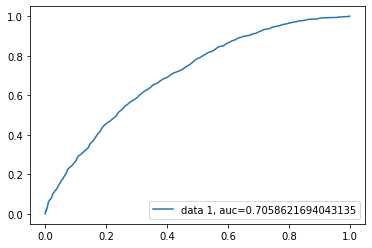

mass= 750
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=4, verbose=0,
                       warm_start=False)


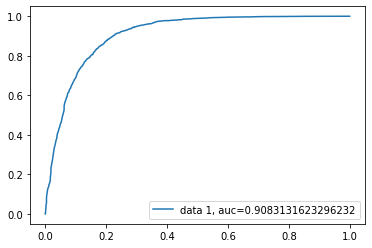

mass= 1000
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.3s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=4, verbose=0,
                       warm_start=False)


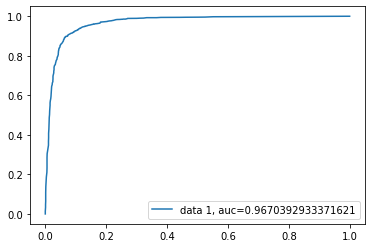

mass= 1250
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=4, verbose=0,
                       warm_start=False)


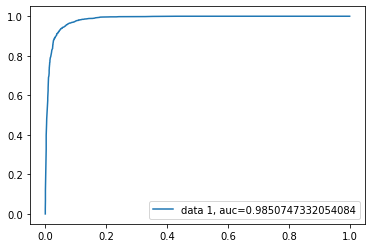

mass= 1500
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=4, verbose=0,
                       warm_start=False)


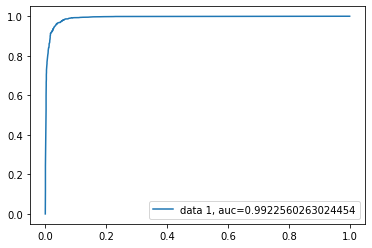

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1488  909  733  1520  0.646882  0.625772  0.674656  0.649295   
750   1819  447  304  2080  0.838495   0.82311  0.872483  0.847078   
1000  2074  222  179  2175  0.913763  0.907384  0.923959  0.915597   
1250  2236  133  133  2148  0.942796  0.941692  0.941692  0.941692   
1500  2218   93   80  2259  0.962796  0.960459  0.965797  0.963121   

     kappa_cohen       auc  
500      0.29474  0.705862  
750     0.676276  0.908313  
1000     0.82746  0.967039  
1250     0.88555  0.985075  
1500    0.925586  0.992256

BTAG = all0
mass= 500
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)


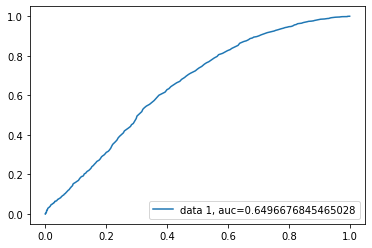

mass= 750
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.3s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)


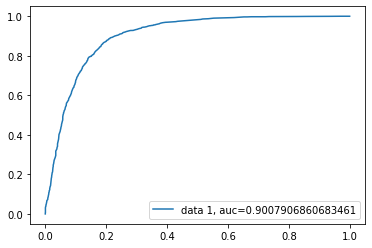

mass= 1000
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)


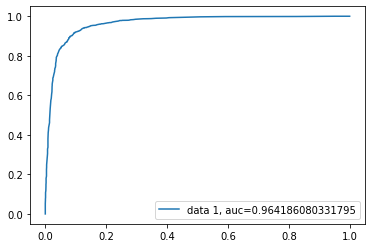

mass= 1250
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)


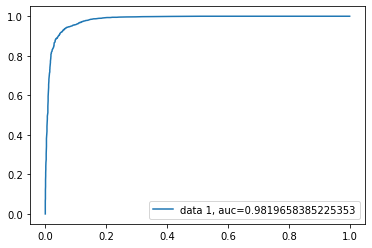

mass= 1500
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)


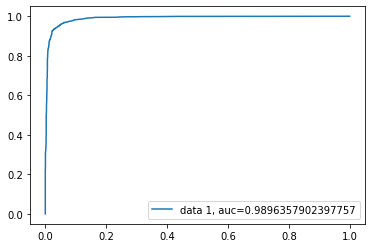

tn   fp    fn    tp       acc      prec    recall  F1_score  \
500   1945  452  1591   662  0.560645  0.594255   0.29383  0.393228   
750   1988  278   610  1774  0.809032  0.864522  0.744128   0.79982   
1000  2127  169   293  2061  0.900645  0.924215  0.875531  0.899215   
1250  2257  112   208  2073  0.931183  0.948741  0.908812  0.928348   
1500  2242   69   151  2188  0.952688  0.969428  0.935442  0.952132   

     kappa_cohen       auc  
500     0.106884  0.649668  
750     0.619199  0.900791  
1000    0.801392  0.964186  
1250    0.862209  0.981966  
1500    0.905393  0.989636

BTAG = all1
mass= 500
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)


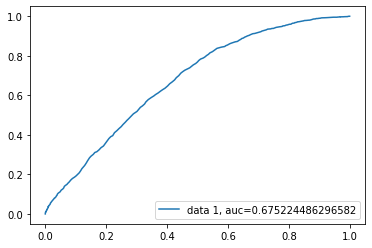

mass= 750
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)


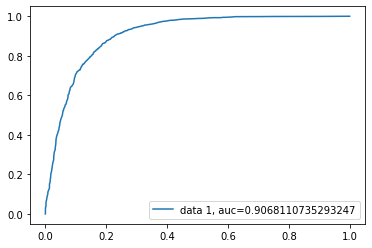

mass= 1000
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)


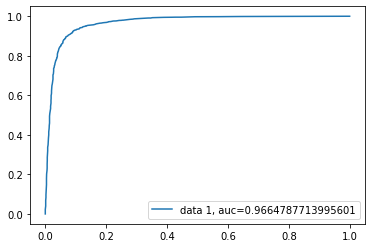

mass= 1250
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)


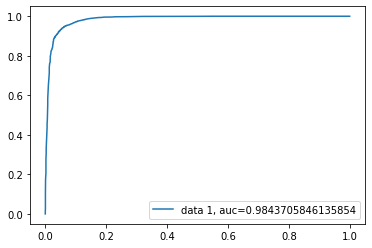

mass= 1500
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)


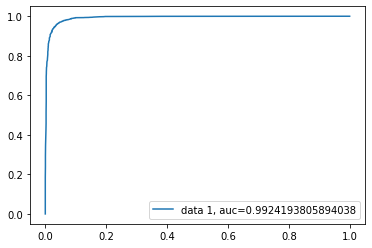

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1605  792  977  1276   0.61957  0.617021  0.566356  0.590604   
750   1910  356  457  1927  0.825161  0.844065  0.808305  0.825798   
1000  2104  192  207  2147  0.914194  0.917914  0.912065   0.91498   
1250  2261  108  172  2109  0.939785  0.951286  0.924594   0.93775   
1500  2240   71  125  2214  0.957849  0.968928  0.946558  0.957612   

     kappa_cohen       auc  
500     0.236526  0.675224  
750     0.650483  0.906811  
1000    0.828374  0.966479  
1250    0.879464  0.984371  
1500    0.915708  0.992419

BTAG = all2
mass= 500
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)


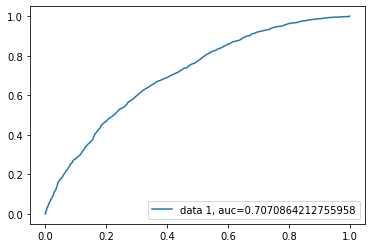

mass= 750
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.2s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)


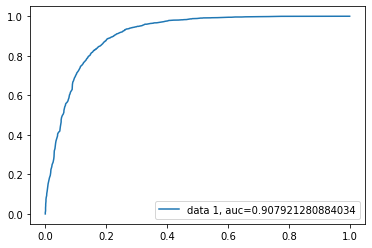

mass= 1000
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.2s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)


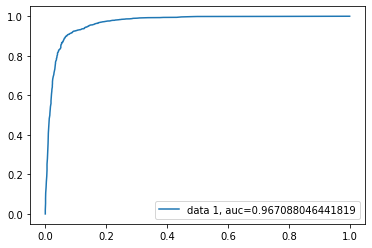

mass= 1250
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)


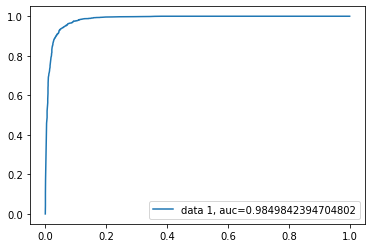

mass= 1500
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)


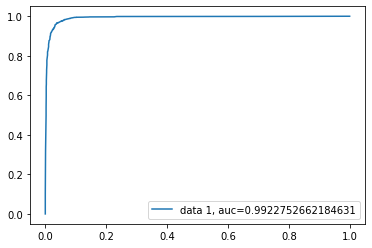

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1413  984  678  1575  0.642581  0.615475  0.699068  0.654613   
750   1799  467  269  2115   0.84172  0.819132  0.887164  0.851792   
1000  2047  249  164  2190  0.911183  0.897909  0.930331  0.913833   
1250  2225  144  126  2155  0.941935  0.937364  0.944761  0.941048   
1500  2202  109   68  2271  0.961935  0.954202  0.970928  0.962492   

     kappa_cohen       auc  
500     0.287382  0.707086  
750      0.68255  0.907921  
1000    0.822257  0.967088  
1250    0.883846  0.984984  
1500     0.92386  0.992275

BTAG = orig
mass= 500
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)


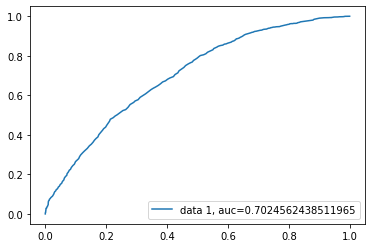

mass= 750
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)


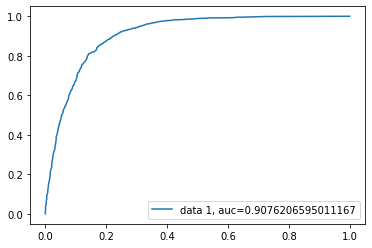

mass= 1000
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.2s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)


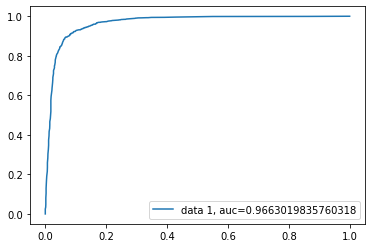

mass= 1250
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)


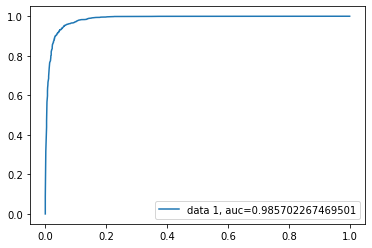

mass= 1500
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)


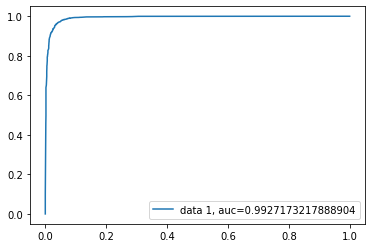

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1415  982  703  1550  0.637634  0.612164  0.687972  0.647858   
750   1785  481  275  2109  0.837419  0.814286  0.884648   0.84801   
1000  2066  230  173  2181  0.913333  0.904604  0.926508  0.915425   
1250  2239  130  139  2142  0.942151  0.942782  0.939062  0.940918   
1500  2210  101   71  2268  0.963011  0.957366  0.969645  0.963466   

     kappa_cohen       auc  
500     0.277261  0.702456  
750     0.673895  0.907621  
1000    0.826587  0.966302  
1250    0.884251  0.985702  
1500    0.926013  0.992717

BTAG = real
mass= 500
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)


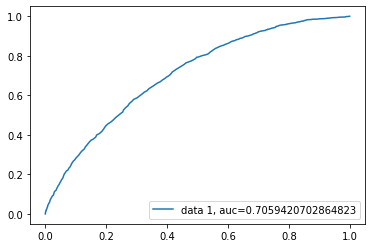

mass= 750
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)


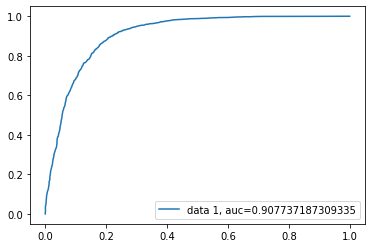

mass= 1000
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)


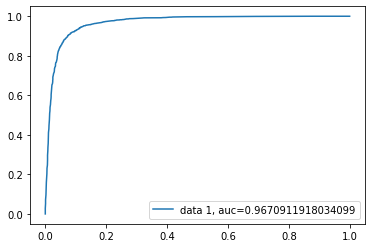

mass= 1250
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.3s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)


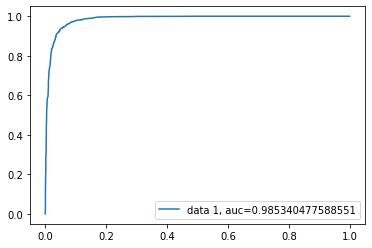

mass= 1500
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.9s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)


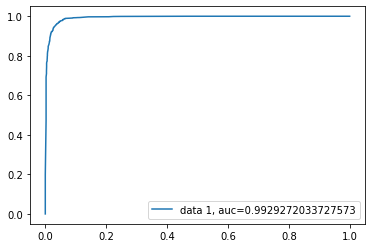

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1456  941  710  1543  0.644946  0.621176  0.684865  0.651467   
750   1834  432  309  2075  0.840645  0.827682  0.870386  0.848497   
1000  2089  207  188  2166  0.915054  0.912769  0.920136  0.916437   
1250  2233  136  131  2150  0.942581  0.940507  0.942569  0.941537   
1500  2226   85   95  2244   0.96129  0.963504  0.959384   0.96144   

     kappa_cohen       auc  
500     0.291393  0.705942  
750     0.680656  0.907737  
1000    0.830064  0.967091  
1250    0.885125   0.98534  
1500     0.92258  0.992927

BTAG = all0
mass= 500
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=6, verbose=0,
                       warm_start=False)


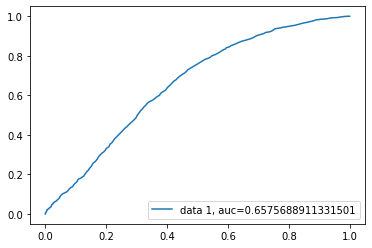

mass= 750
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=6, verbose=0,
                       warm_start=False)


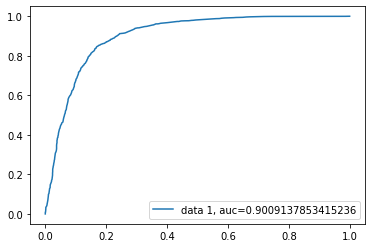

mass= 1000
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=6, verbose=0,
                       warm_start=False)


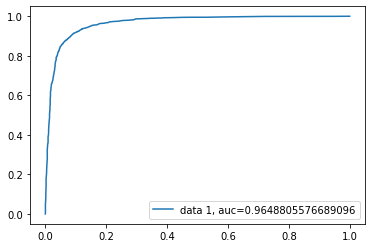

mass= 1250
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=6, verbose=0,
                       warm_start=False)


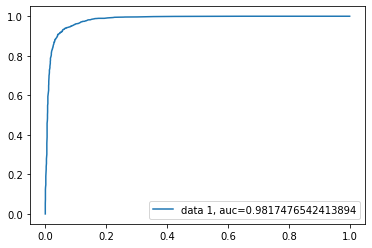

mass= 1500
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.2s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=6, verbose=0,
                       warm_start=False)


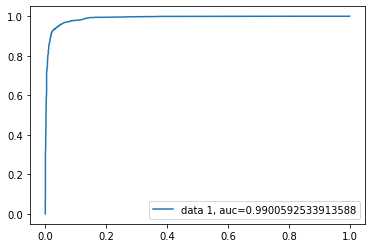

tn   fp    fn    tp       acc      prec    recall  F1_score  \
500   1973  424  1594   659  0.566022  0.608495  0.292499  0.395084   
750   2004  262   647  1737  0.804516  0.868934  0.728607  0.792608   
1000  2145  151   289  2065  0.905376  0.931859   0.87723   0.90372   
1250  2262  107   203  2078  0.933333   0.95103  0.911004  0.930587   
1500  2247   64   160  2179  0.951828  0.971467  0.931595  0.951113   

     kappa_cohen       auc  
500     0.117443  0.657569  
750     0.610418  0.900914  
1000    0.810863  0.964881  
1250    0.866515  0.981748  
1500    0.903676  0.990059

BTAG = all1
mass= 500
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=6, verbose=0,
                       warm_start=False)


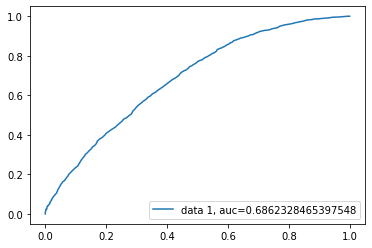

mass= 750
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=6, verbose=0,
                       warm_start=False)


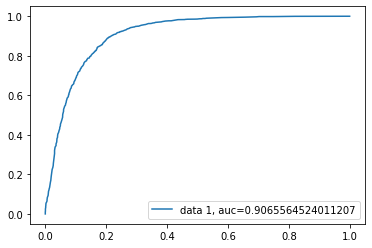

mass= 1000
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=6, verbose=0,
                       warm_start=False)


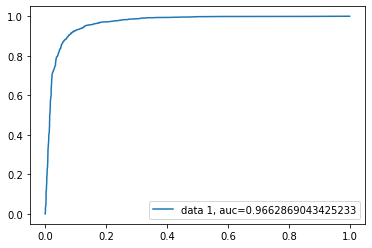

mass= 1250
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=6, verbose=0,
                       warm_start=False)


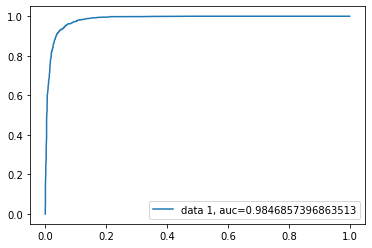

mass= 1500
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=6, verbose=0,
                       warm_start=False)


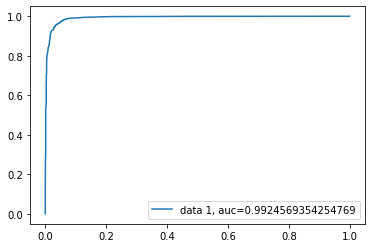

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1586  811  920  1333  0.627742  0.621735  0.591656  0.606322   
750   1895  371  420  1964  0.829892  0.841113  0.823826   0.83238   
1000  2104  192  210  2144  0.913548  0.917808   0.91079  0.914286   
1250  2257  112  165  2116   0.94043  0.949731  0.927663  0.938567   
1500  2237   74  125  2214  0.957204  0.967657  0.946558  0.956992   

     kappa_cohen       auc  
500     0.253685  0.686233  
750     0.659748  0.906556  
1000    0.827087  0.966287  
1250    0.880766  0.984686  
1500    0.914417  0.992457

BTAG = all2
mass= 500
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=6, verbose=0,
                       warm_start=False)


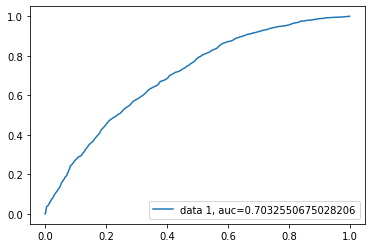

mass= 750
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.2s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=6, verbose=0,
                       warm_start=False)


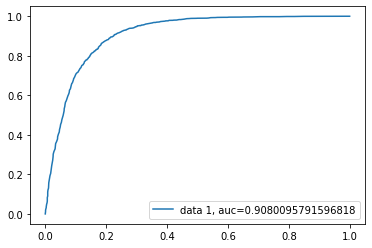

mass= 1000
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=6, verbose=0,
                       warm_start=False)


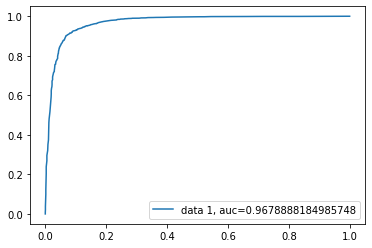

mass= 1250
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.2s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=6, verbose=0,
                       warm_start=False)


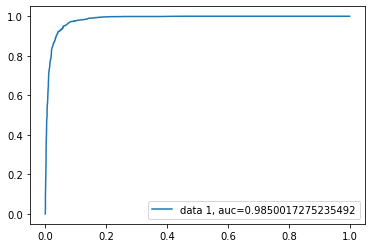

mass= 1500
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.2s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=6, verbose=0,
                       warm_start=False)


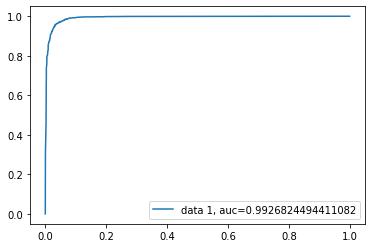

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1430  967  700  1553  0.641505   0.61627  0.689303  0.650744   
750   1812  454  291  2093  0.839785  0.821751  0.877936  0.848915   
1000  2058  238  160  2194  0.914409  0.902138  0.932031  0.916841   
1250  2229  140  115  2166  0.945161  0.939289  0.949584  0.944408   
1500  2203  108   71  2268  0.961505  0.954545  0.969645  0.962036   

     kappa_cohen       auc  
500     0.284868  0.703255  
750     0.678792   0.90801  
1000    0.828719  0.967889  
1250    0.890306  0.985002  
1500    0.923001  0.992682

BTAG = orig
mass= 500
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=6, verbose=0,
                       warm_start=False)


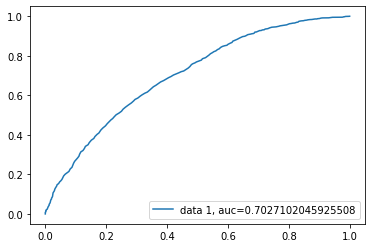

mass= 750
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=6, verbose=0,
                       warm_start=False)


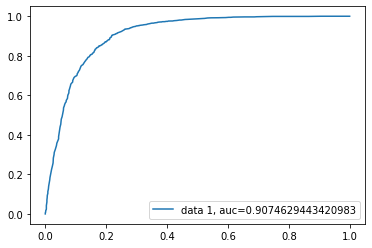

mass= 1000
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=6, verbose=0,
                       warm_start=False)


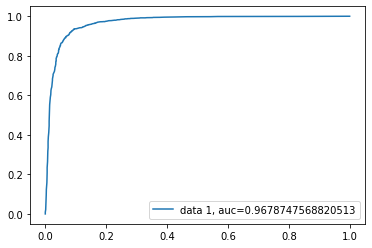

mass= 1250
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=6, verbose=0,
                       warm_start=False)


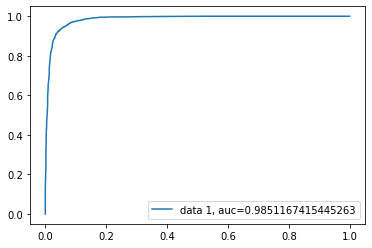

mass= 1500
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=6, verbose=0,
                       warm_start=False)


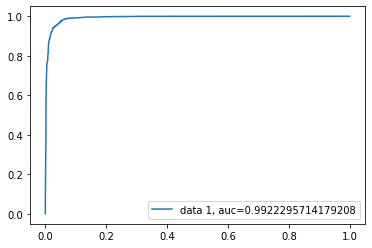

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1407  990  687  1566  0.639355  0.612676  0.695073  0.651279   
750   1801  465  290  2094  0.837634  0.818288  0.878356  0.847259   
1000  2079  217  154  2200  0.920215  0.910219  0.934579  0.922239   
1250  2236  133  138  2143   0.94172  0.941564    0.9395  0.940531   
1500  2209  102   88  2251   0.95914  0.956651  0.962377  0.959506   

     kappa_cohen       auc  
500     0.280922   0.70271  
750     0.674437  0.907463  
1000    0.840351  0.967875  
1250    0.883394  0.985117  
1500    0.918274   0.99223

BTAG = real
mass= 500
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   33.3s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=6, verbose=0,
                       warm_start=False)


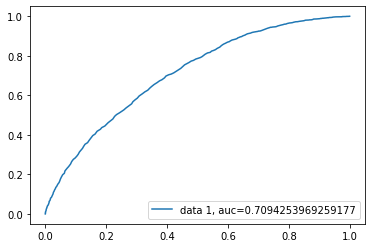

mass= 750
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=6, verbose=0,
                       warm_start=False)


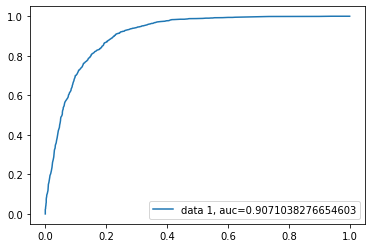

mass= 1000
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=6, verbose=0,
                       warm_start=False)


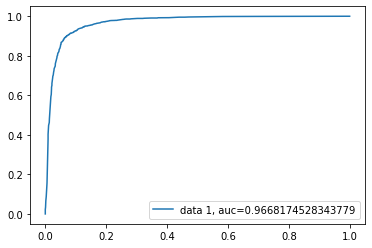

mass= 1250
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=6, verbose=0,
                       warm_start=False)


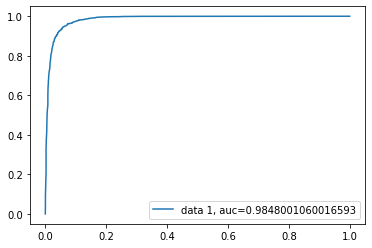

mass= 1500
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=6, verbose=0,
                       warm_start=False)


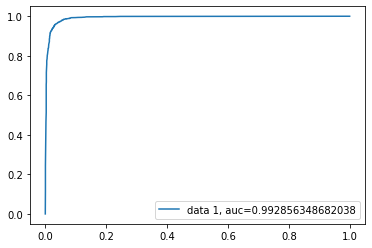

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1425  972  667  1586  0.647527  0.620016   0.70395  0.659322   
750   1814  452  314  2070  0.835269  0.820777  0.868289  0.843865   
1000  2074  222  179  2175  0.913763  0.907384  0.923959  0.915597   
1250  2236  133  133  2148  0.942796  0.941692  0.941692  0.941692   
1500  2234   77   96  2243  0.962796   0.96681  0.958957  0.962868   

     kappa_cohen       auc  
500     0.297235  0.709425  
750     0.669828  0.907104  
1000     0.82746  0.966817  
1250     0.88555    0.9848  
1500    0.925592  0.992856

BTAG = all0
mass= 500
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)


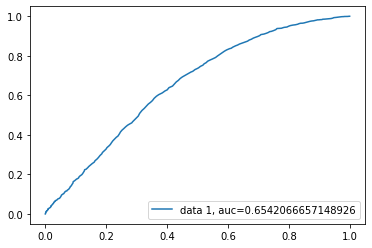

mass= 750
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)


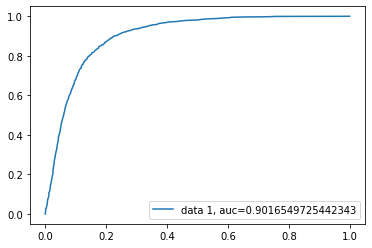

mass= 1000
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.2s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)


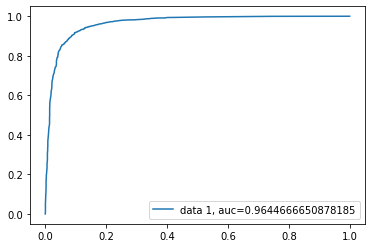

mass= 1250
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)


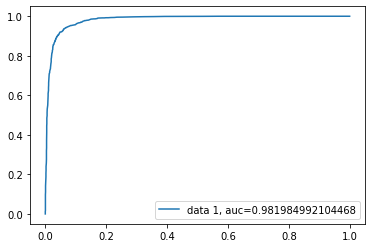

mass= 1500
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)


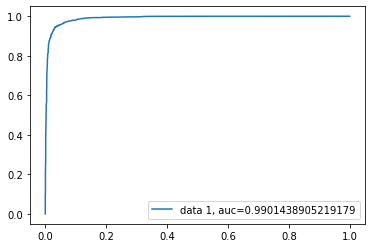

tn   fp    fn    tp       acc      prec    recall  F1_score  \
500   1979  418  1611   642  0.563656   0.60566  0.284953  0.387564   
750   2003  263   627  1757  0.808602  0.869802  0.736997  0.797911   
1000  2138  158   301  2053   0.90129  0.928539  0.872133  0.899452   
1250  2262  107   204  2077  0.933118  0.951007  0.910566  0.930347   
1500  2245   66   153  2186  0.952903  0.970693  0.934587  0.952298   

     kappa_cohen       auc  
500     0.112356  0.654207  
750     0.618474  0.901655  
1000    0.802701  0.964467  
1250    0.866083  0.981985  
1500    0.905824  0.990144

BTAG = all1
mass= 500
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)


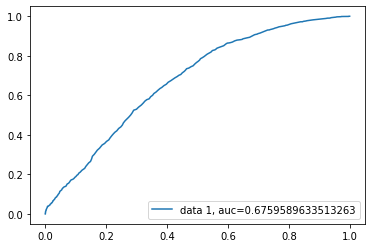

mass= 750
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)


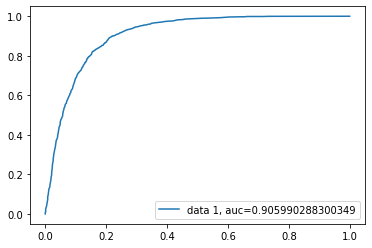

mass= 1000
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)


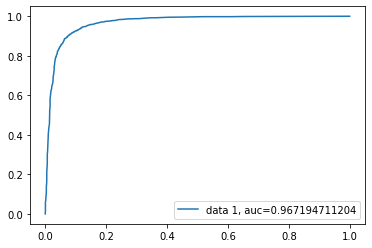

mass= 1250
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)


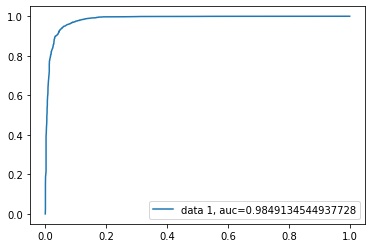

mass= 1500
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.9s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)


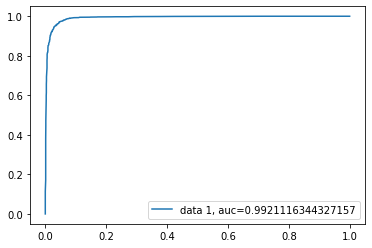

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1613  784  968  1285  0.623226  0.621073  0.570351  0.594632   
750   1906  360  419  1965  0.832473  0.845161  0.824245  0.834572   
1000  2110  186  217  2137  0.913333  0.919931  0.907816  0.913834   
1250  2255  114  161  2120   0.94086   0.94897  0.929417  0.939092   
1500  2238   73  119  2220   0.95871  0.968164  0.949124  0.958549   

     kappa_cohen       auc  
500     0.243873  0.675959  
750     0.664946   0.90599  
1000    0.826669  0.967195  
1250    0.881633  0.984913  
1500    0.917426  0.992112

BTAG = all2
mass= 500
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   33.2s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)


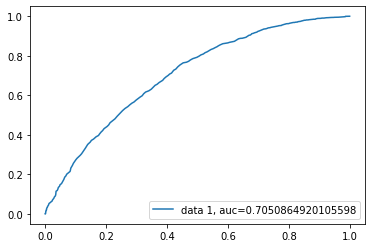

mass= 750
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)


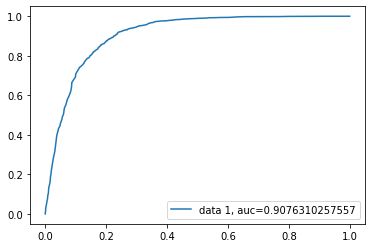

mass= 1000
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)


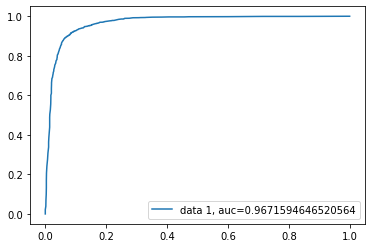

mass= 1250
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)


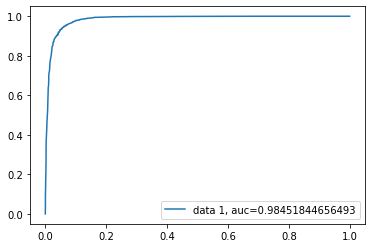

mass= 1500
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.9s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)


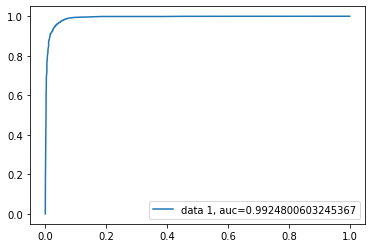

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1429  968  674  1579  0.646882  0.619945  0.700843  0.657917   
750   1783  483  270  2114  0.838065  0.814016  0.886745  0.848826   
1000  2050  246  159  2195  0.912903  0.899222  0.932455  0.915537   
1250  2233  136  129  2152  0.943011  0.940559  0.943446     0.942   
1500  2206  105   75  2264   0.96129  0.955678  0.967935  0.961767   

     kappa_cohen       auc  
500     0.295846  0.705086  
750     0.675165  0.907631  
1000    0.825698  0.967159  
1250    0.885987  0.984518  
1500    0.922572   0.99248

BTAG = orig
mass= 500
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)


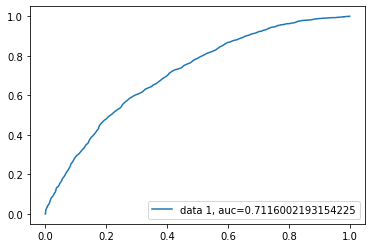

mass= 750
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.9s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)


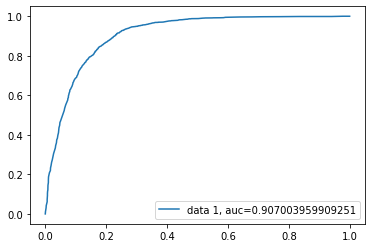

mass= 1000
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)


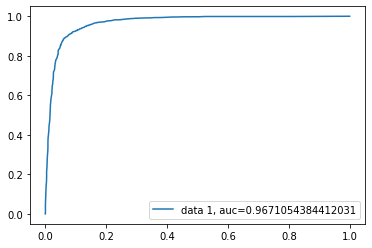

mass= 1250
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.2s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)


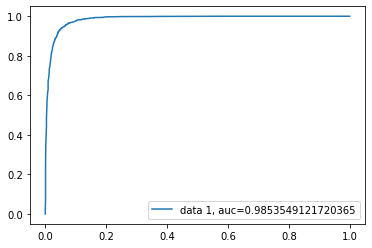

mass= 1500
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)


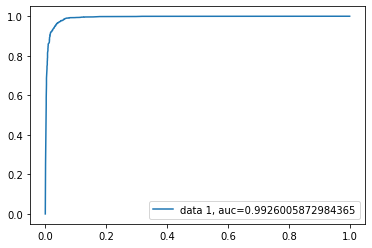

tn    fp   fn    tp       acc      prec    recall  F1_score  \
500   1396  1001  625  1628  0.650323  0.619247  0.722592   0.66694   
750   1797   469  296  2088  0.835484  0.816582  0.875839  0.845173   
1000  2068   228  177  2177  0.912903  0.905198  0.924809  0.914898   
1250  2234   135  128  2153  0.943441  0.940997  0.943884  0.942438   
1500  2217    94   79  2260  0.962796  0.960068  0.966225  0.963137   

     kappa_cohen       auc  
500     0.303466    0.7116  
750     0.670132  0.907004  
1000    0.825732  0.967105  
1250    0.886848  0.985355  
1500    0.925586  0.992601

BTAG = real
mass= 500
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.9s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)


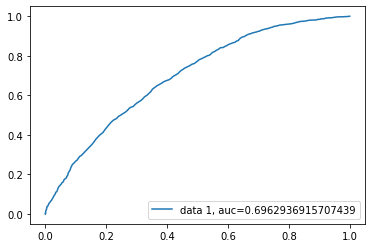

mass= 750
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.9s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)


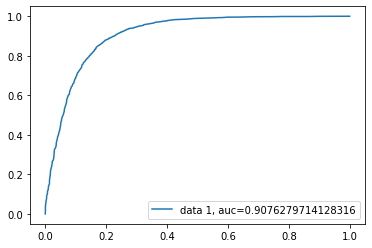

mass= 1000
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.2s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)


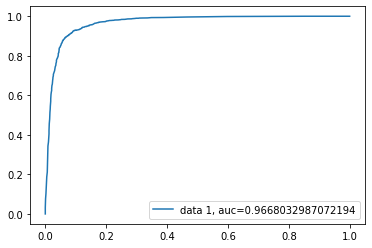

mass= 1250
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)


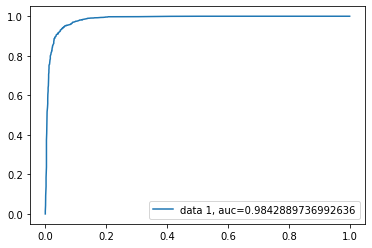

mass= 1500
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.2s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)


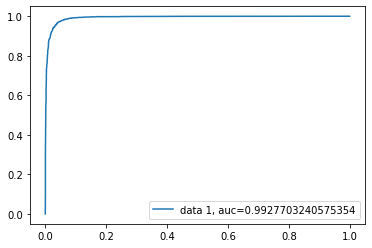

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1442  955  733  1520  0.636989  0.614141  0.674656  0.642978   
750   1821  445  293  2091   0.84129  0.824527  0.877097      0.85   
1000  2089  207  182  2172  0.916344  0.912989  0.922685  0.917811   
1250  2237  132  138  2143  0.941935  0.941978    0.9395  0.940737   
1500  2227   84   96  2243   0.96129  0.963902  0.958957  0.961423   

     kappa_cohen       auc  
500     0.275426  0.696294  
750     0.681848  0.907628  
1000     0.83264  0.966803  
1250    0.883824  0.984289  
1500     0.92258   0.99277

BTAG = all0
mass= 500
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)


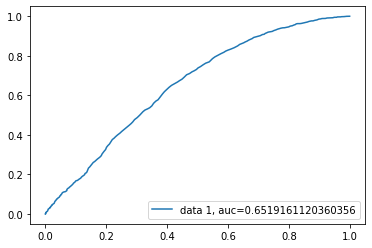

mass= 750
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.3s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)


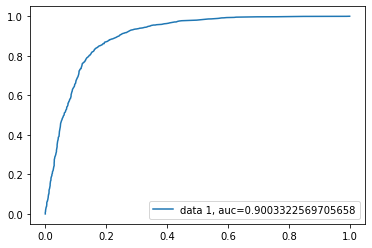

mass= 1000
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.3s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)


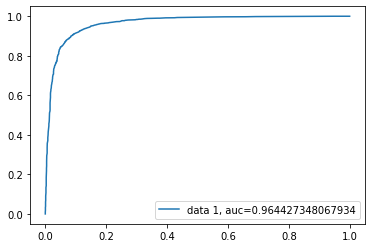

mass= 1250
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)


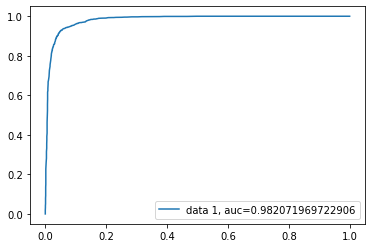

mass= 1500
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)


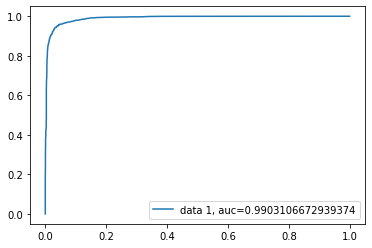

tn   fp    fn    tp       acc      prec    recall  F1_score  \
500   1956  441  1589   664  0.563441  0.600905  0.294718  0.395473   
750   2006  260   638  1746  0.806882  0.870389  0.732383  0.795444   
1000  2137  159   289  2065  0.903656  0.928507   0.87723  0.902141   
1250  2264  105   200  2081  0.934409  0.951967  0.912319  0.931722   
1500  2242   69   145  2194  0.953978   0.96951  0.938008  0.953498   

     kappa_cohen       auc  
500     0.112459  0.651916  
750     0.615104  0.900332  
1000    0.807416  0.964427  
1250    0.868669  0.982072  
1500    0.907972  0.990311

BTAG = all1
mass= 500
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)


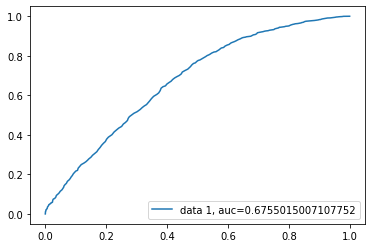

mass= 750
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)


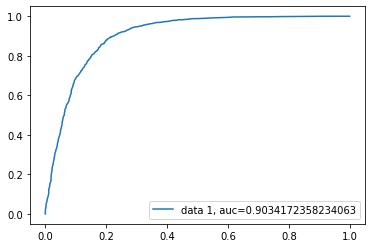

mass= 1000
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)


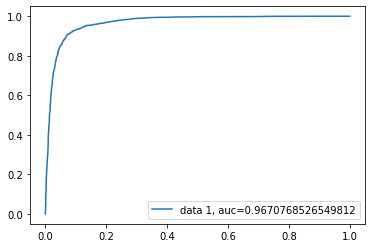

mass= 1250
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.9s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)


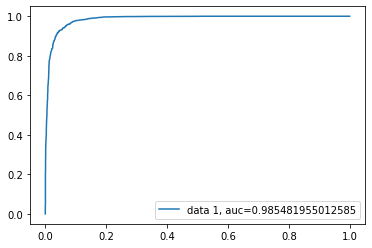

mass= 1500
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.2s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)


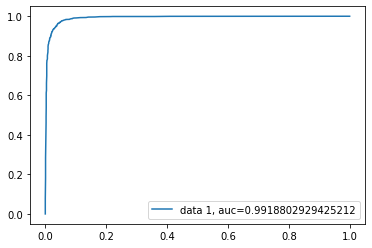

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1587  810  985  1268  0.613978  0.610202  0.562805  0.585546   
750   1878  388  406  1978  0.829247   0.83601  0.829698  0.832842   
1000  2114  182  207  2147  0.916344  0.921855  0.912065  0.916934   
1250  2253  116  163  2118      0.94  0.948075   0.92854  0.938206   
1500  2233   78  127  2212  0.955914  0.965939  0.945703  0.955714   

     kappa_cohen       auc  
500     0.225409  0.675502  
750     0.658342  0.903417  
1000    0.832685  0.967077  
1250    0.879911  0.985482  
1500    0.911836   0.99188

BTAG = all2
mass= 500
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)


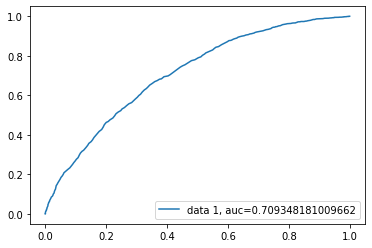

mass= 750
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.9s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)


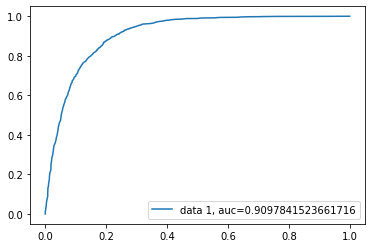

mass= 1000
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)


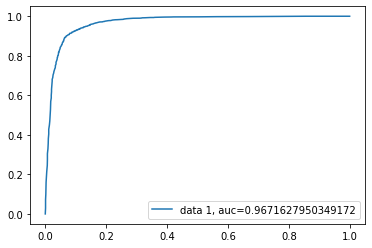

mass= 1250
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.2s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)


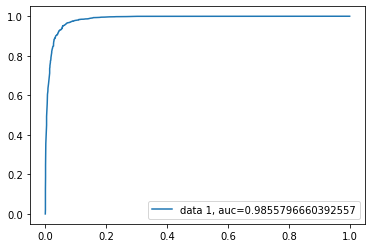

mass= 1500
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)


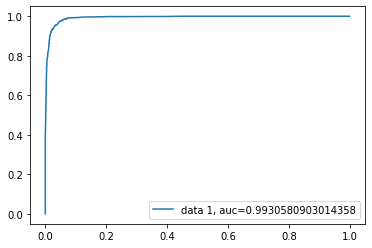

tn    fp   fn    tp       acc      prec    recall  F1_score  \
500   1388  1009  638  1615  0.645806  0.615473  0.716822  0.662292   
750   1800   466  283  2101  0.838925  0.818465  0.881292  0.848717   
1000  2045   251  156  2198  0.912473  0.897509   0.93373  0.915261   
1250  2229   140  111  2170  0.946022  0.939394  0.951337  0.945328   
1500  2207   104   67  2272  0.963226  0.956229  0.971355  0.963733   

     kappa_cohen       auc  
500     0.294423  0.709348  
750     0.676996  0.909784  
1000     0.82483  0.967163  
1250     0.89203   0.98558  
1500    0.926442  0.993058

BTAG = orig
mass= 500
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)


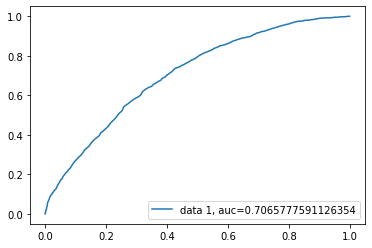

mass= 750
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.3s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)


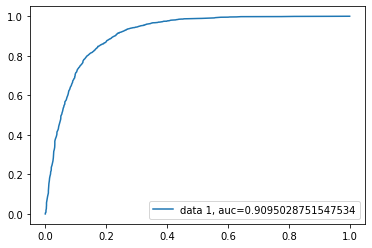

mass= 1000
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)


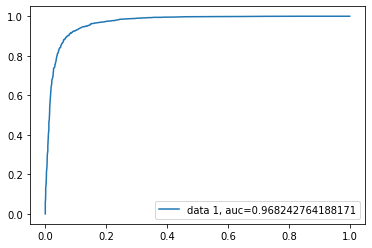

mass= 1250
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)


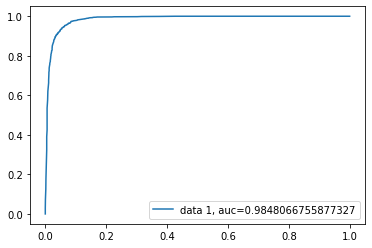

mass= 1500
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)


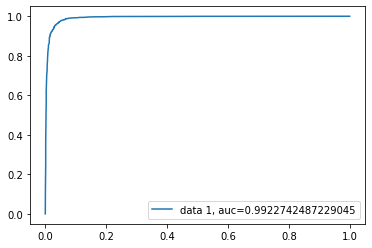

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1425  972  656  1597  0.649892  0.621643  0.708833  0.662381   
750   1781  485  272  2112  0.837204  0.813246  0.885906  0.848022   
1000  2082  214  176  2178  0.916129  0.910535  0.925234  0.917826   
1250  2236  133  131  2150  0.943226  0.941743  0.942569  0.942156   
1500  2214   97   80  2259  0.961935  0.958829  0.965797    0.9623   

     kappa_cohen       auc  
500     0.302053  0.706578  
750     0.673439  0.909503  
1000    0.832198  0.968243  
1250    0.886413  0.984807  
1500    0.923865  0.992274

BTAG = real
mass= 500
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)


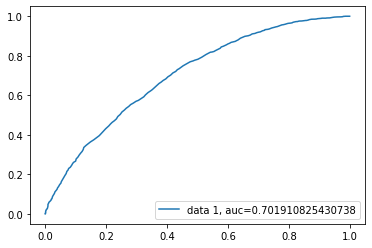

mass= 750
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)


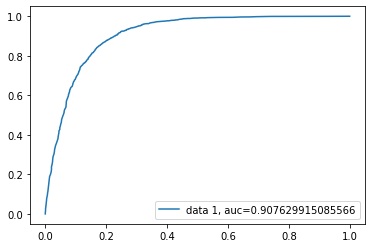

mass= 1000
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.3s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)


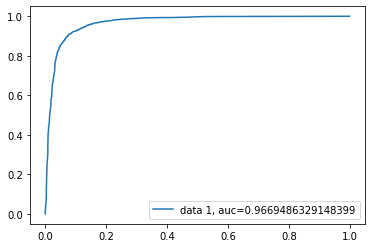

mass= 1250
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)


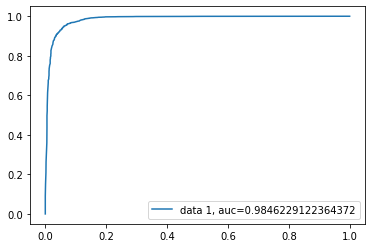

mass= 1500
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.9s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)


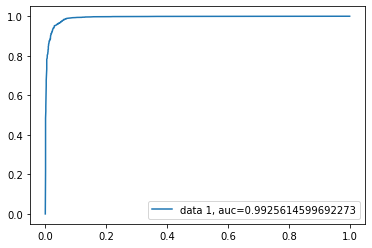

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1484  913  750  1503  0.642366  0.622103  0.667111  0.643821   
750   1832  434  317  2067  0.838495  0.826469   0.86703  0.846264   
1000  2089  207  186  2168  0.915484  0.912842  0.920986  0.916896   
1250  2233  136  133  2148  0.942151  0.940455  0.941692  0.941073   
1500  2222   89   98  2241  0.959785  0.961803  0.958102  0.959949   

     kappa_cohen       auc  
500     0.285597  0.701911  
750     0.676368   0.90763  
1000    0.830922  0.966949  
1250    0.884262  0.984623  
1500    0.919569  0.992561

BTAG = all0
mass= 500
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.9s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)


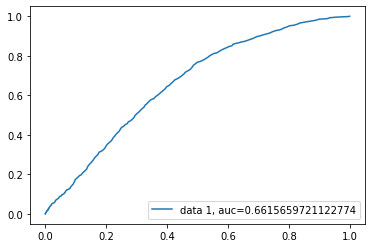

mass= 750
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)


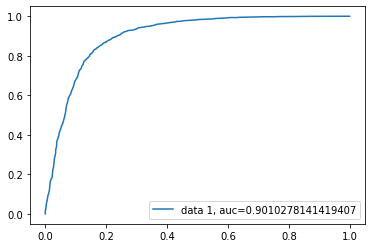

mass= 1000
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)


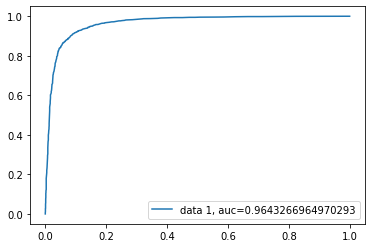

mass= 1250
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)


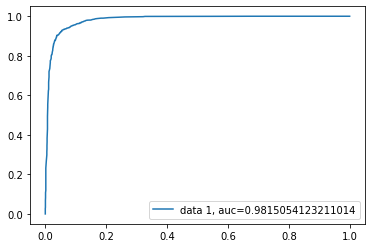

mass= 1500
B_tag_train_prop 
 0.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)


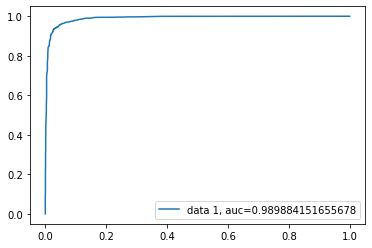

tn   fp    fn    tp       acc      prec    recall  F1_score  \
500   1927  470  1502   751  0.575914   0.61507  0.333333  0.432355   
750   1992  274   599  1785  0.812258  0.866926  0.748742  0.803511   
1000  2151  145   303  2051  0.903656  0.933971  0.871283  0.901538   
1250  2260  109   202  2079  0.933118  0.950183  0.911442  0.930409   
1500  2246   65   149  2190  0.953978  0.971175  0.936298  0.953418   

     kappa_cohen       auc  
500      0.13917  0.661566  
750     0.625603  0.901028  
1000    0.807445  0.964327  
1250    0.866087  0.981505  
1500    0.907974  0.989884

BTAG = all1
mass= 500
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)


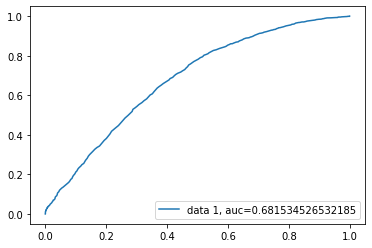

mass= 750
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)


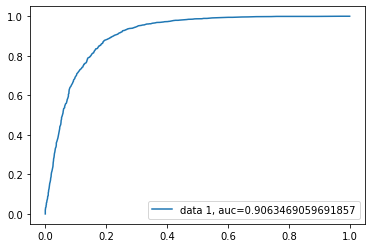

mass= 1000
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)


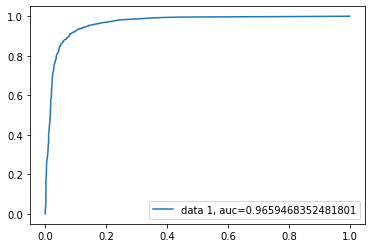

mass= 1250
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)


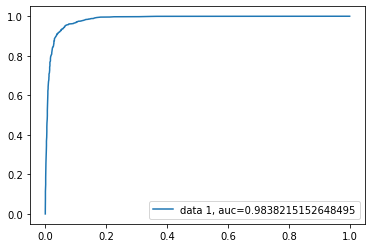

mass= 1500
B_tag_train_prop 
 1.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.3s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)


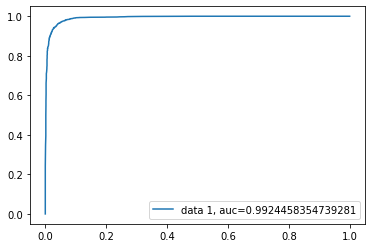

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1554  843  884  1369  0.628602  0.618897  0.607634  0.613214   
750   1909  357  444  1940  0.827742   0.84458  0.813758  0.828883   
1000  2108  188  210  2144  0.914409  0.919383   0.91079  0.915066   
1250  2255  114  175  2106  0.937849  0.948649  0.923279  0.935792   
1500  2230   81  121  2218  0.956559  0.964767  0.948268  0.956447   

     kappa_cohen       auc  
500     0.256085  0.681535  
750     0.655589  0.906347  
1000    0.828811  0.965947  
1250    0.875593  0.983822  
1500    0.913124  0.992446

BTAG = all2
mass= 500
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)


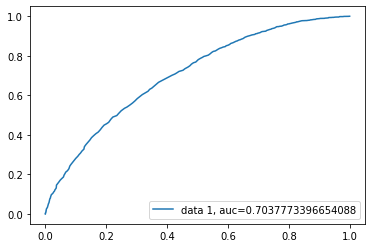

mass= 750
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)


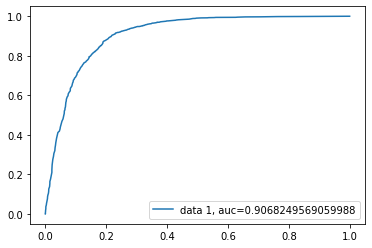

mass= 1000
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)


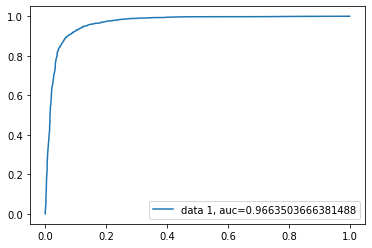

mass= 1250
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)


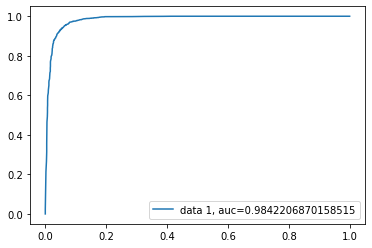

mass= 1500
B_tag_train_prop 
 2.0    100.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)


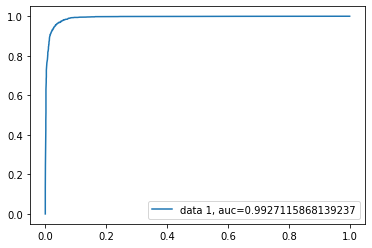

tn    fp   fn    tp       acc      prec    recall  F1_score  \
500   1297  1100  598  1655  0.634839  0.600726  0.734576  0.660942   
750   1799   467  272  2112  0.841075  0.818922  0.885906  0.851098   
1000  2073   223  180  2174  0.913333  0.906967  0.923534  0.915176   
1250  2230   139  127  2154  0.942796  0.939381  0.944323  0.941845   
1500  2207   104   73  2266  0.961935  0.956118   0.96879  0.962412   

     kappa_cohen       auc  
500     0.273836  0.703777  
750     0.681267  0.906825  
1000      0.8266   0.96635  
1250    0.885562  0.984221  
1500    0.923862  0.992712

BTAG = orig
mass= 500
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.2s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)


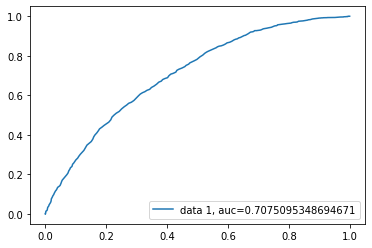

mass= 750
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)


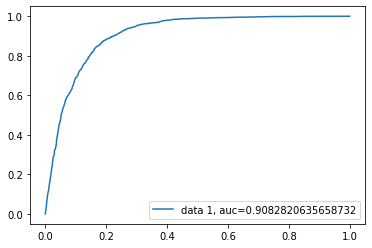

mass= 1000
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)


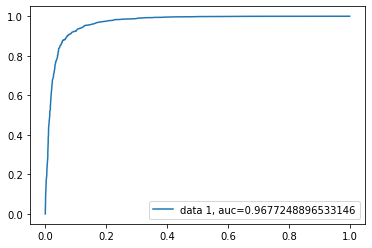

mass= 1250
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)


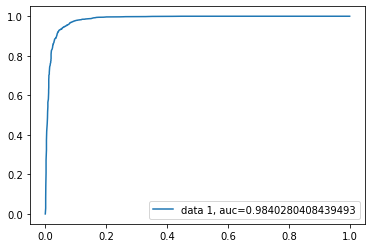

mass= 1500
B_tag_train_prop 
 2.0    86.471414
1.0    12.954186
0.0     0.574400
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)


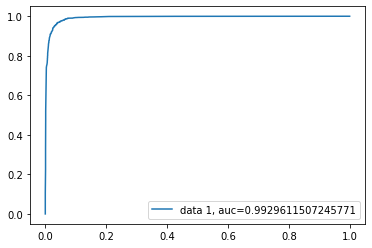

tn    fp   fn    tp       acc      prec    recall  F1_score  \
500   1361  1036  617  1636  0.644516  0.612275  0.726143  0.664365   
750   1813   453  281  2103  0.842151   0.82277  0.882131  0.851417   
1000  2079   217  180  2174  0.914624  0.909243  0.923534  0.916333   
1250  2234   135  131  2150  0.942796  0.940919  0.942569  0.941743   
1500  2210   101   71  2268  0.963011  0.957366  0.969645  0.963466   

     kappa_cohen       auc  
500     0.292303   0.70751  
750     0.683503  0.908282  
1000    0.829187  0.967725  
1250    0.885554  0.984028  
1500    0.926013  0.992961

BTAG = real
mass= 500
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)


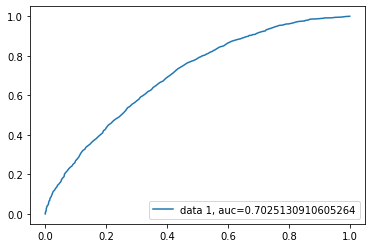

mass= 750
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.3s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)


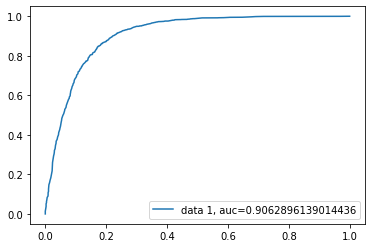

mass= 1000
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)


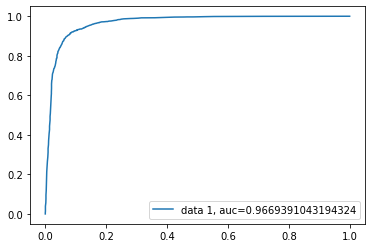

mass= 1250
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.9s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)


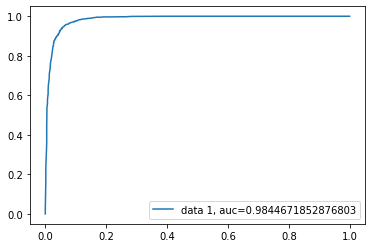

mass= 1500
B_tag_train_prop 
 2.0    65.0
1.0    33.0
0.0     2.0
dtype: float64
X_train_shape (9300, 27)
X_test_shape (4650, 27)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)


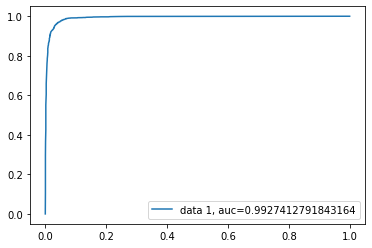

tn   fp   fn    tp       acc      prec    recall  F1_score  \
500   1455  942  717  1536  0.643226  0.619855  0.681758  0.649334   
750   1829  437  314  2070  0.838495  0.825688  0.868289  0.846453   
1000  2079  217  179  2175  0.914839  0.909281  0.923959  0.916561   
1250  2239  130  135  2146  0.943011  0.942882  0.940815  0.941848   
1500  2230   81   96  2243  0.961935  0.965146  0.958957  0.962042   

     kappa_cohen       auc  
500     0.287903  0.702513  
750     0.676346   0.90629  
1000    0.829616  0.966939  
1250    0.885976  0.984467  
1500    0.923871  0.992741

<Figure size 432x288 with 0 Axes>

In [18]:
all0=[]
all1=[]
all2=[]
orig=[]
real=[]
    
for rs in range(10):
    
    for btag in ["all0","all1","all2","orig","real",]:

        df_metrics = pd.DataFrame(index=[500,750,1000,1250,1500], columns=["tn", "fp", "fn", "tp", "acc", "prec","recall",
                                                                       "F1_score","kappa_cohen","auc"])
        print("BTAG =", btag)

        df_btag=df.copy()

        if btag=="all0":
            df_btag=df_btag[df_btag.loc[:,['jet1_btag','jet2_btag',"jet3_btag","jet4_btag"]].sum(axis=1)==0]
        elif btag=="all1":
            df_btag=df_btag[df_btag.loc[:,['jet1_btag','jet2_btag',"jet3_btag","jet4_btag"]].sum(axis=1)==1]
            df_btag=df_btag.sample(df_btag.shape[0], random_state=rs).reset_index(drop=True)
        elif btag=="all2":                          
            df_btag=df_btag[df_btag.loc[:,['jet1_btag','jet2_btag',"jet3_btag","jet4_btag"]].sum(axis=1)==2]
            df_btag=df_btag.sample(df_btag.shape[0], random_state=rs).reset_index(drop=True)

        elif btag=="orig":                          
            df_btag=df_btag.sample(df_btag.shape[0], random_state=rs).reset_index(drop=True)

        elif btag=="real": #65,33,2
            df0=df_btag[df_btag.loc[:,['jet1_btag','jet2_btag',"jet3_btag","jet4_btag"]].sum(axis=1)==0]
            df1=df_btag[df_btag.loc[:,['jet1_btag','jet2_btag',"jet3_btag","jet4_btag"]].sum(axis=1)==1].sample(n=int(df0.shape[0]*(33/2)), random_state=6, replace=False)
            df2=df_btag[df_btag.loc[:,['jet1_btag','jet2_btag',"jet3_btag","jet4_btag"]].sum(axis=1)==2].sample(n=int(df0.shape[0]*(65/2)), random_state=6, replace=False)
            frames = [df1, df2, df0]
            df_btag = pd.concat(frames)
            df_btag=df_btag.sample(df_btag.shape[0], random_state=rs).reset_index(drop=True)


        for i in (500,750,1000,1250,1500):

            print('mass=', i )

            dfmass1000=df_btag.loc[df_btag['mass'] == i]
            dfmass0=df_btag.loc[df_btag['mass'] == 0].sample(n=dfmass1000.shape[0], random_state=rs, replace=False)        #0 same size of dfmass1000
            dfmass1000=pd.concat([dfmass1000, dfmass0]).sample(frac=1).reset_index(drop=True)    #concatenating and shuffling
            dfmass1000=dfmass1000.drop('mass', axis=1) 

            #test
            #Siempre el mismo test: !!!
            dfmass1000test=df_originaltest.loc[df_originaltest['mass'] == i]
            dfmass0test=df_originaltest.loc[df_originaltest['mass'] == 0].sample(random_state=0,n=dfmass1000test.shape[0])
            np.random.seed(0)
            dfmass1000test=pd.concat([dfmass1000test, dfmass0test]).sample(frac=1).reset_index(drop=True)
            dfmass1000test=dfmass1000test.drop('mass', axis=1)
            np.random.seed(rs)
            dfmass1000=dfmass1000.sample(n=9300, random_state=rs)
            dfmass1000test=dfmass1000test.sample(n=4650, random_state=0)




            print("B_tag_train_prop", "\n" ,df_btag.loc[:,['jet1_btag','jet2_btag',"jet3_btag","jet4_btag"]].sum(axis=1).value_counts()/df_btag.shape[0]*100)


            drop=['lep_eta', 'lep_phi',  'met_phi', 'jets_no', 'jet1_eta', 'jet1_phi', 'jet1_btag', 
               'jet2_eta', 'jet2_phi', 'jet2_btag',  'jet3_eta', 'jet3_phi',
               'jet3_btag', 'jet4_eta', 'jet4_phi', 'jet4_btag']

            X_train=dfmass1000.drop(['label'], axis=1)
            X_train=X_train.drop(drop, axis=1)
            y_train=dfmass1000.label

            X_test=dfmass1000test.drop(['label'], axis=1)
            X_test=X_test.drop(drop, axis=1)
            y_test=dfmass1000test.label

            print("X_train_shape",X_train.shape)
            print("X_test_shape",X_test.shape)




            grid,best_model,y_pred,y_pred_proba = model(X_train,y_train,X_test, rs)
            print(best_model)


        #Roc curve construction

            fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
            auc = metrics.roc_auc_score(y_test, y_pred_proba)
            plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
            plt.legend(loc=4)
            #plt.savefig(cwd2+'MASS=' + str(i) + 'ROC.png')
            plt.show()
            plt.clf() 

        #METRICS 

            tn, fp, fn, tp, acc, prec,recall, F1_score,kappa_cohen=Scores(y_test,y_pred)

            df_metrics.tn[i]=tn
            df_metrics.fp[i]=fp
            df_metrics.fn[i]=fn
            df_metrics.tp[i]=tp
            df_metrics.acc[i]=acc
            df_metrics.prec[i]=prec
            df_metrics.recall[i]=recall
            df_metrics.F1_score[i]=F1_score
            df_metrics.kappa_cohen[i]=kappa_cohen
            df_metrics.auc[i]=auc


        display(df_metrics)
        eval(btag).append(df_metrics)


In [19]:
l=[all0,all1,all2,orig,real]

with open("RF_trainvar_semvar.txt", "wb") as fp:   #Pickling
    pickle.dump(l, fp)
    
with open("RF_trainvar_semvar.txt", "rb") as fp:   # Unpickling
    b = pickle.load(fp)

In [5]:
with open("RF_trainvar_semvar.txt", "rb") as fp:   # Unpickling
    b = pickle.load(fp)

In [6]:
dfall0=pd.DataFrame()
dfall1=pd.DataFrame()
dfall2=pd.DataFrame()
orig=pd.DataFrame()
real=pd.DataFrame()

ldf=[dfall0,dfall1,dfall2,orig,real]

ldfmean=ldf.copy()
ldfstd=ldf.copy()



for j in range (5):
    ldf[j]=b[j][0]
    for i in range(len(b[j])):
        if i!=0:
            ldf[j] = pd.concat([ldf[j], b[j][i]]).apply(pd.to_numeric)
            
    ldfmean[j]=ldf[j].groupby(level=0).mean() 
    ldfstd[j]=ldf[j].groupby(level=0).std()        

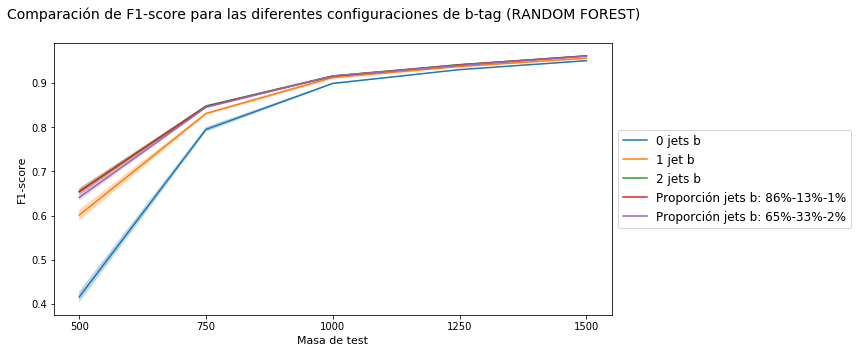

In [9]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(["500","750","1000","1250","1500"], ldfmean[0].F1_score, label="0 jets b")
ax.plot(["500","750","1000","1250","1500"], ldfmean[1].F1_score, label="1 jet b")
ax.plot(["500","750","1000","1250","1500"], ldfmean[2].F1_score, label="2 jets b")
ax.plot(["500","750","1000","1250","1500"], ldfmean[3].F1_score, label="Proporción jets b: 86%-13%-1%")
ax.plot(["500","750","1000","1250","1500"], ldfmean[4].F1_score, label="Proporción jets b: 65%-33%-2%")

ax.fill_between(["500","750","1000","1250","1500"], ldfmean[0].F1_score - ldfstd[0].F1_score, ldfmean[0].F1_score + ldfstd[0].F1_score, alpha=0.3)
ax.fill_between(["500","750","1000","1250","1500"], ldfmean[1].F1_score - ldfstd[1].F1_score, ldfmean[1].F1_score + ldfstd[1].F1_score, alpha=0.3)
ax.fill_between(["500","750","1000","1250","1500"], ldfmean[2].F1_score - ldfstd[2].F1_score, ldfmean[2].F1_score + ldfstd[2].F1_score, alpha=0.3)
ax.fill_between(["500","750","1000","1250","1500"], ldfmean[3].F1_score - ldfstd[3].F1_score, ldfmean[3].F1_score + ldfstd[3].F1_score, alpha=0.3)
ax.fill_between(["500","750","1000","1250","1500"], ldfmean[4].F1_score - ldfstd[4].F1_score, ldfmean[4].F1_score + ldfstd[4].F1_score, alpha=0.3)



ax.set_xlabel('Masa de test', fontsize=11)
ax.set_ylabel('F1-score', fontsize=11)
ax.legend(fontsize='large',loc='center left', bbox_to_anchor=(1, 0.5))
fig.suptitle('Comparación de F1-score para las diferentes configuraciones de b-tag (RANDOM FOREST)' , fontsize=14)
plt.show()